In [1]:
import math
import numpy as np
import random
from tqdm.notebook import tqdm
import nashpy as nash
import matplotlib


class Machine:
    
    def __init__(self, vulnerable, percentValue, penetrate, protectionLevel, possibilityProtection):
        self.vulnerable = vulnerable
        self.percentValue = percentValue
        self.penetrate = penetrate
        self.protectionLevel = protectionLevel
        self.possibilityProtection = possibilityProtection
        
    def changeVulnerable(self, vulnerable):
        self.vulnerable = vulnerable
    
    def changeCost(self, percentValue):
        self.percentValue = float(percentValue)
        
    def changePenetrate(self, penetrate):
        self.penetrate = penetrate
    
    def changeProtectionLevel(self, protectionLevel):
        self.protectionLevel = float(protectionLevel)
    
    def changePossibilityProtection(self, possibilityProtection):
        self.possibilityProtection = possibilityProtection
        
    def pr(self):
        print(self.vulnerable, self.percentValue, self.penetrate)

        
def printAllvalues(machineValues, vulnerableMachineValues, importantMachineValues):
    print('machine values = ', machineValues, 'vulnerable machine values = ', vulnerableMachineValues, 'important machine values =', importantMachineValues)
#получаем кол-во машин
def GetMachineValues():
    machineValues = random.randint(4, 15)
    return machineValues
#получаем кол-во уязвимых машин 
def GetVulnerableMachineValues(machineValues):
    vulnerableMachineValues = random.randint(1, machineValues)
    return vulnerableMachineValues
#получаем номер главной машины
def GetImportantMachineValues(machineValues):
    importantMachineValues = random.randint(1, machineValues)
    return importantMachineValues
#получаем процент, который занимает главная машина 
def GetPercentValue():
    percentValue = random.randint(30, 60)
    return percentValue

def GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues):
    machineArray = []
    percentValue = GetPercentValue() / 100
    reversePercent = ((100 - percentValue) / (machineValues - 1)) / 100
    reversePercent = ("%.2f" % reversePercent)
    for i in range(machineValues):
        if i == (importantMachineValues - 1):
            tmp = Machine(False, float(percentValue), False, float(0.0), False)
        else:
            tmp = Machine(False, float(reversePercent), False, float(0.0), False)
        machineArray.append(tmp)
    #здесь баг - может 2 и более раз сгенерироваться
    #одинаковое число и поэтому кол-во машин будет неточным
    for i in range(0, vulnerableMachineValues):
        j = random.randint(0, machineValues - 1)
        machineArray[j].changeVulnerable(True)
    return machineArray
#возвращает число уязвимых машин, так как из-за бага
#прошлое число уязвимых != новому
def GetVulnerableMachine(machineValues, machineArray):
    vulnerableMachine = 0
    for i in range(machineValues):
        if machineArray[i].vulnerable == True:
            vulnerableMachine += 1
    return vulnerableMachine
#это все возможные разрывы функции стоимости на данном промежутке 1-10
def CheckCost(a):
    BreakFunc = {
        '1':'1',
        '2':'0.5',
        '3':'0.333',
        '4':'0.25',
        '5':'0.2',
        '6':'0.166',
        '7':'0.142',
        '8':'0.125',
        '9':'0.111',
        '10':'0.1'
    }
    return BreakFunc[a]
#в этой функции есть разрыв, то что справа от него по x
#то не получится защитить, так как не хватит ресурсов
#этот разрыв в той точке, где знаменатель обращается в 0
def CostFunction(s, a, Ei):
    #return -(s * Ei * Ei)/(a * Ei - 1)
    try:
        return -(s * Ei * Ei)/(a * Ei - 1)
    except ZeroDivisionError:
        return 0
    #С условием в распределении уровней защиты в стратегиях - не должно быть деления на 0

def UtilityDefender(s, a, Ei, machineArray):
    # l - процент понесенных потерь машин
    tmp = 0
    percent = len(machineArray) / 100
    l = 0
    for i in range(len(machineArray)):
        if machineArray[i].penetrate == True:
            l += percent
            tmp += CostFunction(s, a, machineArray[i].protectionLevel)
    return - l - tmp

def UtilityAttacker(machineArray):
    percent = len(machineArray) / 100
    l = 0
    for i in range(len(machineArray)):
        if machineArray[i].penetrate == True:
            l += percent
    return l
    
def AttackerStrategyProportional(machineArray):
    attackerProportionalEffort = []
    for i in range(len(machineArray)):
        tmp = machineArray[i].percentValue
        attackerProportionalEffort.append(tmp)
    return attackerProportionalEffort
#Если в пером раунде атакующий взломал >= 1 машины
#То он перераспределяет свои ресурсы
#отложи эту функцию, пока что протестируем без перераспределения
def AttackerStrategyProportionalRedistribution(machineArray):
    attackerProportionalEffort = []
    for i in range(len(machineArray)):
        if machineArray[i].penetrate == False:
            tmp = machineArray[i].percentValue
            attackerProportionalEffort.append(tmp)
        else:
            attackerProportionalEffort.append(0)
    return attackerProportionalEffort
        
def AttackerStrategyHigh():
    attackerHighEffort = 1
    return attackerHighEffort
        
def DefenderStrategyNothing():
    return None
    
def DefenderStrategyProportional(machineArray, Ei, a):
    a = str(a)
    for i in range(len(machineArray)):
        if float(CheckCost(a)) < machineArray[i].percentValue * Ei:
            machineArray[i].changePossibilityProtection(False)
        else:
            machineArray[i].changePossibilityProtection(True)
            machineArray[i].changeProtectionLevel("%.2f" % (machineArray[i].percentValue * Ei))
    
def DefenderStrategyHigh(Ei, importantMachineValues, machineArray, a):
    if float(CheckCost(str(a))) < Ei:
        machineArray[importantMachineValues - 1].changePossibilityProtection(False)
    else:
        machineArray[importantMachineValues - 1].changePossibilityProtection(True)
        machineArray[importantMachineValues - 1].changeProtectionLevel(Ei)
#P-атакующий H-защитник
def ComparisonStrategyPH(machineArray, importantMachineValues, Ei):
    attackerProportionalEffort = AttackerStrategyProportional(machineArray)
    DefenderStrategyHigh(Ei, importantMachineValues, machineArray, a)
    count = 0
    for i in range(len(machineArray)):
        if machineArray[i].vulnerable == True:
            if attackerProportionalEffort[i] > machineArray[i].percentValue or attackerProportionalEffort[importantMachineValues - 1] > machineArray[importantMachineValues - 1].protectionLevel:
                machineArray[i].changePenetrate(True)
                count += 1
    if count > 1:
        return True
    else:
        return False
#P-атакующий P-защитник
def ComparisonStrategyPP(machineArray, Ei, a):
    attackerProportionalEffort = AttackerStrategyProportional(machineArray)
    DefenderStrategyProportional(machineArray, Ei, a)
    count = 0
    for i in range(len(machineArray)):
        if attackerProportionalEffort[i] > machineArray[i].protectionLevel:
            if machineArray[i].vulnerable == True:
                machineArray[i].changePenetrate(True)
                count += 1
    if count > 0:
        return True
    else:
        return False
#P - атакующий N - защитник
def ComparisonStrategyPN(machineArray):
    attackerProportionalEffort = AttackerStrategyProportional(machineArray)
    count = 0
    for i in range(len(machineArray)):
        if attackerProportionalEffort[i] > machineArray[i].percentValue:
            if machineArray[i].vulnerable == True:
                machineArray[i].changePenetrate(True)
                count += 1
    if count > 0:
        return True
    else:
        return False
#H-атакующий P-защитник
def ComparisonStrategyHP(machineArray, Ei, importantMachineValues, a):
    attackerHighEffort = AttackerStrategyHigh()
    DefenderStrategyProportional(machineArray, Ei, a)
    if attackerHighEffort > machineArray[importantMachineValues - 1].protectionLevel:
        if machineArray[importantMachineValues - 1].vulnerable == True:
            machineArray[importantMachineValues - 1].changePenetrate(True)
            return True
        else:
            return False
#H-атакующий H-защитник
def ComparsionStrategyHH(Ei, importantMachineValues, machineArray, a):
    attackerHighEffort = AttackerStrategyHigh()
    DefenderStrategyHigh(Ei, importantMachineValues, machineArray, a)
    if attackerHighEffort > machineArray[importantMachineValues - 1].protectionLevel:
        if machineArray[importantMachineValues - 1].vulnerable == True:
            machineArray[importantMachineValues - 1].changePenetrate(True)
            return True
        else:
            return False
#H-Атакующий N-защитник
def ComparsionStrategyHN(machineArray, importantMachineValues):
    attackerHighEffort = AttackerStrategyHigh()
    if attackerHighEffort > machineArray[importantMachineValues - 1].percentValue:
        if machineArray[importantMachineValues - 1].vulnerable == True:
            machineArray[importantMachineValues - 1].changePenetrate(True)
            return True
        else:
            return False
        
def CheckStrategyDefender(b):
    NumberStrategy = {
        '1':'Noting',
        '2':'High',
        '3':'High',
        '4':'High',
        '5':'High',
        '6':'High',
        '7':'High',
        '8':'High',
        '9':'High',
        '10':'High',
        '11':'Proportional',
        '12':'Proportional',
        '13':'Proportional',
        '14':'Proportional',
        '15':'Proportional',
        '16':'Proportional',
        '17':'Proportional',
        '18':'Proportional',
        '19':'Proportional'
    }
    return NumberStrategy[b]
        
#def UtilityAttackerPlot(numEqulibriumAttacker, s, a):
    

#def UtilityDefenderPlot(numEqulibriumDefender, s, a):

    
for s in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9):
    for a in range(1, 11, 1):
        shape = (19,2) #матрица игры
        Attacker = np.zeros(shape=shape)
        Defender = np.zeros(shape=shape)
        #1 - Proportional 2 - High
        for strategyA in (1, 2):
            #1 - High 2 - Proportional 3 - Nothing
            for strategyD in (1, 2, 3):
                for Ei in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9):
                    if strategyA == 1 and strategyD == 1:
                        j = 0
                        utilityDefender = 0
                        utilityAttacker = 0
                        for j in tqdm(range(50000)):
                            machineValues = GetMachineValues()
                            vulnerableMachineValues = GetVulnerableMachineValues(machineValues)
                            importantMachineValues = GetImportantMachineValues(machineValues)
                            machineArray = GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues)
                            tmp = ComparisonStrategyPH(machineArray, importantMachineValues, Ei)
                            if tmp == True:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                                utilityAttacker += UtilityAttacker(machineArray)
                            else:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                        print('for s =', s,'a =', a, 'sA = ', strategyA, 'sd =', strategyD, 'Ei =', Ei)
                        print('Utility A =', utilityAttacker, 'utility D =', utilityDefender)
                    elif strategyA == 1 and strategyD == 2:
                        j = 0
                        utilityDefender = 0
                        utilityAttacker = 0
                        for j in tqdm(range(50000)):
                            machineValues = GetMachineValues()
                            vulnerableMachineValues = GetVulnerableMachineValues(machineValues)
                            importantMachineValues = GetImportantMachineValues(machineValues)
                            machineArray = GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues)
                            tmp = ComparisonStrategyPP(machineArray, Ei, a)
                            if tmp == True:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                                utilityAttacker += UtilityAttacker(machineArray)
                            else:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                        print('for s =', s,'a =', a, 'sA = ', strategyA, 'sd =', strategyD, 'Ei =', Ei)
                        print('Utility A =', utilityAttacker, 'utility D =', utilityDefender)
                    elif strategyA == 1 and strategyD == 3:
                        j = 0
                        utilityDefender = 0
                        utilityAttacker = 0
                        for j in tqdm(range(50000)):
                            machineValues = GetMachineValues()
                            vulnerableMachineValues = GetVulnerableMachineValues(machineValues)
                            importantMachineValues = GetImportantMachineValues(machineValues)
                            machineArray = GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues)
                            tmp = ComparisonStrategyPN(machineArray)
                            if tmp == True:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                                utilityAttacker += UtilityAttacker(machineArray)
                            else:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                        print('for s =', s,'a =', a, 'sA = ', strategyA, 'sd =', strategyD, 'Ei =', Ei)
                        print('Utility A =', utilityAttacker, 'utility D =', utilityDefender)
                    elif strategyA == 2 and strategyD == 1:
                        j = 0
                        utilityDefender = 0
                        utilityAttacker = 0
                        for j in tqdm(range(50000)):
                            machineValues = GetMachineValues()
                            vulnerableMachineValues = GetVulnerableMachineValues(machineValues)
                            importantMachineValues = GetImportantMachineValues(machineValues)
                            machineArray = GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues)
                            tmp = ComparsionStrategyHH(Ei, importantMachineValues, machineArray, a)
                            if tmp == True:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                                utilityAttacker += UtilityAttacker(machineArray)
                            else:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                        print('for s =', s,'a =', a, 'sA = ', strategyA, 'sd =', strategyD, 'Ei =', Ei)
                        print('Utility A =', utilityAttacker, 'utility D =', utilityDefender) 
                    elif strategyA == 2 and strategyD == 2:
                        j = 0
                        utilityDefender = 0
                        utilityAttacker = 0
                        for j in tqdm(range(50000)):
                            machineValues = GetMachineValues()
                            vulnerableMachineValues = GetVulnerableMachineValues(machineValues)
                            importantMachineValues = GetImportantMachineValues(machineValues)
                            machineArray = GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues)
                            tmp = ComparisonStrategyHP(machineArray, Ei, importantMachineValues, a)
                            if tmp == True:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                                utilityAttacker += UtilityAttacker(machineArray)
                            else:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                        print('for s =', s,'a =', a, 'sA = ', strategyA, 'sd =', strategyD, 'Ei =', Ei)
                        print('Utility A =', utilityAttacker, 'utility D =', utilityDefender)
                    elif strategyA == 2 and strategyD == 3:
                        j = 0
                        utilityDefender = 0
                        utilityAttacker = 0
                        for j in tqdm(range(50000)):
                            machineValues = GetMachineValues()
                            vulnerableMachineValues = GetVulnerableMachineValues(machineValues)
                            importantMachineValues = GetImportantMachineValues(machineValues)
                            machineArray = GetMachineArray(machineValues, vulnerableMachineValues, importantMachineValues)
                            tmp = ComparsionStrategyHN(machineArray, importantMachineValues)
                            if tmp == True:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                                utilityAttacker += UtilityAttacker(machineArray)
                            else:
                                utilityDefender += UtilityDefender(s, a, Ei, machineArray)
                        print('for s =', s,'a =', a, 'sA = ', strategyA, 'sd =', strategyD, 'Ei =', Ei)
                        print('Utility A =', utilityAttacker, 'utility D =', utilityDefender)
                    if strategyD == 3:
                        Attacker[0, strategyA - 1] = round(utilityAttacker)
                        Defender[0, strategyA - 1] = round(utilityDefender)
                    elif strategyD == 1:
                        index = int(Ei * 10)
                        Attacker[index, strategyA - 1] = round(utilityAttacker)
                        Defender[index, strategyA - 1] = round(utilityDefender)
                    elif strategyD == 2:
                        index = int(Ei * 10) + 9
                        Attacker[index, strategyA - 1] = round(utilityAttacker)
                        Defender[index, strategyA - 1] = round(utilityDefender)
        qwe = False
        game = nash.Game(Attacker, Defender)
        print("Утилиты атакующего -", Attacker)
        print("Утилиты обороняющегося -", Defender)
        try:
            equlibrium = list(game.support_enumeration())[0]
        except IndexError:
            try:
                equlibrium = list(game.support_enumeration(non_degenerate=True))[0]
            except:
                equlibrium = list(game.support_enumeration(non_degenerate=True))
                qwe = True
        print("equlibrium", equlibrium)
        if qwe == False:
            numEqulibriumDefender = np.argmax(equlibrium[0])+1
            numEqulibriumAttacker = np.argmax(equlibrium[1])+1
        else:
            numEqulibriumDefender = equlibrium
            numEqulibriumAttacker = equlibrium
        print("оптимальная стратегия оброняющегося номер ", numEqulibriumDefender, "оптимальная стратегия атакующего номер ", numEqulibriumAttacker)
        #0 - нет равновесия, 5 - равновесие в стратегии nothing, 10 - равновесие в стратегии high, 15 - propotional
        c = [[0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0]]
        plotTmp = s * 10
        if qwe == False:
            if CheckStrategyDefender(numEqulibriumDefender) == 'Nothing':
                c[a][int(plotTmp)] = 5
        if qwe == False:
            if CheckStrategyDefender(numEqulibriumDefender) == 'Proportinal':
                c[a][int(plotTmp)] = 15
        if qwe == False:
            if CheckStrategyDefender(numEqulibriumDefender) == 'High':
                c[a][int(plotTmp)] = 10
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

fig, ax = plt.subplots()

ax.pcolormesh(x, y, c)

fig.set_figwidth(8)
fig.set_figheight(8)
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20358.680000001168 utility D = -20968.337777778164


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20408.66000000124 utility D = -21081.275000000915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19765.750000001368 utility D = -20594.002857143987


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13140.850000000397 utility D = -13883.426666667141


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6646.519999999727 utility D = -7193.739999999924


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20862.85000000177 utility D = -20871.20731758761


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 20830.320000001677 utility D = -20863.835031253664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 20907.240000001875 utility D = -20983.804196134384


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 21028.340000001685 utility D = -21172.82470641331


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 21020.290000001587 utility D = -21258.193151565127


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20884.410000001826 utility D = -21241.84810710237


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 20946.430000001994 utility D = -21460.253000613666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20961.350000001978 utility D = -21670.670787267583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 20948.09000000183 utility D = -21923.482071309307


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1989.1799999996797 utility D = -2012.9522222221083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1984.8299999996673 utility D = -2091.3400000002603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1987.6199999996538 utility D = -2262.6728571428775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1958.689999999661 utility D = -2522.8766666667043


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1978.2099999996738 utility D = -3043.4100000000094


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1983.929999999688 utility D = -3899.0399999998294


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1975.1699999996629 utility D = -5449.759999999935


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1969.7699999996805 utility D = -8736.169999999485


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.5799999996834 utility D = -19126.759999999602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1980.139999999665 utility D = -1984.9254049342856


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1985.619999999679 utility D = -2005.5841250774724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1987.1699999996717 utility D = -2035.0787670493307


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1979.669999999679 utility D = -2068.2925187282553


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.3599999996693 utility D = -2129.7716415544737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1972.9999999996724 utility D = -2200.928975878851


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1990.1899999996765 utility D = -2327.2600109154723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1972.4699999996697 utility D = -2447.541032103181


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1970.6099999996668 utility D = -2624.3601124166635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1969.1399999996725 utility D = -1969.1399999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1959.0299999996762 utility D = -1959.0299999996762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1993.3899999996668 utility D = -1993.3899999996668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1976.399999999667 utility D = -1976.399999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1988.8699999996768 utility D = -1988.8699999996768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1996.2799999996585 utility D = -1996.2799999996585


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1971.3699999996759 utility D = -1971.3699999996759


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1975.709999999675 utility D = -1975.709999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1971.2399999996658 utility D = -1971.2399999996658
Утилиты атакующего - [[    0.  1971.]
 [20359.  1989.]
 [20409.  1985.]
 [19766.  1988.]
 [13141.  1959.]
 [ 6647.  1978.]
 [    0.  1984.]
 [    0.  1975.]
 [    0.  1970.]
 [    0.  1973.]
 [20863.  1980.]
 [20830.  1986.]
 [20907.  1987.]
 [21028.  1980.]
 [21020.  1981.]
 [20884.  1973.]
 [20946.  1990.]
 [20961.  1972.]
 [20948.  1971.]]
Утилиты обороняющегося - [[     0.  -1971.]
 [-20968.  -2013.]
 [-21081.  -2091.]
 [-20594.  -2263.]
 [-13883.  -2523.]
 [ -7194.  -3043.]
 [     0.  -3899.]
 [     0.  -5450.]
 [     0.  -8736.]
 [     0. -19127.]
 [-20871.  -1985.]
 [-20864.  -2006.]
 [-20984.  -2035.]
 [-21173.  -2068.]
 [-21258.  -2130.]
 [-21242.  -2201.]
 [-21460.  -2327.]
 [-21671.  -2448.]
 [-21923.  -2624.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20394.980000001313 utility D = -20996.15750000035


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20233.180000001303 utility D = -20951.83999999991


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19838.000000001277 utility D = -20858.767500001744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13154.130000000374 utility D = -14641.860000000368


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6568.119999999796 utility D = -6753.89999999983


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20570.59000000131 utility D = -21144.490000001828


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20244.020000001135 utility D = -20828.060000001737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20296.09000000112 utility D = -20875.890000001586


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20491.110000001536 utility D = -21061.320000002135


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 21078.480000001844 utility D = -21087.121565156685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20943.590000002114 utility D = -20980.148437727992


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 20927.970000001733 utility D = -21015.958654588245


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 21009.93000000185 utility D = -21189.337327595593


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 20848.38000000176 utility D = -21175.032537698276


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 21111.660000001648 utility D = -21669.40141481664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 20904.070000001826 utility D = -21913.043523652832


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 21009.290000001693 utility D = -23382.036260602476


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 21004.390000001913 utility D = -24072.257697256628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1965.6999999996729 utility D = -1992.1037499993915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1972.6199999996675 utility D = -2114.1466666664846


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1990.9299999996697 utility D = -2471.912499999778


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1978.6199999996504 utility D = -3682.2999999998406


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1982.3899999996647 utility D = -1982.3899999996647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1983.9099999996658 utility D = -1983.9099999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1984.0199999996557 utility D = -1984.0199999996557


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1995.4899999996637 utility D = -1995.4899999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1975.609999999657 utility D = -1975.609999999657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1963.4099999996624 utility D = -1968.4595169365216


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1960.0799999996668 utility D = -1982.332021801832


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1962.259999999671 utility D = -2019.2631168967116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1978.349999999689 utility D = -2096.2674716375177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1987.229999999663 utility D = -2211.2262142068403


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1976.089999999676 utility D = -2381.4879994731687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1975.299999999664 utility D = -2756.779492587151


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1982.7399999996667 utility D = -4047.0366642108725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1975.7699999996778 utility D = -4546.6051527346945


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1967.3899999996838 utility D = -1967.3899999996838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1968.2699999996817 utility D = -1968.2699999996817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1963.8499999996757 utility D = -1963.8499999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1957.3099999996743 utility D = -1957.3099999996743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1980.2399999996674 utility D = -1980.2399999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.1399999996745 utility D = -1970.1399999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1998.1399999996747 utility D = -1998.1399999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1964.1499999996745 utility D = -1964.1499999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1974.4999999996676 utility D = -1974.4999999996676
Утилиты атакующего - [[    0.  1974.]
 [20395.  1966.]
 [20233.  1973.]
 [19838.  1991.]
 [13154.  1979.]
 [ 6568.  1982.]
 [20571.  1984.]
 [20244.  1984.]
 [20296.  1995.]
 [20491.  1976.]
 [21078.  1963.]
 [20944.  1960.]
 [20928.  1962.]
 [21010.  1978.]
 [20848.  1987.]
 [21112.  1976.]
 [20904.  1975.]
 [21009.  1983.]
 [21004.  1976.]]
Утилиты обороняющегося - [[     0.  -1974.]
 [-20996.  -1992.]
 [-20952.  -2114.]
 [-20859.  -2472.]
 [-14642.  -3682.]
 [ -6754.  -1982.]
 [-21144.  -1984.]
 [-20828.  -1984.]
 [-20876.  -1995.]
 [-21061.  -1976.]
 [-21087.  -1968.]
 [-20980.  -1982.]
 [-21016.  -2019.]
 [-21189.  -2096.]
 [-21175.  -2211.]
 [-21669.  -2381.]
 [-21913.  -2757.]
 [-23382.  -4047.]
 [-24072.  -4547.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20556.900000001227 utility D = -21153.264285715082


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20482.400000001286 utility D = -21266.45000000043


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19785.840000001197 utility D = -22191.79000000129


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20403.22000000115 utility D = -20988.29000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20334.240000001108 utility D = -20898.75000000162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20266.830000001068 utility D = -20846.910000001666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20433.93000000151 utility D = -21002.01000000204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20370.950000001274 utility D = -20947.370000001953


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20464.270000001172 utility D = -21032.280000001767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 21063.46000000176 utility D = -21072.58256105007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20843.410000001862 utility D = -20883.837486497756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 21009.76000000207 utility D = -21116.473860803897


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 21047.760000001894 utility D = -21296.57450360204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 21191.930000001907 utility D = -21819.625433829275


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21006.340000001604 utility D = -22881.416106384117


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 21026.110000002016 utility D = -22835.904621732807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 20873.820000001895 utility D = -22685.258040282264


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 20939.760000001923 utility D = -23219.692639580197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1982.9799999996537 utility D = -2013.444285714653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1980.1299999996727 utility D = -2192.8399999997982


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1981.3399999996734 utility D = -3900.5899999998205


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1970.5199999996669 utility D = -1970.5199999996669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1976.0299999996664 utility D = -1976.0299999996664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1976.8499999996725 utility D = -1976.8499999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.029999999672 utility D = -1981.029999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1979.6199999996757 utility D = -1979.6199999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1967.8099999996823 utility D = -1967.8099999996823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1968.029999999677 utility D = -1973.3451131895083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 2001.6399999996825 utility D = -2027.3393096735049


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1977.3499999996925 utility D = -2050.099093863682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1981.139999999666 utility D = -2164.074473393915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1979.8199999996818 utility D = -2487.629282332278


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1978.0799999996646 utility D = -3669.0419688753095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1967.14999999968 utility D = -3462.9197379611333


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1982.8399999996755 utility D = -3301.8070721384047


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1984.6299999996668 utility D = -3302.8730080971786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1981.8099999996648 utility D = -1981.8099999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1994.709999999669 utility D = -1994.709999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1996.849999999663 utility D = -1996.849999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1975.3799999996684 utility D = -1975.3799999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1993.1699999996708 utility D = -1993.1699999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1969.3799999996645 utility D = -1969.3799999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1989.1899999996642 utility D = -1989.1899999996642


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1991.2399999996705 utility D = -1991.2399999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1982.9399999996804 utility D = -1982.9399999996804
Утилиты атакующего - [[    0.  1983.]
 [20557.  1983.]
 [20482.  1980.]
 [19786.  1981.]
 [20403.  1971.]
 [20334.  1976.]
 [20267.  1977.]
 [20434.  1981.]
 [20371.  1980.]
 [20464.  1968.]
 [21063.  1968.]
 [20843.  2002.]
 [21010.  1977.]
 [21048.  1981.]
 [21192.  1980.]
 [21006.  1978.]
 [21026.  1967.]
 [20874.  1983.]
 [20940.  1985.]]
Утилиты обороняющегося - [[     0.  -1983.]
 [-21153.  -2013.]
 [-21266.  -2193.]
 [-22192.  -3901.]
 [-20988.  -1971.]
 [-20899.  -1976.]
 [-20847.  -1977.]
 [-21002.  -1981.]
 [-20947.  -1980.]
 [-21032.  -1968.]
 [-21073.  -1973.]
 [-20884.  -2027.]
 [-21116.  -2050.]
 [-21297.  -2164.]
 [-21820.  -2488.]
 [-22881.  -3669.]
 [-22836.  -3463.]
 [-22685.  -3302.]
 [-23220.  -3303.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20299.370000001258 utility D = -20906.300000000887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20594.200000001394 utility D = -21584.03000000033


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20476.110000001125 utility D = -21041.40000000164


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20364.670000001446 utility D = -20941.480000001997


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20396.64000000119 utility D = -20978.930000001877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20334.160000001222 utility D = -20903.640000001782


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20239.9100000014 utility D = -20807.350000001992


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20359.500000001313 utility D = -20935.230000001833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20327.89000000154 utility D = -20901.560000002126


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20937.48000000193 utility D = -20946.90180318245


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20913.450000002085 utility D = -20958.76122325169


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 21098.470000001715 utility D = -21236.026623660073


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20942.990000001595 utility D = -21573.085958578857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 20940.89000000202 utility D = -21595.09000036301


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 21163.980000002 utility D = -21755.63189300065


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 20945.200000001885 utility D = -21911.43377462192


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 20981.690000001847 utility D = -21476.54319794411


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 20911.310000001915 utility D = -21771.68126362296


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1971.519999999675 utility D = -2006.9666666669298


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1967.5699999996882 utility D = -2390.729999999916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1991.0299999996632 utility D = -1991.0299999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1971.6799999996588 utility D = -1971.6799999996588


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1969.1999999996838 utility D = -1969.1999999996838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1968.7199999996587 utility D = -1968.7199999996587


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1977.7499999996755 utility D = -1977.7499999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1978.6099999996784 utility D = -1978.6099999996784


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1973.2999999996616 utility D = -1973.2999999996616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1983.1799999996672 utility D = -1988.9240260737085


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1994.799999999653 utility D = -2024.7161031986614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1972.0699999996625 utility D = -2074.8897393577877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1980.3999999996558 utility D = -2522.792293199804


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1978.669999999661 utility D = -2466.8592237102544


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1982.619999999671 utility D = -2298.703880952206


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1981.2999999996696 utility D = -2292.138937499758


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1985.569999999651 utility D = -2082.7699999996557


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1993.239999999671 utility D = -1993.239999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1968.2499999996733 utility D = -1968.2499999996733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.3399999996664 utility D = -1983.3399999996664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1990.929999999687 utility D = -1990.929999999687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.719999999675 utility D = -1983.719999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1990.449999999659 utility D = -1990.449999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.8299999996775 utility D = -1970.8299999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1968.2199999996874 utility D = -1968.2199999996874


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1992.029999999671 utility D = -1992.029999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1961.0199999996742 utility D = -1961.0199999996742
Утилиты атакующего - [[    0.  1961.]
 [20299.  1972.]
 [20594.  1968.]
 [20476.  1991.]
 [20365.  1972.]
 [20397.  1969.]
 [20334.  1969.]
 [20240.  1978.]
 [20360.  1979.]
 [20328.  1973.]
 [20937.  1983.]
 [20913.  1995.]
 [21098.  1972.]
 [20943.  1980.]
 [20941.  1979.]
 [21164.  1983.]
 [20945.  1981.]
 [20982.  1986.]
 [20911.  1993.]]
Утилиты обороняющегося - [[     0.  -1961.]
 [-20906.  -2007.]
 [-21584.  -2391.]
 [-21041.  -1991.]
 [-20941.  -1972.]
 [-20979.  -1969.]
 [-20904.  -1969.]
 [-20807.  -1978.]
 [-20935.  -1979.]
 [-20902.  -1973.]
 [-20947.  -1989.]
 [-20959.  -2025.]
 [-21236.  -2075.]
 [-21573.  -2523.]
 [-21595.  -2467.]
 [-21756.  -2299.]
 [-21911.  -2292.]
 [-21477.  -2083.]
 [-21772.  -1993.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20493.080000001293 utility D = -21091.192000000126


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20457.640000001113 utility D = -21017.050000001684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20415.440000001352 utility D = -20982.820000001888


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20370.56000000122 utility D = -20949.390000001833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20388.690000001247 utility D = -20958.040000001827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20347.650000001144 utility D = -20920.29000000169


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20334.560000001125 utility D = -20914.97000000174


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20358.700000001412 utility D = -20932.620000001963


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20569.010000001355 utility D = -21137.270000001925


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 20991.360000001754 utility D = -21001.263034047603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 20845.53000000188 utility D = -20898.020816392655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 20930.92000000209 utility D = -21162.024015413244


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20960.260000002047 utility D = -21301.456232234024


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 20957.800000001713 utility D = -21337.629128073335


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 21034.47000000207 utility D = -21342.540503301512


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20938.160000001903 utility D = -21297.82981025657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 20989.630000001907 utility D = -21327.48745201451


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21120.470000001846 utility D = -21737.00335222621


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1983.1299999996686 utility D = -2025.6220000001445


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1968.489999999671 utility D = -1968.489999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1966.8599999996738 utility D = -1966.8599999996738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1969.1099999996727 utility D = -1969.1099999996727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1984.9499999996617 utility D = -1984.9499999996617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1971.4199999996633 utility D = -1971.4199999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1985.8899999996765 utility D = -1985.8899999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1963.8199999996966 utility D = -1963.8199999996966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1979.8799999996768 utility D = -1979.8799999996768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1974.9499999996797 utility D = -1981.0287478992234


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1968.3199999996666 utility D = -2004.1064663557645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1993.8299999996677 utility D = -2184.4249010099734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1973.0099999996803 utility D = -2227.085485714075


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1990.1999999996676 utility D = -2143.4007999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1976.2399999996692 utility D = -2098.413399999691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1993.2499999996724 utility D = -1993.2499999996724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1980.7599999996846 utility D = -1980.7599999996846


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1964.429999999665 utility D = -1964.429999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 2000.0799999996839 utility D = -2000.0799999996839


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1969.879999999688 utility D = -1969.879999999688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1961.6099999996695 utility D = -1961.6099999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1987.0399999996748 utility D = -1987.0399999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1965.0999999996686 utility D = -1965.0999999996686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1977.1999999996665 utility D = -1977.1999999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 2001.5099999996705 utility D = -2001.5099999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1994.9599999996638 utility D = -1994.9599999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1968.9499999996774 utility D = -1968.9499999996774
Утилиты атакующего - [[    0.  1969.]
 [20493.  1983.]
 [20458.  1968.]
 [20415.  1967.]
 [20371.  1969.]
 [20389.  1985.]
 [20348.  1971.]
 [20335.  1986.]
 [20359.  1964.]
 [20569.  1980.]
 [20991.  1975.]
 [20846.  1968.]
 [20931.  1994.]
 [20960.  1973.]
 [20958.  1990.]
 [21034.  1976.]
 [20938.  1993.]
 [20990.  1981.]
 [21120.  1964.]]
Утилиты обороняющегося - [[     0.  -1969.]
 [-21091.  -2026.]
 [-21017.  -1968.]
 [-20983.  -1967.]
 [-20949.  -1969.]
 [-20958.  -1985.]
 [-20920.  -1971.]
 [-20915.  -1986.]
 [-20933.  -1964.]
 [-21137.  -1980.]
 [-21001.  -1981.]
 [-20898.  -2004.]
 [-21162.  -2184.]
 [-21301.  -2227.]
 [-21338.  -2143.]
 [-21343.  -2098.]
 [-21298.  -1993.]
 [-21327.  -1981.]
 [-21737.  -1964.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20285.240000000886 utility D = -20933.397500001603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20348.940000001294 utility D = -20927.650000001853


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20455.590000001153 utility D = -21020.090000001714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20587.32000000136 utility D = -21149.770000001976


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20393.960000001283 utility D = -20972.950000001918


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20276.520000001467 utility D = -20845.96000000214


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20421.010000001206 utility D = -20995.970000001776


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20472.350000001083 utility D = -21037.160000001768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20367.860000001383 utility D = -20936.12000000212


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 20981.600000001814 utility D = -20992.053651395287


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 21020.47000000203 utility D = -21083.19507113816


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 21026.900000001977 utility D = -21230.42357821633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 21011.45000000198 utility D = -21329.59182294779


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21121.000000001946 utility D = -20367.322813728464


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 21110.93000000192 utility D = -21429.795302151037


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 20973.340000002023 utility D = -21265.240526716207


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 20951.880000001842 utility D = -21854.688166116113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20965.670000001926 utility D = -21493.292844658197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1967.669999999661 utility D = -2020.7224999996617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1968.909999999668 utility D = -1968.909999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1980.1199999996704 utility D = -1980.1199999996704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1958.1099999996623 utility D = -1958.1099999996623


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1951.9299999996779 utility D = -1951.9299999996779


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1994.279999999655 utility D = -1994.279999999655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1984.6899999996606 utility D = -1984.6899999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1975.2499999996742 utility D = -1975.2499999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1981.9899999996824 utility D = -1981.9899999996824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1977.8199999996878 utility D = -1984.300504802225


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1966.8199999996677 utility D = -2012.492956081265


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1975.4399999996722 utility D = -2134.73345815746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1979.2699999996714 utility D = -2187.6194805192977


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1968.3799999996702 utility D = -1943.4904999996902


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1975.2299999996842 utility D = -1975.2299999996842


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 2003.349999999669 utility D = -2003.349999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1986.5499999996766 utility D = -1986.5499999996766


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1986.1999999996638 utility D = -1986.1999999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1985.14999999967 utility D = -1985.14999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1973.7799999996698 utility D = -1973.7799999996698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1964.889999999679 utility D = -1964.889999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1977.74999999967 utility D = -1977.74999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1968.0599999996693 utility D = -1968.0599999996693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.0999999996598 utility D = -1970.0999999996598


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1968.5599999996703 utility D = -1968.5599999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1969.6199999996643 utility D = -1969.6199999996643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1990.2399999996676 utility D = -1990.2399999996676
Утилиты атакующего - [[    0.  1990.]
 [20285.  1968.]
 [20349.  1969.]
 [20456.  1980.]
 [20587.  1958.]
 [20394.  1952.]
 [20277.  1994.]
 [20421.  1985.]
 [20472.  1975.]
 [20368.  1982.]
 [20982.  1978.]
 [21020.  1967.]
 [21027.  1975.]
 [21011.  1979.]
 [21121.  1968.]
 [21111.  1975.]
 [20973.  2003.]
 [20952.  1987.]
 [20966.  1986.]]
Утилиты обороняющегося - [[     0.  -1990.]
 [-20933.  -2021.]
 [-20928.  -1969.]
 [-21020.  -1980.]
 [-21150.  -1958.]
 [-20973.  -1952.]
 [-20846.  -1994.]
 [-20996.  -1985.]
 [-21037.  -1975.]
 [-20936.  -1982.]
 [-20992.  -1984.]
 [-21083.  -2012.]
 [-21230.  -2135.]
 [-21330.  -2188.]
 [-20367.  -1943.]
 [-21430.  -1975.]
 [-21265.  -2003.]
 [-21855.  -1987.]
 [-21493.  -1986.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20417.59000000122 utility D = -21062.39333333352


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20310.26000000141 utility D = -20873.730000001986


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20342.920000001133 utility D = -20910.180000001863


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20572.580000001322 utility D = -21141.820000001884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20454.440000001283 utility D = -21025.31000000189


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20450.650000001224 utility D = -21017.860000001863


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20238.13000000125 utility D = -20822.950000001827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20424.090000001255 utility D = -20986.390000001862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20314.660000001204 utility D = -20901.710000001854


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 21012.790000001904 utility D = -21023.909128979503


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20904.330000001795 utility D = -20987.90149618484


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 21003.570000001757 utility D = -21332.7365218833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 20930.42000000193 utility D = -21303.55461070402


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20895.230000001888 utility D = -21074.3456118359


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 20877.51000000198 utility D = -21082.105830616034


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20978.680000001827 utility D = -22140.546730167185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 20874.840000001695 utility D = -22164.19275967364


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 20810.93000000167 utility D = -21286.004104472122


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1976.589999999677 utility D = -2047.2099999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1976.3599999996593 utility D = -1976.3599999996593


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1972.709999999665 utility D = -1972.709999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1979.1699999996674 utility D = -1979.1699999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1985.4099999996677 utility D = -1985.4099999996677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1964.5699999996768 utility D = -1964.5699999996768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1979.2799999996626 utility D = -1979.2799999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1978.399999999675 utility D = -1978.399999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1992.1699999996679 utility D = -1992.1699999996679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1966.7499999996742 utility D = -1973.6934193894433


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1990.659999999665 utility D = -2055.9447218830956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1971.2199999996783 utility D = -2254.7541031464193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1988.429999999681 utility D = -2164.7844444441744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.0599999996755 utility D = -1983.0599999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1973.0499999996869 utility D = -1973.0499999996869


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1990.309999999684 utility D = -1990.309999999684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1983.739999999674 utility D = -1983.739999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1969.7299999996687 utility D = -1969.7299999996687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1986.129999999673 utility D = -1986.129999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1976.7099999996715 utility D = -1976.7099999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1985.8199999996732 utility D = -1985.8199999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1979.6299999996675 utility D = -1979.6299999996675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1973.5399999996532 utility D = -1973.5399999996532


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1989.0599999996841 utility D = -1989.0599999996841


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1983.829999999662 utility D = -1983.829999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 2010.1699999996697 utility D = -2010.1699999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1979.9199999996683 utility D = -1979.9199999996683
Утилиты атакующего - [[    0.  1980.]
 [20418.  1977.]
 [20310.  1976.]
 [20343.  1973.]
 [20573.  1979.]
 [20454.  1985.]
 [20451.  1965.]
 [20238.  1979.]
 [20424.  1978.]
 [20315.  1992.]
 [21013.  1967.]
 [20904.  1991.]
 [21004.  1971.]
 [20930.  1988.]
 [20895.  1983.]
 [20878.  1973.]
 [20979.  1990.]
 [20875.  1984.]
 [20811.  1970.]]
Утилиты обороняющегося - [[     0.  -1980.]
 [-21062.  -2047.]
 [-20874.  -1976.]
 [-20910.  -1973.]
 [-21142.  -1979.]
 [-21025.  -1985.]
 [-21018.  -1965.]
 [-20823.  -1979.]
 [-20986.  -1978.]
 [-20902.  -1992.]
 [-21024.  -1974.]
 [-20988.  -2056.]
 [-21333.  -2255.]
 [-21304.  -2165.]
 [-21074.  -1983.]
 [-21082.  -1973.]
 [-22141.  -1990.]
 [-22164.  -1984.]
 [-21286.  -1970.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20478.500000001543 utility D = -21159.605000001076


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20386.84000000122 utility D = -20960.71000000189


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20449.450000001245 utility D = -21029.930000001983


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20364.42000000121 utility D = -20939.290000001856


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20272.01000000139 utility D = -20851.050000001927


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20372.080000001133 utility D = -20949.90000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20499.82000000117 utility D = -21075.69000000172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20606.240000001333 utility D = -21164.950000001983


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20463.86000000137 utility D = -21042.980000001917


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 20850.380000001736 utility D = -20862.160429819487


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 20978.15000000193 utility D = -21143.82253669151


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20886.5700000019 utility D = -21064.91579082669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20884.45000000183 utility D = -21036.73256058341


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 21009.200000001587 utility D = -21426.494321782153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 21096.620000001825 utility D = -21575.259895255953


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 20809.840000001546 utility D = -21376.076923270793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20910.36000000179 utility D = -21243.44219774541


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 20994.210000001814 utility D = -21360.540312660334


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1982.5599999996775 utility D = -2088.8800000002575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1988.2099999996694 utility D = -1988.2099999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1978.1199999996616 utility D = -1978.1199999996616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1975.6199999996702 utility D = -1975.6199999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1973.9399999996795 utility D = -1973.9399999996795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1984.8799999996716 utility D = -1984.8799999996716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 2002.1899999996729 utility D = -2002.1899999996729


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1984.8399999996748 utility D = -1984.8399999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1976.449999999673 utility D = -1976.449999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1976.3899999996627 utility D = -1984.0333819958084


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1974.6999999996706 utility D = -2118.660865273551


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1989.4999999996592 utility D = -2101.793261904566


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1994.6699999996652 utility D = -2046.0419999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1986.979999999678 utility D = -1986.979999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1980.9799999996592 utility D = -1980.9799999996592


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1996.1799999996563 utility D = -1996.1799999996563


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1984.9599999996626 utility D = -1984.9599999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1961.9599999996744 utility D = -1961.9599999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1973.3699999996659 utility D = -1973.3699999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1964.2999999996737 utility D = -1964.2999999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1992.809999999669 utility D = -1992.809999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1975.5999999996786 utility D = -1975.5999999996786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1965.5999999996695 utility D = -1965.5999999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1984.779999999658 utility D = -1984.779999999658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1980.3499999996682 utility D = -1980.3499999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1993.409999999654 utility D = -1993.409999999654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1973.7799999996685 utility D = -1973.7799999996685
Утилиты атакующего - [[    0.  1974.]
 [20479.  1983.]
 [20387.  1988.]
 [20449.  1978.]
 [20364.  1976.]
 [20272.  1974.]
 [20372.  1985.]
 [20500.  2002.]
 [20606.  1985.]
 [20464.  1976.]
 [20850.  1976.]
 [20978.  1975.]
 [20887.  1989.]
 [20884.  1995.]
 [21009.  1987.]
 [21097.  1981.]
 [20810.  1996.]
 [20910.  1985.]
 [20994.  1962.]]
Утилиты обороняющегося - [[     0.  -1974.]
 [-21160.  -2089.]
 [-20961.  -1988.]
 [-21030.  -1978.]
 [-20939.  -1976.]
 [-20851.  -1974.]
 [-20950.  -1985.]
 [-21076.  -2002.]
 [-21165.  -1985.]
 [-21043.  -1976.]
 [-20862.  -1984.]
 [-21144.  -2119.]
 [-21065.  -2102.]
 [-21037.  -2046.]
 [-21426.  -1987.]
 [-21575.  -1981.]
 [-21376.  -1996.]
 [-21243.  -1985.]
 [-21361.  -1962.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20294.280000001338 utility D = -21082.410000000527


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20431.600000001374 utility D = -21007.830000002014


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20476.76000000142 utility D = -21045.140000001964


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20354.810000001267 utility D = -20938.580000001926


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20318.450000001507 utility D = -20904.030000002058


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20397.390000001364 utility D = -20969.61000000197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20270.130000001343 utility D = -20848.790000001933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20524.670000001126 utility D = -21085.86000000167


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20399.740000001337 utility D = -20981.9200000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20953.71000000205 utility D = -20966.400719966994


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 21090.570000002026 utility D = -21412.50768915883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 21075.830000001948 utility D = -21372.814818443047


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 21027.87000000192 utility D = -21175.07946848618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 21009.700000001743 utility D = -21216.73837466641


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20774.060000001875 utility D = -20998.874561670033


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 21078.220000001857 utility D = -21351.4370376962


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 21094.350000001665 utility D = -21415.977606789034


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 20921.50000000179 utility D = -22916.65780737539


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 2001.1599999996743 utility D = -2215.9899999998


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1981.9799999996837 utility D = -1981.9799999996837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1945.99999999967 utility D = -1945.99999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1959.7099999996885 utility D = -1959.7099999996885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1972.9099999996677 utility D = -1972.9099999996677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1984.8299999996636 utility D = -1984.8299999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1974.2599999996746 utility D = -1974.2599999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 2025.3799999996772 utility D = -2025.3799999996772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1969.4199999996674 utility D = -1969.4199999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1982.2699999996698 utility D = -1990.6706361607626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1974.3799999996622 utility D = -2290.151458814473


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1995.1399999996738 utility D = -2203.1232631576963


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1984.8399999996764 utility D = -1984.8399999996764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1977.9299999996765 utility D = -1977.9299999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1973.0499999996584 utility D = -1973.0499999996584


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1962.1799999996751 utility D = -1962.1799999996751


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1994.7799999996703 utility D = -1994.7799999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1979.5999999996793 utility D = -1979.5999999996793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1985.3199999996702 utility D = -1985.3199999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1977.5499999996734 utility D = -1977.5499999996734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1979.6399999996781 utility D = -1979.6399999996781


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1980.969999999665 utility D = -1980.969999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1967.6499999996856 utility D = -1967.6499999996856


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1981.1199999996672 utility D = -1981.1199999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1993.4199999996613 utility D = -1993.4199999996613


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.3499999996632 utility D = -1984.3499999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1972.9099999996847 utility D = -1972.9099999996847
Утилиты атакующего - [[    0.  1973.]
 [20294.  2001.]
 [20432.  1982.]
 [20477.  1946.]
 [20355.  1960.]
 [20318.  1973.]
 [20397.  1985.]
 [20270.  1974.]
 [20525.  2025.]
 [20400.  1969.]
 [20954.  1982.]
 [21091.  1974.]
 [21076.  1995.]
 [21028.  1985.]
 [21010.  1978.]
 [20774.  1973.]
 [21078.  1962.]
 [21094.  1995.]
 [20922.  1980.]]
Утилиты обороняющегося - [[     0.  -1973.]
 [-21082.  -2216.]
 [-21008.  -1982.]
 [-21045.  -1946.]
 [-20939.  -1960.]
 [-20904.  -1973.]
 [-20970.  -1985.]
 [-20849.  -1974.]
 [-21086.  -2025.]
 [-20982.  -1969.]
 [-20966.  -1991.]
 [-21413.  -2290.]
 [-21373.  -2203.]
 [-21175.  -1985.]
 [-21217.  -1978.]
 [-20999.  -1973.]
 [-21351.  -1962.]
 [-21416.  -1995.]
 [-22917.  -1980.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20422.150000001173 utility D = -21004.060000001675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20396.660000001153 utility D = -20978.600000001872


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20447.010000001243 utility D = -21014.930000001834


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20395.520000001212 utility D = -20967.910000001862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20431.910000001448 utility D = -21003.850000002083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20393.170000001264 utility D = -20968.830000001857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20302.30000000134 utility D = -20879.78000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20451.440000001385 utility D = -21009.140000001862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20370.340000001375 utility D = -20933.19000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 21018.83000000169 utility D = -21032.56114603271


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20991.250000001917 utility D = -21062.618741270733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 20984.090000002092 utility D = -21038.927026191246


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20863.260000001905 utility D = -20950.441204762552


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 20958.570000001782 utility D = -21125.568566667847


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 21003.82000000197 utility D = -21143.254900001368


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 20918.600000001737 utility D = -21105.77920000067


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 21078.630000001824 utility D = -21349.585066668456


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 21003.540000002035 utility D = -21292.979966669158


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1979.1299999996575 utility D = -1979.1299999996575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1963.0299999996691 utility D = -1963.0299999996691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1976.4299999996645 utility D = -1976.4299999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1966.799999999676 utility D = -1966.799999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1964.6999999996626 utility D = -1964.6999999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1999.7899999996575 utility D = -1999.7899999996575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1977.899999999688 utility D = -1977.899999999688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1973.8799999996625 utility D = -1973.8799999996625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1973.2799999996707 utility D = -1973.2799999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1969.4299999996704 utility D = -1978.7031619045592


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1986.2199999996722 utility D = -2031.6908666664585


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1976.4899999996699 utility D = -1987.7084999996625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 2004.309999999663 utility D = -2004.309999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1975.4099999996624 utility D = -1975.4099999996624


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1989.1499999996759 utility D = -1989.1499999996759


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1981.3399999996666 utility D = -1981.3399999996666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1980.1499999996663 utility D = -1980.1499999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1977.4999999996621 utility D = -1977.4999999996621


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1993.2399999996585 utility D = -1993.2399999996585


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1995.599999999669 utility D = -1995.599999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1987.6099999996645 utility D = -1987.6099999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1954.4099999996636 utility D = -1954.4099999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1986.0499999996796 utility D = -1986.0499999996796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1963.2099999996674 utility D = -1963.2099999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1980.2199999996672 utility D = -1980.2199999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1970.6499999996827 utility D = -1970.6499999996827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.1 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1973.3599999996636 utility D = -1973.3599999996636
Утилиты атакующего - [[    0.  1973.]
 [20422.  1979.]
 [20397.  1963.]
 [20447.  1976.]
 [20396.  1967.]
 [20432.  1965.]
 [20393.  2000.]
 [20302.  1978.]
 [20451.  1974.]
 [20370.  1973.]
 [21019.  1969.]
 [20991.  1986.]
 [20984.  1976.]
 [20863.  2004.]
 [20959.  1975.]
 [21004.  1989.]
 [20919.  1981.]
 [21079.  1980.]
 [21004.  1977.]]
Утилиты обороняющегося - [[     0.  -1973.]
 [-21004.  -1979.]
 [-20979.  -1963.]
 [-21015.  -1976.]
 [-20968.  -1967.]
 [-21004.  -1965.]
 [-20969.  -2000.]
 [-20880.  -1978.]
 [-21009.  -1974.]
 [-20933.  -1973.]
 [-21033.  -1979.]
 [-21063.  -2032.]
 [-21039.  -1988.]
 [-20950.  -2004.]
 [-21126.  -1975.]
 [-21143.  -1989.]
 [-21106.  -1981.]
 [-21350.  -1980.]
 [-21293.  -1977.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20379.770000001154 utility D = -20993.907777778106


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20532.51000000144 utility D = -21319.720000000572


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19795.08000000121 utility D = -20881.024285715357


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13070.86000000038 utility D = -14179.590000000535


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6629.859999999787 utility D = -7516.620000000053


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20978.22000000178 utility D = -20994.997198878955


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 20928.390000001924 utility D = -20995.444012983393


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 20951.260000001832 utility D = -21102.45948818811


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 21017.050000001786 utility D = -21306.006075654215


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 21018.52000000187 utility D = -21494.066556449172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 21114.71000000179 utility D = -21824.29063414167


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 20862.99000000192 utility D = -21887.715891195796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20890.680000002154 utility D = -22307.563837818892


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 21059.30000000178 utility D = -23012.991017418546


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1990.1299999996618 utility D = -2037.53888888956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1975.4299999996715 utility D = -2188.199999999818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1951.579999999672 utility D = -2494.742857142968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1977.0899999996766 utility D = -3109.2499999999286


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1960.9599999996735 utility D = -4071.8599999996422


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1976.5199999996707 utility D = -5810.340000000065


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1973.409999999664 utility D = -8896.783333333095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1963.4899999996796 utility D = -15519.970000001087


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1982.909999999679 utility D = -36487.28999999875


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1970.9799999996796 utility D = -1980.5146771991772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 2015.059999999675 utility D = -2055.246857629703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1989.539999999675 utility D = -2084.24680539419


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1984.0199999996692 utility D = -2162.850059778825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1974.6599999996665 utility D = -2270.734435901511


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 2003.1899999996713 utility D = -2463.9654046274613


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1959.5999999996895 utility D = -2621.612422498457


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1975.1299999996834 utility D = -2922.570508874809


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1979.5699999996727 utility D = -3302.60281090161


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1997.2899999996569 utility D = -1997.2899999996569


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1968.9299999996642 utility D = -1968.9299999996642


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1977.7499999996576 utility D = -1977.7499999996576


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1965.15999999968 utility D = -1965.15999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1978.9299999996792 utility D = -1978.9299999996792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1976.779999999681 utility D = -1976.779999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1990.7699999996626 utility D = -1990.7699999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1972.9799999996765 utility D = -1972.9799999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1985.259999999659 utility D = -1985.259999999659
Утилиты атакующего - [[    0.  1985.]
 [20380.  1990.]
 [20533.  1975.]
 [19795.  1952.]
 [13071.  1977.]
 [ 6630.  1961.]
 [    0.  1977.]
 [    0.  1973.]
 [    0.  1963.]
 [    0.  1983.]
 [20978.  1971.]
 [20928.  2015.]
 [20951.  1990.]
 [21017.  1984.]
 [21019.  1975.]
 [21115.  2003.]
 [20863.  1960.]
 [20891.  1975.]
 [21059.  1980.]]
Утилиты обороняющегося - [[     0.  -1985.]
 [-20994.  -2038.]
 [-21320.  -2188.]
 [-20881.  -2495.]
 [-14180.  -3109.]
 [ -7517.  -4072.]
 [     0.  -5810.]
 [     0.  -8897.]
 [     0. -15520.]
 [     0. -36487.]
 [-20995.  -1981.]
 [-20995.  -2055.]
 [-21102.  -2084.]
 [-21306.  -2163.]
 [-21494.  -2271.]
 [-21824.  -2464.]
 [-21888.  -2622.]
 [-22308.  -2923.]
 [-23013.  -3303.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20528.740000001257 utility D = -21146.055000001714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20447.730000001404 utility D = -21313.363333334975


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19611.050000001236 utility D = -21108.735000001678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13186.590000000446 utility D = -15757.350000000433


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6481.499999999747 utility D = -6670.549999999787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20584.33000000127 utility D = -21135.36000000196


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20331.19000000122 utility D = -20910.570000001804


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20467.44000000111 utility D = -21034.21000000179


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20400.680000001415 utility D = -20971.61000000207


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 20883.520000001874 utility D = -20900.826239278947


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20897.630000001926 utility D = -20971.3510971251


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 20942.99000000188 utility D = -21118.018379759913


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 21146.620000001883 utility D = -21504.913252121627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 21091.190000001723 utility D = -21736.251905146295


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 20911.410000002168 utility D = -22030.067407725204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 20929.540000001733 utility D = -22934.822879196567


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 20986.850000001767 utility D = -25725.07643457381


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 21111.19000000171 utility D = -27146.1703306456


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1988.4099999996672 utility D = -2041.7949999996542


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1963.3799999996718 utility D = -2245.259999999803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1984.8499999996868 utility D = -2936.9150000000313


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1981.4899999996744 utility D = -5386.610000000061


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1987.83999999966 utility D = -1987.83999999966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1976.969999999681 utility D = -1976.969999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1959.5799999996625 utility D = -1959.5799999996625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1987.3999999996718 utility D = -1987.3999999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1999.7599999996642 utility D = -1999.7599999996642


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1974.1299999996695 utility D = -1984.2260079049452


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1989.4199999996683 utility D = -2034.237559254768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1992.8399999996789 utility D = -2108.1196917927923


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1973.029999999681 utility D = -2209.8440315449907


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1970.429999999691 utility D = -2410.80776521649


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1981.2399999996687 utility D = -2794.586654672909


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1963.469999999676 utility D = -3532.091356065254


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1984.689999999663 utility D = -6136.82128697618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1983.0599999996891 utility D = -7216.967904439549


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1979.529999999665 utility D = -1979.529999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1978.6899999996651 utility D = -1978.6899999996651


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1986.3399999996811 utility D = -1986.3399999996811


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.3499999996677 utility D = -1983.3499999996677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1996.1099999996788 utility D = -1996.1099999996788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1989.2299999996628 utility D = -1989.2299999996628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1969.1299999996754 utility D = -1969.1299999996754


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1971.9199999996724 utility D = -1971.9199999996724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1994.7699999996644 utility D = -1994.7699999996644
Утилиты атакующего - [[    0.  1995.]
 [20529.  1988.]
 [20448.  1963.]
 [19611.  1985.]
 [13187.  1981.]
 [ 6481.  1988.]
 [20584.  1977.]
 [20331.  1960.]
 [20467.  1987.]
 [20401.  2000.]
 [20884.  1974.]
 [20898.  1989.]
 [20943.  1993.]
 [21147.  1973.]
 [21091.  1970.]
 [20911.  1981.]
 [20930.  1963.]
 [20987.  1985.]
 [21111.  1983.]]
Утилиты обороняющегося - [[     0.  -1995.]
 [-21146.  -2042.]
 [-21313.  -2245.]
 [-21109.  -2937.]
 [-15757.  -5387.]
 [ -6671.  -1988.]
 [-21135.  -1977.]
 [-20911.  -1960.]
 [-21034.  -1987.]
 [-20972.  -2000.]
 [-20901.  -1984.]
 [-20971.  -2034.]
 [-21118.  -2108.]
 [-21505.  -2210.]
 [-21736.  -2411.]
 [-22030.  -2795.]
 [-22935.  -3532.]
 [-25725.  -6137.]
 [-27146.  -7217.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20423.070000001124 utility D = -21066.785714286383


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20392.77000000135 utility D = -21394.950000000405


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19884.110000001034 utility D = -24174.370000000596


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20483.35000000125 utility D = -21054.48000000191


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20465.40000000128 utility D = -21039.520000001878


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20278.08000000116 utility D = -20860.930000001732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20478.040000001227 utility D = -21043.540000001794


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20322.030000000996 utility D = -20896.520000001638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20543.050000001153 utility D = -21117.490000001806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 20948.110000001845 utility D = -20966.187031370613


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20926.64000000164 utility D = -21007.120925301708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20958.200000001616 utility D = -21170.913989461682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20838.85000000165 utility D = -21337.487798702634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 20947.520000001747 utility D = -22224.63170267587


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21098.370000001916 utility D = -24846.40274607915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 20997.760000001548 utility D = -24500.239133628365


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 21015.000000001757 utility D = -24471.085922742517


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 21016.070000001706 utility D = -25572.109456516755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1972.5399999996762 utility D = -2033.4428571429603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1964.29999999969 utility D = -2384.859999999916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1974.699999999681 utility D = -5787.100000000115


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1969.8199999996702 utility D = -1969.8199999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1991.2999999996737 utility D = -1991.2999999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1973.0999999996764 utility D = -1973.0999999996764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1977.6799999996617 utility D = -1977.6799999996617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1981.6599999996524 utility D = -1981.6599999996524


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1988.4899999996705 utility D = -1988.4899999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1992.6899999996776 utility D = -2003.5398535553018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1982.7399999996628 utility D = -2033.8159644682391


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1977.8599999996802 utility D = -2122.906983986286


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1974.3199999996732 utility D = -2337.3743648493432


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1960.059999999683 utility D = -2972.9859900074166


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1969.1099999996636 utility D = -5335.943812997561


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1957.9399999996845 utility D = -4961.054757246456


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1981.719999999681 utility D = -4627.034650086904


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1949.6499999996793 utility D = -4581.678432620113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1984.0399999996862 utility D = -1984.0399999996862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1979.6899999996795 utility D = -1979.6899999996795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1971.1999999996697 utility D = -1971.1999999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1974.739999999673 utility D = -1974.739999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1967.069999999662 utility D = -1967.069999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1969.519999999668 utility D = -1969.519999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 2003.7799999996764 utility D = -2003.7799999996764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1980.2499999996744 utility D = -1980.2499999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1979.7999999996862 utility D = -1979.7999999996862
Утилиты атакующего - [[    0.  1980.]
 [20423.  1973.]
 [20393.  1964.]
 [19884.  1975.]
 [20483.  1970.]
 [20465.  1991.]
 [20278.  1973.]
 [20478.  1978.]
 [20322.  1982.]
 [20543.  1988.]
 [20948.  1993.]
 [20927.  1983.]
 [20958.  1978.]
 [20839.  1974.]
 [20948.  1960.]
 [21098.  1969.]
 [20998.  1958.]
 [21015.  1982.]
 [21016.  1950.]]
Утилиты обороняющегося - [[     0.  -1980.]
 [-21067.  -2033.]
 [-21395.  -2385.]
 [-24174.  -5787.]
 [-21054.  -1970.]
 [-21040.  -1991.]
 [-20861.  -1973.]
 [-21044.  -1978.]
 [-20897.  -1982.]
 [-21117.  -1988.]
 [-20966.  -2004.]
 [-21007.  -2034.]
 [-21171.  -2123.]
 [-21337.  -2337.]
 [-22225.  -2973.]
 [-24846.  -5336.]
 [-24500.  -4961.]
 [-24471.  -4627.]
 [-25572.  -4582.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20298.82000000118 utility D = -20945.000000000207


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20510.810000001344 utility D = -21941.180000001517


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20349.52000000141 utility D = -20914.90000000199


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20426.870000001298 utility D = -21006.350000001894


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20281.21000000105 utility D = -20851.450000001605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20340.600000001006 utility D = -20922.570000001677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20449.22000000138 utility D = -21014.950000002013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20358.910000001266 utility D = -20929.28000000191


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20489.260000001297 utility D = -21064.170000001857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20975.780000001887 utility D = -20994.745012657448


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20944.25000000194 utility D = -21035.644039330902


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 20905.33000000177 utility D = -21183.986355138157


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 21006.960000001694 utility D = -22242.837168814607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 21030.32000000191 utility D = -22331.603637832606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 20966.590000001994 utility D = -22143.826807191002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 20949.490000001882 utility D = -22873.37520988643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 21055.590000002074 utility D = -22041.361430331246


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 21138.49000000217 utility D = -22829.04471639274


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1968.279999999664 utility D = -2038.9099999996433


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1952.3499999996707 utility D = -2795.109999999987


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1960.4099999996743 utility D = -1960.4099999996743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1973.18999999967 utility D = -1973.18999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1993.969999999685 utility D = -1993.969999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1978.3599999996682 utility D = -1978.3599999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1966.9499999996792 utility D = -1966.9499999996792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1967.409999999682 utility D = -1967.409999999682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1996.9599999996592 utility D = -1996.9599999996592


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1990.9099999996884 utility D = -2002.293365259665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1970.579999999673 utility D = -2029.7704827605196


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1984.3299999996702 utility D = -2191.0429258379063


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1966.5199999996657 utility D = -3039.844787941223


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1989.0799999996636 utility D = -2990.395472222202


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1978.3399999996668 utility D = -2603.9905178570452


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1966.6799999996902 utility D = -2613.257124999901


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1977.409999999668 utility D = -2170.369999999724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1985.0599999996784 utility D = -1985.0599999996784


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1968.2299999996699 utility D = -1968.2299999996699


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1970.229999999663 utility D = -1970.229999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1978.3699999996545 utility D = -1978.3699999996545


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1973.4099999996606 utility D = -1973.4099999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1965.6299999996913 utility D = -1965.6299999996913


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1990.339999999681 utility D = -1990.339999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1980.809999999656 utility D = -1980.809999999656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1990.2099999996756 utility D = -1990.2099999996756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1975.1799999996792 utility D = -1975.1799999996792
Утилиты атакующего - [[    0.  1975.]
 [20299.  1968.]
 [20511.  1952.]
 [20350.  1960.]
 [20427.  1973.]
 [20281.  1994.]
 [20341.  1978.]
 [20449.  1967.]
 [20359.  1967.]
 [20489.  1997.]
 [20976.  1991.]
 [20944.  1971.]
 [20905.  1984.]
 [21007.  1967.]
 [21030.  1989.]
 [20967.  1978.]
 [20949.  1967.]
 [21056.  1977.]
 [21138.  1985.]]
Утилиты обороняющегося - [[     0.  -1975.]
 [-20945.  -2039.]
 [-21941.  -2795.]
 [-20915.  -1960.]
 [-21006.  -1973.]
 [-20851.  -1994.]
 [-20923.  -1978.]
 [-21015.  -1967.]
 [-20929.  -1967.]
 [-21064.  -1997.]
 [-20995.  -2002.]
 [-21036.  -2030.]
 [-21184.  -2191.]
 [-22243.  -3040.]
 [-22332.  -2990.]
 [-22144.  -2604.]
 [-22873.  -2613.]
 [-22041.  -2170.]
 [-22829.  -1985.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20311.610000001227 utility D = -20973.006000001067


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20481.88000000128 utility D = -21049.680000001954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20474.580000001148 utility D = -21046.58000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20360.460000001327 utility D = -20937.060000001948


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20530.420000001348 utility D = -21099.140000001935


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20374.060000001427 utility D = -20946.14000000197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20361.18000000133 utility D = -20934.970000001937


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20418.060000001336 utility D = -20983.13000000198


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20408.520000001303 utility D = -20988.270000001885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 21065.480000001746 utility D = -21085.423461183174


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 20987.830000001934 utility D = -21092.61277518703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 20945.77000000194 utility D = -21399.965700003268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20921.360000001976 utility D = -21612.681722129473


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 21033.93000000187 utility D = -21790.01259913426


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 20873.80000000195 utility D = -21514.815214654493


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 21034.210000001654 utility D = -21738.291736264717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 21009.89000000177 utility D = -21688.81682912728


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21024.540000001747 utility D = -22244.53138941003


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1998.6799999996772 utility D = -2083.852000000454


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1983.9799999996571 utility D = -1983.9799999996571


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1991.399999999658 utility D = -1991.399999999658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1982.0699999996616 utility D = -1982.0699999996616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1992.919999999663 utility D = -1992.919999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1976.2699999996876 utility D = -1976.2699999996876


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1979.8299999996802 utility D = -1979.8299999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1978.7399999996678 utility D = -1978.7399999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.3299999996655 utility D = -1972.3299999996655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1975.849999999684 utility D = -1987.8908324930755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1968.7899999996637 utility D = -2040.8532317459742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1963.4199999996674 utility D = -2345.151626551153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1956.3599999996684 utility D = -2464.97824761896


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 2000.8099999996502 utility D = -2316.406933333149


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1972.2699999996644 utility D = -2215.0079999997665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1965.7299999996683 utility D = -1965.7299999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1983.2099999996715 utility D = -1983.2099999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1971.1999999996683 utility D = -1971.1999999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 2000.0399999996735 utility D = -2000.0399999996735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1969.6099999996563 utility D = -1969.6099999996563


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1966.9199999996708 utility D = -1966.9199999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1988.0999999996673 utility D = -1988.0999999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1974.979999999676 utility D = -1974.979999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1986.4699999996676 utility D = -1986.4699999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1992.0399999996785 utility D = -1992.0399999996785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1998.4599999996722 utility D = -1998.4599999996722


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1980.9699999996628 utility D = -1980.9699999996628
Утилиты атакующего - [[    0.  1981.]
 [20312.  1999.]
 [20482.  1984.]
 [20475.  1991.]
 [20360.  1982.]
 [20530.  1993.]
 [20374.  1976.]
 [20361.  1980.]
 [20418.  1979.]
 [20409.  1972.]
 [21065.  1976.]
 [20988.  1969.]
 [20946.  1963.]
 [20921.  1956.]
 [21034.  2001.]
 [20874.  1972.]
 [21034.  1966.]
 [21010.  1983.]
 [21025.  1971.]]
Утилиты обороняющегося - [[     0.  -1981.]
 [-20973.  -2084.]
 [-21050.  -1984.]
 [-21047.  -1991.]
 [-20937.  -1982.]
 [-21099.  -1993.]
 [-20946.  -1976.]
 [-20935.  -1980.]
 [-20983.  -1979.]
 [-20988.  -1972.]
 [-21085.  -1988.]
 [-21093.  -2041.]
 [-21400.  -2345.]
 [-21613.  -2465.]
 [-21790.  -2316.]
 [-21515.  -2215.]
 [-21738.  -1966.]
 [-21689.  -1983.]
 [-22245.  -1971.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20333.550000001225 utility D = -21021.580000001028


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20526.660000001342 utility D = -21091.410000001844


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20435.920000001173 utility D = -21014.29000000181


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20360.780000001443 utility D = -20937.010000002094


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20435.120000001178 utility D = -20997.460000001764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20326.700000001056 utility D = -20902.000000001623


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20407.580000001435 utility D = -20992.080000002094


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20477.760000001283 utility D = -21045.28000000193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20379.16000000128 utility D = -20950.360000001903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 21016.630000002144 utility D = -21037.55105320282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 20923.43000000177 utility D = -21051.33719020981


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 20991.2700000016 utility D = -21393.88495375842


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 21061.180000002063 utility D = -21695.895230361246


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 20939.560000001693 utility D = -19374.220152336646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 21096.800000001957 utility D = -21758.29524438861


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 20884.020000001827 utility D = -21468.45497352166


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 21081.40000000194 utility D = -22900.574057026926


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20960.7600000021 utility D = -22031.020010041455


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1967.7599999996755 utility D = -2073.560000000264


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1980.4899999996621 utility D = -1980.4899999996621


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1989.4099999996668 utility D = -1989.4099999996668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1955.6899999996767 utility D = -1955.6899999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1978.2999999996637 utility D = -1978.2999999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1985.119999999665 utility D = -1985.119999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1978.8199999996618 utility D = -1978.8199999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1983.4499999996556 utility D = -1983.4499999996556


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.84999999968 utility D = -1972.84999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1982.4099999996579 utility D = -1995.512527897475


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1985.019999999672 utility D = -2076.1765870309196


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1974.4199999996727 utility D = -2280.3128252399647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1987.0999999996677 utility D = -2403.2275064933883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1967.7599999996673 utility D = -1919.979999999712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1975.4699999996747 utility D = -1975.4699999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1979.3399999996648 utility D = -1979.3399999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1971.539999999686 utility D = -1971.539999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1975.3299999996732 utility D = -1975.3299999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1970.8599999996586 utility D = -1970.8599999996586


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1972.9099999996718 utility D = -1972.9099999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1960.6799999996608 utility D = -1960.6799999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1990.3299999996714 utility D = -1990.3299999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.3599999996675 utility D = -1972.3599999996675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1972.7399999996633 utility D = -1972.7399999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1978.1399999996602 utility D = -1978.1399999996602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1986.6299999996693 utility D = -1986.6299999996693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1983.359999999672 utility D = -1983.359999999672
Утилиты атакующего - [[    0.  1983.]
 [20334.  1968.]
 [20527.  1980.]
 [20436.  1989.]
 [20361.  1956.]
 [20435.  1978.]
 [20327.  1985.]
 [20408.  1979.]
 [20478.  1983.]
 [20379.  1973.]
 [21017.  1982.]
 [20923.  1985.]
 [20991.  1974.]
 [21061.  1987.]
 [20940.  1968.]
 [21097.  1975.]
 [20884.  1979.]
 [21081.  1972.]
 [20961.  1975.]]
Утилиты обороняющегося - [[     0.  -1983.]
 [-21022.  -2074.]
 [-21091.  -1980.]
 [-21014.  -1989.]
 [-20937.  -1956.]
 [-20997.  -1978.]
 [-20902.  -1985.]
 [-20992.  -1979.]
 [-21045.  -1983.]
 [-20950.  -1973.]
 [-21038.  -1996.]
 [-21051.  -2076.]
 [-21394.  -2280.]
 [-21696.  -2403.]
 [-19374.  -1920.]
 [-21758.  -1975.]
 [-21468.  -1979.]
 [-22901.  -1972.]
 [-22031.  -1975.]]
equlibrium (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  4

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20520.950000001056 utility D = -21242.743333333376


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20385.11000000118 utility D = -20956.000000001713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20392.150000001067 utility D = -20962.920000001755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20355.19000000144 utility D = -20934.060000002024


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20428.680000001346 utility D = -20994.600000001847


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20359.600000001177 utility D = -20926.64000000189


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20340.830000001086 utility D = -20922.440000001745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20303.140000001247 utility D = -20883.57000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20425.950000001314 utility D = -20999.770000001867


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 20949.91000000165 utility D = -20972.033584001412


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20980.060000001708 utility D = -21146.911101645957


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 21045.760000001883 utility D = -21726.23995707432


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 21057.990000001853 utility D = -21789.82789876612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20926.94000000185 utility D = -21286.16092641152


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 20976.190000001687 utility D = -21387.568807386517


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20897.500000001743 utility D = -23167.54843495649


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 20996.63000000177 utility D = -23581.704530392668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 20904.410000001866 utility D = -21844.145624356923


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1964.4199999996804 utility D = -2105.073333333162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1971.3199999996589 utility D = -1971.3199999996589


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1985.5699999996568 utility D = -1985.5699999996568


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1989.21999999968 utility D = -1989.21999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1996.1999999996533 utility D = -1996.1999999996533


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1992.57999999968 utility D = -1992.57999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1993.1599999996654 utility D = -1993.1599999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 2007.3999999996606 utility D = -2007.3999999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1978.0999999996693 utility D = -1978.0999999996693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1987.3999999996724 utility D = -2001.438495509867


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1992.6799999996751 utility D = -2123.827194490499


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1979.7399999996762 utility D = -2535.8142927274966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1967.5199999996687 utility D = -2314.6451111109095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1979.129999999679 utility D = -1979.129999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1981.099999999685 utility D = -1981.099999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1978.409999999685 utility D = -1978.409999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1975.029999999686 utility D = -1975.029999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1969.029999999675 utility D = -1969.029999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1981.4299999996795 utility D = -1981.4299999996795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1981.7299999996678 utility D = -1981.7299999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1975.0099999996637 utility D = -1975.0099999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1972.6499999996681 utility D = -1972.6499999996681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1987.3799999996759 utility D = -1987.3799999996759


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1966.0799999996702 utility D = -1966.0799999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1970.4499999996679 utility D = -1970.4499999996679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1977.099999999675 utility D = -1977.099999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1958.5199999996794 utility D = -1958.5199999996794
Утилиты атакующего - [[    0.  1959.]
 [20521.  1964.]
 [20385.  1971.]
 [20392.  1986.]
 [20355.  1989.]
 [20429.  1996.]
 [20360.  1993.]
 [20341.  1993.]
 [20303.  2007.]
 [20426.  1978.]
 [20950.  1987.]
 [20980.  1993.]
 [21046.  1980.]
 [21058.  1968.]
 [20927.  1979.]
 [20976.  1981.]
 [20898.  1978.]
 [20997.  1975.]
 [20904.  1969.]]
Утилиты обороняющегося - [[     0.  -1959.]
 [-21243.  -2105.]
 [-20956.  -1971.]
 [-20963.  -1986.]
 [-20934.  -1989.]
 [-20995.  -1996.]
 [-20927.  -1993.]
 [-20922.  -1993.]
 [-20884.  -2007.]
 [-21000.  -1978.]
 [-20972.  -2001.]
 [-21147.  -2124.]
 [-21726.  -2536.]
 [-21790.  -2315.]
 [-21286.  -1979.]
 [-21388.  -1981.]
 [-23168.  -1978.]
 [-23582.  -1975.]
 [-21844.  -1969.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20434.990000001257 utility D = -21218.490000000435


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20401.15000000125 utility D = -20970.650000001824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20504.19000000113 utility D = -21073.83000000169


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20396.210000001294 utility D = -20981.520000001932


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20316.340000001248 utility D = -20898.030000001767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20399.37000000132 utility D = -20969.590000001852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20363.090000001124 utility D = -20934.480000001764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20427.710000001127 utility D = -21010.95000000172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20304.30000000118 utility D = -20883.350000001756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 20992.82000000202 utility D = -21016.433444613558


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 20839.97000000183 utility D = -21173.334604157255


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 21053.590000001775 utility D = -21407.755338387582


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20916.85000000191 utility D = -21220.35695291504


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 20980.77000000229 utility D = -21788.880416739925


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 21011.59000000181 utility D = -21993.46198302119


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 21027.410000001728 utility D = -22181.056253690247


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20956.340000001972 utility D = -21624.79541575149


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 20906.46000000182 utility D = -21636.613785326317


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1958.6899999996779 utility D = -2170.2499999998086


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1965.4999999996708 utility D = -1965.4999999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1974.7599999996812 utility D = -1974.7599999996812


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1946.8299999996618 utility D = -1946.8299999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1986.8399999996836 utility D = -1986.8399999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1967.639999999677 utility D = -1967.639999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1982.6199999996636 utility D = -1982.6199999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1989.8999999996659 utility D = -1989.8999999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1988.839999999693 utility D = -1988.839999999693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1985.0999999996689 utility D = -2000.3957866557978


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1956.169999999679 utility D = -2245.4840141525583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1980.6399999996672 utility D = -2200.3845238093277


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1991.91999999966 utility D = -2089.911999999704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1973.629999999672 utility D = -1973.629999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1994.7199999996726 utility D = -1994.7199999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1990.6399999996881 utility D = -1990.6399999996881


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1967.1999999996744 utility D = -1967.1999999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1983.3099999996575 utility D = -1983.3099999996575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1967.3699999996747 utility D = -1967.3699999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1979.7699999996737 utility D = -1979.7699999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1961.9099999996736 utility D = -1961.9099999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1967.8899999996863 utility D = -1967.8899999996863


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1998.2299999996576 utility D = -1998.2299999996576


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1985.2699999996744 utility D = -1985.2699999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1984.8299999996661 utility D = -1984.8299999996661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1968.519999999676 utility D = -1968.519999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1959.7799999996741 utility D = -1959.7799999996741
Утилиты атакующего - [[    0.  1960.]
 [20435.  1959.]
 [20401.  1965.]
 [20504.  1975.]
 [20396.  1947.]
 [20316.  1987.]
 [20399.  1968.]
 [20363.  1983.]
 [20428.  1990.]
 [20304.  1989.]
 [20993.  1985.]
 [20840.  1956.]
 [21054.  1981.]
 [20917.  1992.]
 [20981.  1974.]
 [21012.  1995.]
 [21027.  1991.]
 [20956.  1967.]
 [20906.  1983.]]
Утилиты обороняющегося - [[     0.  -1960.]
 [-21218.  -2170.]
 [-20971.  -1965.]
 [-21074.  -1975.]
 [-20982.  -1947.]
 [-20898.  -1987.]
 [-20970.  -1968.]
 [-20934.  -1983.]
 [-21011.  -1990.]
 [-20883.  -1989.]
 [-21016.  -2000.]
 [-21173.  -2245.]
 [-21408.  -2200.]
 [-21220.  -2090.]
 [-21789.  -1974.]
 [-21993.  -1995.]
 [-22181.  -1991.]
 [-21625.  -1967.]
 [-21637.  -1983.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20214.050000001385 utility D = -21223.950000000357


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20426.58000000112 utility D = -20997.100000001694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20249.85000000126 utility D = -20830.930000001947


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20445.29000000122 utility D = -21025.290000001783


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20366.37000000119 utility D = -20930.70000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20389.590000001306 utility D = -20960.79000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20409.160000001288 utility D = -20985.210000001884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20460.350000001446 utility D = -21035.040000002038


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20330.21000000127 utility D = -20906.56000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20935.780000001625 utility D = -20960.924049156645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 20977.170000001795 utility D = -21645.47711617896


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 20991.460000001985 utility D = -21593.57902536118


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 20934.33000000184 utility D = -21237.981404365284


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 20872.85000000175 utility D = -21287.48504489441


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 21090.950000001845 utility D = -21533.18502386955


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 21051.78000000188 utility D = -21600.65366887041


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 20931.43000000169 utility D = -21572.124333972683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 20927.49000000178 utility D = -25100.245399929066


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1966.8699999996848 utility D = -2388.329999999931


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1985.4699999996799 utility D = -1985.4699999996799


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1967.8299999996711 utility D = -1967.8299999996711


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1998.8199999996682 utility D = -1998.8199999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1972.609999999655 utility D = -1972.609999999655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1989.029999999674 utility D = -1989.029999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1971.719999999672 utility D = -1971.719999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1991.4499999996608 utility D = -1991.4499999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1967.8599999996607 utility D = -1967.8599999996607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1992.3199999996684 utility D = -2009.1677264604282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1970.9499999996726 utility D = -2581.135149077197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1981.1499999996754 utility D = -2359.644736841931


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1970.1699999996554 utility D = -1970.1699999996554


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1978.0499999996787 utility D = -1978.0499999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1984.2999999996707 utility D = -1984.2999999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1973.1299999996763 utility D = -1973.1299999996763


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1976.299999999661 utility D = -1976.299999999661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1980.1999999996506 utility D = -1980.1999999996506


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1997.7799999996598 utility D = -1997.7799999996598


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1995.8799999996645 utility D = -1995.8799999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1978.2699999996726 utility D = -1978.2699999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1975.6899999996645 utility D = -1975.6899999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.5699999996714 utility D = -1972.5699999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1976.6899999996563 utility D = -1976.6899999996563


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 2002.4799999996603 utility D = -2002.4799999996603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1961.8999999996752 utility D = -1961.8999999996752


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1979.4999999996724 utility D = -1979.4999999996724
Утилиты атакующего - [[    0.  1979.]
 [20214.  1967.]
 [20427.  1985.]
 [20250.  1968.]
 [20445.  1999.]
 [20366.  1973.]
 [20390.  1989.]
 [20409.  1972.]
 [20460.  1991.]
 [20330.  1968.]
 [20936.  1992.]
 [20977.  1971.]
 [20991.  1981.]
 [20934.  1970.]
 [20873.  1978.]
 [21091.  1984.]
 [21052.  1973.]
 [20931.  1976.]
 [20927.  1980.]]
Утилиты обороняющегося - [[     0.  -1979.]
 [-21224.  -2388.]
 [-20997.  -1985.]
 [-20831.  -1968.]
 [-21025.  -1999.]
 [-20931.  -1973.]
 [-20961.  -1989.]
 [-20985.  -1972.]
 [-21035.  -1991.]
 [-20907.  -1968.]
 [-20961.  -2009.]
 [-21645.  -2581.]
 [-21594.  -2360.]
 [-21238.  -1970.]
 [-21287.  -1978.]
 [-21533.  -1984.]
 [-21601.  -1973.]
 [-21572.  -1976.]
 [-25100.  -1980.]]
equlibrium (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20446.100000001214 utility D = -21029.250000001764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20295.950000001267 utility D = -20884.360000001892


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20340.380000001107 utility D = -20917.520000001612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20318.47000000136 utility D = -20900.69000000198


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20402.810000001176 utility D = -20975.460000001698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20335.24000000133 utility D = -20914.29000000187


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20439.68000000133 utility D = -21018.59000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20466.10000000142 utility D = -21032.930000002005


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20403.34000000141 utility D = -20974.41000000201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 20951.060000001755 utility D = -20978.3252825396


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20926.390000001924 utility D = -21069.504787303093


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 20919.070000001844 utility D = -21028.486247619858


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 21031.18000000188 utility D = -21206.21825714375


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 21091.070000001888 utility D = -21416.87613333622


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 20999.39000000196 utility D = -21279.923333335457


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 21073.010000001814 utility D = -21451.19280000113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 20956.460000001836 utility D = -21496.329333335612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 20917.210000001785 utility D = -21491.66533333481


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1982.8499999996604 utility D = -1982.8499999996604


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1980.1799999996765 utility D = -1980.1799999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1984.0799999996748 utility D = -1984.0799999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1987.1699999996574 utility D = -1987.1699999996574


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1991.1599999996613 utility D = -1991.1599999996613


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1958.91999999968 utility D = -1958.91999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.9599999996608 utility D = -1981.9599999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1974.569999999671 utility D = -1974.569999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1970.329999999672 utility D = -1970.329999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1983.2999999996523 utility D = -2001.9489333330755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1964.639999999668 utility D = -2057.2598666664376


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1980.5199999996803 utility D = -2003.540199999654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1993.4699999996674 utility D = -1993.4699999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.929999999675 utility D = -1981.929999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1963.4199999996745 utility D = -1963.4199999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1981.9899999996694 utility D = -1981.9899999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1973.779999999676 utility D = -1973.779999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1991.9699999996822 utility D = -1991.9699999996822


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1973.129999999653 utility D = -1973.129999999653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1989.5799999996598 utility D = -1989.5799999996598


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1997.1499999996618 utility D = -1997.1499999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1992.2299999996765 utility D = -1992.2299999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1973.719999999695 utility D = -1973.719999999695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1980.9299999996654 utility D = -1980.9299999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1967.7399999996678 utility D = -1967.7399999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1994.1199999996775 utility D = -1994.1199999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.2 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1989.5699999996814 utility D = -1989.5699999996814
Утилиты атакующего - [[    0.  1990.]
 [20446.  1983.]
 [20296.  1980.]
 [20340.  1984.]
 [20318.  1987.]
 [20403.  1991.]
 [20335.  1959.]
 [20440.  1982.]
 [20466.  1975.]
 [20403.  1970.]
 [20951.  1983.]
 [20926.  1965.]
 [20919.  1981.]
 [21031.  1993.]
 [21091.  1982.]
 [20999.  1963.]
 [21073.  1982.]
 [20956.  1974.]
 [20917.  1992.]]
Утилиты обороняющегося - [[     0.  -1990.]
 [-21029.  -1983.]
 [-20884.  -1980.]
 [-20918.  -1984.]
 [-20901.  -1987.]
 [-20975.  -1991.]
 [-20914.  -1959.]
 [-21019.  -1982.]
 [-21033.  -1975.]
 [-20974.  -1970.]
 [-20978.  -2002.]
 [-21070.  -2057.]
 [-21028.  -2004.]
 [-21206.  -1993.]
 [-21417.  -1982.]
 [-21280.  -1963.]
 [-21451.  -1982.]
 [-21496.  -1974.]
 [-21492.  -1992.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20456.950000001183 utility D = -21093.38000000005


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20372.36000000142 utility D = -21266.86000000123


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19824.14000000118 utility D = -21159.315714287044


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13132.850000000357 utility D = -14600.390000000394


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6695.459999999802 utility D = -7904.490000000102


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20855.850000001785 utility D = -20880.953755125243


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 21074.560000002042 utility D = -21175.034341923292


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 21051.23000000195 utility D = -21281.517322411044


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20905.240000001875 utility D = -21337.43374984489


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 20942.460000001858 utility D = -21652.349894277526


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 21041.650000001984 utility D = -22107.205328513326


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 20938.890000001793 utility D = -22470.43894717998


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20974.16000000216 utility D = -23123.558951523464


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 21056.120000001938 utility D = -23961.84832254109


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1979.0299999996698 utility D = -2049.9299999996488


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1978.6699999996772 utility D = -2296.5800000000954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1976.579999999681 utility D = -2795.605714285622


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1977.7199999996676 utility D = -3681.3199999998537


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1976.219999999662 utility D = -5167.019999999914


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1979.4099999996758 utility D = -7722.850000000141


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1976.1999999996667 utility D = -12386.25000000063


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1975.4899999996674 utility D = -22323.650000001184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1995.7999999996746 utility D = -54005.09000000374


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1979.7299999996708 utility D = -1994.1434346465003


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1979.2399999996692 utility D = -2038.862245915795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1981.3899999996772 utility D = -2124.3334741950816


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1977.7699999996785 utility D = -2243.7087743151374


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.5699999996714 utility D = -2425.9416333106205


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1984.439999999658 utility D = -2669.004766090013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1989.9299999996695 utility D = -2998.385137645068


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1965.2999999996837 utility D = -3368.327246710018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1975.979999999665 utility D = -3940.9698963096685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 2014.5499999996805 utility D = -2014.5499999996805


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1980.5599999996552 utility D = -1980.5599999996552


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1960.6399999996597 utility D = -1960.6399999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1972.369999999683 utility D = -1972.369999999683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1982.8899999996675 utility D = -1982.8899999996675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1987.4899999996721 utility D = -1987.4899999996721


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1969.5899999996607 utility D = -1969.5899999996607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1968.189999999673 utility D = -1968.189999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 2008.6099999996643 utility D = -2008.6099999996643
Утилиты атакующего - [[    0.  2009.]
 [20457.  1979.]
 [20372.  1979.]
 [19824.  1977.]
 [13133.  1978.]
 [ 6695.  1976.]
 [    0.  1979.]
 [    0.  1976.]
 [    0.  1975.]
 [    0.  1996.]
 [20856.  1980.]
 [21075.  1979.]
 [21051.  1981.]
 [20905.  1978.]
 [20942.  1982.]
 [21042.  1984.]
 [20939.  1990.]
 [20974.  1965.]
 [21056.  1976.]]
Утилиты обороняющегося - [[     0.  -2009.]
 [-21093.  -2050.]
 [-21267.  -2297.]
 [-21159.  -2796.]
 [-14600.  -3681.]
 [ -7904.  -5167.]
 [     0.  -7723.]
 [     0. -12386.]
 [     0. -22324.]
 [     0. -54005.]
 [-20881.  -1994.]
 [-21175.  -2039.]
 [-21282.  -2124.]
 [-21337.  -2244.]
 [-21652.  -2426.]
 [-22107.  -2669.]
 [-22470.  -2998.]
 [-23124.  -3368.]
 [-23962.  -3941.]]


/home/bkozeev/notebook/notebook/lib/python3.8/site-packages/nashpy/algorithms/support_enumeration.py:259: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


equlibrium []
оптимальная стратегия оброняющегося номер  [] оптимальная стратегия атакующего номер  []


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20270.780000001425 utility D = -20925.382500001204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20340.85000000145 utility D = -21338.460000000385


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19750.310000001362 utility D = -21679.275000001282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13254.520000000462 utility D = -16914.450000000787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6598.729999999817 utility D = -6779.8399999998755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20380.03000000138 utility D = -20949.660000001975


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20443.820000001055 utility D = -21019.74000000169


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20399.150000001428 utility D = -20964.580000001995


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20437.690000001447 utility D = -21013.350000001996


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 21020.820000001782 utility D = -21046.82172281299


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20914.430000001936 utility D = -21024.449682663857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 21057.860000001878 utility D = -21321.08833510239


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 20919.980000001735 utility D = -21456.49973150792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 20887.52000000191 utility D = -21866.64927463104


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 21156.610000001798 utility D = -22837.011450620845


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 20850.760000001876 utility D = -23858.42576758243


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 20885.92000000183 utility D = -27949.869538462295


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 20962.000000001855 utility D = -30043.62766571242


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1975.7399999996735 utility D = -2055.359999999959


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1998.3199999996598 utility D = -2427.7999999999215


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1970.2199999996687 utility D = -3404.3250000000144


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1971.4599999996792 utility D = -7043.380000000394


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1983.7099999996924 utility D = -1983.7099999996924


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1987.0599999996814 utility D = -1987.0599999996814


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.7599999996664 utility D = -1981.7599999996664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1988.8499999996711 utility D = -1988.8499999996711


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 2002.6399999996686 utility D = -2002.6399999996686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.8999999996636 utility D = -2002.0708058198334


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1998.3299999996518 utility D = -2065.927262502424


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1983.1699999996824 utility D = -2154.479792235641


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1985.0699999996816 utility D = -2340.9156806962724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1963.6399999996856 utility D = -2625.8041340581744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1979.8799999996852 utility D = -3189.57805345459


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1981.7499999996764 utility D = -4322.2592490769875


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1984.4299999996554 utility D = -8148.517184987701


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1978.0199999996726 utility D = -9685.135699254963


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1975.449999999664 utility D = -1975.449999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1991.4999999996696 utility D = -1991.4999999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1974.3999999996668 utility D = -1974.3999999996668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1975.7599999996708 utility D = -1975.7599999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1985.989999999668 utility D = -1985.989999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1974.1699999996804 utility D = -1974.1699999996804


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1976.689999999663 utility D = -1976.689999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1976.1499999996608 utility D = -1976.1499999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1967.739999999681 utility D = -1967.739999999681
Утилиты атакующего - [[    0.  1968.]
 [20271.  1976.]
 [20341.  1998.]
 [19750.  1970.]
 [13255.  1971.]
 [ 6599.  1984.]
 [20380.  1987.]
 [20444.  1982.]
 [20399.  1989.]
 [20438.  2003.]
 [21021.  1987.]
 [20914.  1998.]
 [21058.  1983.]
 [20920.  1985.]
 [20888.  1964.]
 [21157.  1980.]
 [20851.  1982.]
 [20886.  1984.]
 [20962.  1978.]]
Утилиты обороняющегося - [[     0.  -1968.]
 [-20925.  -2055.]
 [-21338.  -2428.]
 [-21679.  -3404.]
 [-16914.  -7043.]
 [ -6780.  -1984.]
 [-20950.  -1987.]
 [-21020.  -1982.]
 [-20965.  -1989.]
 [-21013.  -2003.]
 [-21047.  -2002.]
 [-21024.  -2066.]
 [-21321.  -2154.]
 [-21456.  -2341.]
 [-21867.  -2626.]
 [-22837.  -3190.]
 [-23858.  -4322.]
 [-27950.  -8149.]
 [-30044.  -9685.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20415.31000000118 utility D = -21089.032857143222


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20439.400000001177 utility D = -21652.390000001255


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19806.880000001216 utility D = -25925.029999999893


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20403.960000001312 utility D = -20978.460000001804


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20400.010000001203 utility D = -20964.200000001707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20386.630000001343 utility D = -20946.910000001913


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20424.820000001313 utility D = -20991.90000000189


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20482.270000001194 utility D = -21052.220000001762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20617.970000001213 utility D = -21178.830000001868


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 20960.02000000196 utility D = -20987.323197407673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20887.050000001796 utility D = -21007.78981721725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20984.47000000175 utility D = -21302.82571980565


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20778.08000000186 utility D = -21518.457669710388


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 21076.980000001746 utility D = -22976.91741129483


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 20945.090000001972 utility D = -26764.975567876576


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 20905.28000000191 utility D = -26240.15527514091


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 20961.720000001817 utility D = -26221.31302599083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 21060.640000001906 utility D = -28053.88494911003


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1972.8899999996809 utility D = -2063.8371428565542


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1963.0299999996773 utility D = -2594.5900000000097


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1993.0999999996702 utility D = -7765.160000000092


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1994.2099999996633 utility D = -1994.2099999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1977.4199999996745 utility D = -1977.4199999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1969.9799999996703 utility D = -1969.9799999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1996.7299999996544 utility D = -1996.7299999996544


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1985.4399999996608 utility D = -1985.4399999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1960.079999999674 utility D = -1960.079999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1963.2399999996683 utility D = -1979.2888040239131


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1994.8799999996743 utility D = -2071.720122406881


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1966.17999999969 utility D = -2184.794584797028


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1971.209999999676 utility D = -2510.1339410374703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1984.3499999996613 utility D = -3507.8980960085614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1968.6199999996618 utility D = -6980.772957843698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1977.5199999996726 utility D = -6567.491773401855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1975.3799999996738 utility D = -5704.994259582709


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1965.3599999996693 utility D = -5976.124431463518


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1972.8099999996625 utility D = -1972.8099999996625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1964.389999999684 utility D = -1964.389999999684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1977.3299999996755 utility D = -1977.3299999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1970.029999999684 utility D = -1970.029999999684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1991.719999999654 utility D = -1991.719999999654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1987.429999999681 utility D = -1987.429999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 2001.1399999996502 utility D = -2001.1399999996502


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1978.7999999996732 utility D = -1978.7999999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1981.0399999996778 utility D = -1981.0399999996778
Утилиты атакующего - [[    0.  1981.]
 [20415.  1973.]
 [20439.  1963.]
 [19807.  1993.]
 [20404.  1994.]
 [20400.  1977.]
 [20387.  1970.]
 [20425.  1997.]
 [20482.  1985.]
 [20618.  1960.]
 [20960.  1963.]
 [20887.  1995.]
 [20984.  1966.]
 [20778.  1971.]
 [21077.  1984.]
 [20945.  1969.]
 [20905.  1978.]
 [20962.  1975.]
 [21061.  1965.]]
Утилиты обороняющегося - [[     0.  -1981.]
 [-21089.  -2064.]
 [-21652.  -2595.]
 [-25925.  -7765.]
 [-20978.  -1994.]
 [-20964.  -1977.]
 [-20947.  -1970.]
 [-20992.  -1997.]
 [-21052.  -1985.]
 [-21179.  -1960.]
 [-20987.  -1979.]
 [-21008.  -2072.]
 [-21303.  -2185.]
 [-21518.  -2510.]
 [-22977.  -3508.]
 [-26765.  -6981.]
 [-26240.  -6567.]
 [-26221.  -5705.]
 [-28054.  -5976.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20504.110000001237 utility D = -21184.64500000089


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20487.68000000139 utility D = -22326.700000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20320.960000001334 utility D = -20905.61000000195


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20462.09000000142 utility D = -21024.73000000205


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20477.150000001202 utility D = -21049.140000001866


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20352.84000000138 utility D = -20928.620000002138


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20295.76000000142 utility D = -20871.97000000198


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20389.8400000013 utility D = -20958.7500000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20393.07000000112 utility D = -20963.440000001727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20950.450000002114 utility D = -20979.240485491784


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 21084.94000000186 utility D = -21220.328339909705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 21003.370000001793 utility D = -21420.749547659434


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20943.700000002078 utility D = -22818.615128894988


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 20925.310000001886 utility D = -22900.878751224318


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 20945.880000002042 utility D = -22726.57097790497


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 21039.520000001834 utility D = -23875.018242790455


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 21006.090000002037 utility D = -22494.58908769459


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 20962.970000002144 utility D = -23532.16650328293


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1978.2099999996656 utility D = -2084.4350000002655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1982.1999999996674 utility D = -3261.8799999999724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1986.2499999996608 utility D = -1986.2499999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1971.3599999996802 utility D = -1971.3599999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1980.5399999996564 utility D = -1980.5399999996564


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1985.8999999996759 utility D = -1985.8999999996759


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1968.3399999996684 utility D = -1968.3399999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1985.1999999996697 utility D = -1985.1999999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1981.0199999996685 utility D = -1981.0199999996685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1963.4699999996722 utility D = -1980.5166560577095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1984.4599999996674 utility D = -2074.0020612899143


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1977.7599999996744 utility D = -2287.314088380327


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1969.879999999662 utility D = -3622.7702229645497


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.0299999996814 utility D = -3467.7564508928644


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1993.519999999671 utility D = -2959.7960178571125


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1969.6299999996731 utility D = -2912.786874999939


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1992.3199999996682 utility D = -2281.32799999973


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1973.4099999996788 utility D = -1973.4099999996788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1961.98999999968 utility D = -1961.98999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1985.8099999996737 utility D = -1985.8099999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1983.0699999996586 utility D = -1983.0699999996586


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1975.3699999996563 utility D = -1975.3699999996563


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.9399999996679 utility D = -1972.9399999996679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1978.5399999996753 utility D = -1978.5399999996753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1969.0799999996893 utility D = -1969.0799999996893


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1978.8999999996688 utility D = -1978.8999999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1986.589999999664 utility D = -1986.589999999664
Утилиты атакующего - [[    0.  1987.]
 [20504.  1978.]
 [20488.  1982.]
 [20321.  1986.]
 [20462.  1971.]
 [20477.  1981.]
 [20353.  1986.]
 [20296.  1968.]
 [20390.  1985.]
 [20393.  1981.]
 [20950.  1963.]
 [21085.  1984.]
 [21003.  1978.]
 [20944.  1970.]
 [20925.  1983.]
 [20946.  1994.]
 [21040.  1970.]
 [21006.  1992.]
 [20963.  1973.]]
Утилиты обороняющегося - [[     0.  -1987.]
 [-21185.  -2084.]
 [-22327.  -3262.]
 [-20906.  -1986.]
 [-21025.  -1971.]
 [-21049.  -1981.]
 [-20929.  -1986.]
 [-20872.  -1968.]
 [-20959.  -1985.]
 [-20963.  -1981.]
 [-20979.  -1981.]
 [-21220.  -2074.]
 [-21421.  -2287.]
 [-22819.  -3623.]
 [-22901.  -3468.]
 [-22727.  -2960.]
 [-23875.  -2913.]
 [-22495.  -2281.]
 [-23532.  -1973.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20233.76000000123 utility D = -20936.75200000091


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20346.790000001296 utility D = -20916.590000001826


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20460.650000001453 utility D = -21038.360000002096


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20545.4000000013 utility D = -21112.670000001825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20420.91000000131 utility D = -20992.420000002006


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20503.130000001318 utility D = -21073.540000001864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20418.69000000151 utility D = -20990.320000002008


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20424.530000001403 utility D = -20996.260000002007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20355.480000001175 utility D = -20936.5500000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 20992.060000001908 utility D = -21021.722587763434


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 21030.33000000148 utility D = -21187.253780894876


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 21026.87000000188 utility D = -21724.87409238807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20984.970000002046 utility D = -22022.802192115145


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 21058.210000001818 utility D = -22202.97261278738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 21049.810000002144 utility D = -21985.4728571445


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20900.080000002024 utility D = -21965.891134065805


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 20886.57000000193 utility D = -21905.104218313892


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 20800.890000001986 utility D = -22630.022070866173


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1988.2699999996782 utility D = -2116.064000000007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1986.359999999662 utility D = -1986.359999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1975.5199999996785 utility D = -1975.5199999996785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1960.5599999996787 utility D = -1960.5599999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1992.5099999996619 utility D = -1992.5099999996619


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1953.0199999996676 utility D = -1953.0199999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1964.649999999675 utility D = -1964.649999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1995.7999999996673 utility D = -1995.7999999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1979.3499999996613 utility D = -1979.3499999996613


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1975.6799999996795 utility D = -1993.9216369747692


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1989.6799999996656 utility D = -2097.2358255078143


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1967.9399999996735 utility D = -2533.196941991318


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1997.1699999996667 utility D = -2767.104257142836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.5899999996655 utility D = -2465.1659999998797


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1987.6799999996751 utility D = -2359.7873999997896


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1974.4199999996663 utility D = -1974.4199999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1968.3799999996731 utility D = -1968.3799999996731


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1997.6399999996654 utility D = -1997.6399999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1974.6999999996533 utility D = -1974.6999999996533


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1974.5599999996582 utility D = -1974.5599999996582


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1967.049999999667 utility D = -1967.049999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1974.8999999996715 utility D = -1974.8999999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1982.3799999996618 utility D = -1982.3799999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1971.0799999996802 utility D = -1971.0799999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1965.9699999996697 utility D = -1965.9699999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1968.7499999996687 utility D = -1968.7499999996687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1979.9599999996608 utility D = -1979.9599999996608
Утилиты атакующего - [[    0.  1980.]
 [20234.  1988.]
 [20347.  1986.]
 [20461.  1976.]
 [20545.  1961.]
 [20421.  1993.]
 [20503.  1953.]
 [20419.  1965.]
 [20425.  1996.]
 [20355.  1979.]
 [20992.  1976.]
 [21030.  1990.]
 [21027.  1968.]
 [20985.  1997.]
 [21058.  1982.]
 [21050.  1988.]
 [20900.  1974.]
 [20887.  1968.]
 [20801.  1998.]]
Утилиты обороняющегося - [[     0.  -1980.]
 [-20937.  -2116.]
 [-20917.  -1986.]
 [-21038.  -1976.]
 [-21113.  -1961.]
 [-20992.  -1993.]
 [-21074.  -1953.]
 [-20990.  -1965.]
 [-20996.  -1996.]
 [-20937.  -1979.]
 [-21022.  -1994.]
 [-21187.  -2097.]
 [-21725.  -2533.]
 [-22023.  -2767.]
 [-22203.  -2465.]
 [-21985.  -2360.]
 [-21966.  -1974.]
 [-21905.  -1968.]
 [-22630.  -1998.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20401.56000000133 utility D = -21136.24500000086


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20211.58000000121 utility D = -20793.85000000172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20358.660000001313 utility D = -20921.3800000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20406.540000001445 utility D = -20977.130000001987


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20193.58000000123 utility D = -20769.51000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20395.50000000113 utility D = -20971.890000001724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20503.40000000143 utility D = -21061.210000002076


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20237.620000001156 utility D = -20812.910000001808


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20370.530000001378 utility D = -20938.830000002035


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 21016.680000002023 utility D = -21048.050247500214


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 20931.59000000201 utility D = -21120.062137404144


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 21043.69000000184 utility D = -21635.110452215256


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 21048.880000002075 utility D = -22011.851109402036


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21096.2200000017 utility D = -18822.06446801785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20967.840000001983 utility D = -21944.831600343794


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 20906.45000000193 utility D = -21778.82832552808


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 21029.700000001965 utility D = -23733.1467133819


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20990.540000001696 utility D = -22578.172338353877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1951.2799999996773 utility D = -2109.0500000003767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1970.2499999996726 utility D = -1970.2499999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1979.2199999996742 utility D = -1979.2199999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1991.1399999996568 utility D = -1991.1399999996568


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1989.069999999675 utility D = -1989.069999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1973.7499999996744 utility D = -1973.7499999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1968.2499999996692 utility D = -1968.2499999996692


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1966.9799999996706 utility D = -1966.9799999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1957.5599999996846 utility D = -1957.5599999996846


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1983.9699999996833 utility D = -2003.5973707133298


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1994.7999999996582 utility D = -2132.6263769071634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1968.2599999996535 utility D = -2420.476805543585


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1997.409999999689 utility D = -2617.908074675237


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1997.7399999996742 utility D = -1939.907499999739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1956.2599999996708 utility D = -1956.2599999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1973.0199999996737 utility D = -1973.0199999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1988.679999999683 utility D = -1988.679999999683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1999.149999999668 utility D = -1999.149999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1977.0799999996755 utility D = -1977.0799999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1976.41999999966 utility D = -1976.41999999966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1977.309999999676 utility D = -1977.309999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1949.3399999996789 utility D = -1949.3399999996789


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1986.0999999996723 utility D = -1986.0999999996723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1974.9699999996742 utility D = -1974.9699999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1988.2499999996694 utility D = -1988.2499999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1953.4399999996738 utility D = -1953.4399999996738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1977.9499999996742 utility D = -1977.9499999996742
Утилиты атакующего - [[    0.  1978.]
 [20402.  1951.]
 [20212.  1970.]
 [20359.  1979.]
 [20407.  1991.]
 [20194.  1989.]
 [20396.  1974.]
 [20503.  1968.]
 [20238.  1967.]
 [20371.  1958.]
 [21017.  1984.]
 [20932.  1995.]
 [21044.  1968.]
 [21049.  1997.]
 [21096.  1998.]
 [20968.  1956.]
 [20906.  1973.]
 [21030.  1989.]
 [20991.  1999.]]
Утилиты обороняющегося - [[     0.  -1978.]
 [-21136.  -2109.]
 [-20794.  -1970.]
 [-20921.  -1979.]
 [-20977.  -1991.]
 [-20770.  -1989.]
 [-20972.  -1974.]
 [-21061.  -1968.]
 [-20813.  -1967.]
 [-20939.  -1958.]
 [-21048.  -2004.]
 [-21120.  -2133.]
 [-21635.  -2420.]
 [-22012.  -2618.]
 [-18822.  -1940.]
 [-21945.  -1956.]
 [-21779.  -1973.]
 [-23733.  -1989.]
 [-22578.  -1999.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20545.020000001343 utility D = -21328.140000000476


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20384.12000000127 utility D = -20962.150000001922


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20430.52000000143 utility D = -20997.820000002022


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20375.990000001137 utility D = -20941.39000000167


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20391.570000001262 utility D = -20951.19000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20365.110000001085 utility D = -20935.590000001743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20313.070000001062 utility D = -20890.790000001787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20567.780000001225 utility D = -21130.95000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20316.510000001297 utility D = -20899.920000001945


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 21018.540000002162 utility D = -21051.73396735527


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20890.400000001802 utility D = -21142.163193245993


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 20884.720000001853 utility D = -21906.72890080606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 20925.89000000212 utility D = -22026.479603467847


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20916.410000002124 utility D = -21452.470521820855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 21089.370000001978 utility D = -21704.851774571278


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20948.22000000195 utility D = -24469.766259850134


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 20954.760000001905 utility D = -24786.007773648293


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 21040.310000001602 utility D = -22484.121256915525


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1984.2399999996614 utility D = -2197.4199999998104


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1978.8099999996762 utility D = -1978.8099999996762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1979.8399999996698 utility D = -1979.8399999996698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1994.689999999667 utility D = -1994.689999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1989.649999999664 utility D = -1989.649999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1983.1399999996665 utility D = -1983.1399999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1989.0999999996664 utility D = -1989.0999999996664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1961.9099999996718 utility D = -1961.9099999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1978.5699999996789 utility D = -1978.5699999996789


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1967.4699999996856 utility D = -1988.6998651471547


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1974.4599999996756 utility D = -2168.8712129137234


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1987.6399999996925 utility D = -2818.0031578534904


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1984.7899999996655 utility D = -2507.838999999891


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1976.4799999996671 utility D = -1976.4799999996671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1969.1099999996748 utility D = -1969.1099999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1976.119999999665 utility D = -1976.119999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1999.1799999996495 utility D = -1999.1799999996495


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 2000.8199999996602 utility D = -2000.8199999996602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1972.0199999996732 utility D = -1972.0199999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1977.2199999996662 utility D = -1977.2199999996662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1982.3099999996782 utility D = -1982.3099999996782


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1979.799999999664 utility D = -1979.799999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1961.9499999996767 utility D = -1961.9499999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.1299999996766 utility D = -1970.1299999996766


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1962.9999999996528 utility D = -1962.9999999996528


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1960.4699999996906 utility D = -1960.4699999996906


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1966.0299999996723 utility D = -1966.0299999996723
Утилиты атакующего - [[    0.  1966.]
 [20545.  1984.]
 [20384.  1979.]
 [20431.  1980.]
 [20376.  1995.]
 [20392.  1990.]
 [20365.  1983.]
 [20313.  1989.]
 [20568.  1962.]
 [20317.  1979.]
 [21019.  1967.]
 [20890.  1974.]
 [20885.  1988.]
 [20926.  1985.]
 [20916.  1976.]
 [21089.  1969.]
 [20948.  1976.]
 [20955.  1999.]
 [21040.  2001.]]
Утилиты обороняющегося - [[     0.  -1966.]
 [-21328.  -2197.]
 [-20962.  -1979.]
 [-20998.  -1980.]
 [-20941.  -1995.]
 [-20951.  -1990.]
 [-20936.  -1983.]
 [-20891.  -1989.]
 [-21131.  -1962.]
 [-20900.  -1979.]
 [-21052.  -1989.]
 [-21142.  -2169.]
 [-21907.  -2818.]
 [-22026.  -2508.]
 [-21452.  -1976.]
 [-21705.  -1969.]
 [-24470.  -1976.]
 [-24786.  -1999.]
 [-22484.  -2001.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20335.01000000129 utility D = -21229.93000000115


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20436.46000000123 utility D = -21015.010000001857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20395.80000000153 utility D = -20966.910000002194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20261.970000001274 utility D = -20837.120000001923


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20532.180000001415 utility D = -21088.50000000192


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20345.910000001364 utility D = -20929.800000002004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20287.79000000142 utility D = -20861.480000001942


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20442.940000001166 utility D = -21005.52000000185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20369.270000001354 utility D = -20938.7100000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 21092.550000001957 utility D = -21127.83262261576


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 21044.050000001836 utility D = -21552.86858328539


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 21096.960000001716 utility D = -21630.37786811675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20980.84000000186 utility D = -21436.9336221459


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 20994.210000001887 utility D = -22243.600938459516


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 21122.22000000186 utility D = -22608.76396452204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 20982.000000001965 utility D = -22730.516737180533


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 21106.840000002074 utility D = -22111.067492923718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 21008.530000001938 utility D = -22111.57769247466


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1981.1799999996636 utility D = -2300.2450000001013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1975.129999999672 utility D = -1975.129999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1993.6699999996588 utility D = -1993.6699999996588


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 2000.509999999659 utility D = -2000.509999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 2002.5499999996555 utility D = -2002.5499999996555


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1993.3599999996661 utility D = -1993.3599999996661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1985.889999999666 utility D = -1985.889999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1986.6499999996604 utility D = -1986.6499999996604


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1984.9999999996646 utility D = -1984.9999999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1982.6099999996857 utility D = -2005.6325813883225


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1983.1999999996633 utility D = -2420.01893015316


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1984.8199999996657 utility D = -2323.4128928569803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1977.7699999996773 utility D = -2127.9979999997427


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1976.529999999668 utility D = -1976.529999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1980.4399999996713 utility D = -1980.4399999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1983.1799999996647 utility D = -1983.1799999996647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1971.779999999663 utility D = -1971.779999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1955.4499999996865 utility D = -1955.4499999996865


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1960.8299999996718 utility D = -1960.8299999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1990.4299999996656 utility D = -1990.4299999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1980.579999999675 utility D = -1980.579999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1984.6699999996833 utility D = -1984.6699999996833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1989.9599999996558 utility D = -1989.9599999996558


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.3199999996698 utility D = -1970.3199999996698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1983.609999999674 utility D = -1983.609999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1977.6899999996674 utility D = -1977.6899999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1959.449999999681 utility D = -1959.449999999681
Утилиты атакующего - [[    0.  1959.]
 [20335.  1981.]
 [20436.  1975.]
 [20396.  1994.]
 [20262.  2001.]
 [20532.  2003.]
 [20346.  1993.]
 [20288.  1986.]
 [20443.  1987.]
 [20369.  1985.]
 [21093.  1983.]
 [21044.  1983.]
 [21097.  1985.]
 [20981.  1978.]
 [20994.  1977.]
 [21122.  1980.]
 [20982.  1983.]
 [21107.  1972.]
 [21009.  1955.]]
Утилиты обороняющегося - [[     0.  -1959.]
 [-21230.  -2300.]
 [-21015.  -1975.]
 [-20967.  -1994.]
 [-20837.  -2001.]
 [-21089.  -2003.]
 [-20930.  -1993.]
 [-20861.  -1986.]
 [-21006.  -1987.]
 [-20939.  -1985.]
 [-21128.  -2006.]
 [-21553.  -2420.]
 [-21630.  -2323.]
 [-21437.  -2128.]
 [-22244.  -1977.]
 [-22609.  -1980.]
 [-22731.  -1983.]
 [-22111.  -1972.]
 [-22112.  -1955.]]
equlibrium (array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  6

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20363.34000000137 utility D = -21574.72000000131


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20227.69000000117 utility D = -20800.230000001724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20422.44000000139 utility D = -20992.64000000175


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20371.92000000143 utility D = -20939.350000002032


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20502.540000001394 utility D = -21068.420000002006


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20408.44000000128 utility D = -20976.650000001817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20430.61000000129 utility D = -21003.160000001903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20410.220000001325 utility D = -20975.460000001884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20471.220000001293 utility D = -21043.360000001874


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20933.390000001717 utility D = -20971.231089608606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 20910.590000001775 utility D = -21924.937508882347


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 20892.98000000181 utility D = -21795.16545989606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 20963.350000001803 utility D = -21417.098678732225


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 20920.930000001907 utility D = -21544.854974805075


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20911.450000001954 utility D = -21576.381636704267


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 20846.1900000019 utility D = -21664.528699956958


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 21063.850000001712 utility D = -22036.609641810745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 21092.410000001728 utility D = -27323.79771006372


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1956.939999999667 utility D = -2591.979999999984


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1964.9199999996836 utility D = -1964.9199999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1961.8699999996638 utility D = -1961.8699999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1976.1899999996886 utility D = -1976.1899999996886


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1978.5299999996623 utility D = -1978.5299999996623


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1984.1599999996695 utility D = -1984.1599999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1999.4499999996697 utility D = -1999.4499999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1984.8699999996782 utility D = -1984.8699999996782


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1980.3499999996593 utility D = -1980.3499999996593


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1980.0699999996634 utility D = -2005.188837444087


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1971.5499999996503 utility D = -2908.1305699353616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1974.2199999996835 utility D = -2573.596947368309


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1991.0599999996832 utility D = -1991.0599999996832


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1974.5499999996796 utility D = -1974.5499999996796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1979.6499999996686 utility D = -1979.6499999996686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1970.3599999996734 utility D = -1970.3599999996734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1962.4099999996756 utility D = -1962.4099999996756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1965.0199999996669 utility D = -1965.0199999996669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1966.8899999996706 utility D = -1966.8899999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1984.5899999996695 utility D = -1984.5899999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1972.5599999996732 utility D = -1972.5599999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1971.529999999671 utility D = -1971.529999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.6299999996663 utility D = -1972.6299999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1982.2599999996744 utility D = -1982.2599999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 2005.079999999666 utility D = -2005.079999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1978.1599999996724 utility D = -1978.1599999996724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1983.9199999996617 utility D = -1983.9199999996617
Утилиты атакующего - [[    0.  1984.]
 [20363.  1957.]
 [20228.  1965.]
 [20422.  1962.]
 [20372.  1976.]
 [20503.  1979.]
 [20408.  1984.]
 [20431.  1999.]
 [20410.  1985.]
 [20471.  1980.]
 [20933.  1980.]
 [20911.  1972.]
 [20893.  1974.]
 [20963.  1991.]
 [20921.  1975.]
 [20911.  1980.]
 [20846.  1970.]
 [21064.  1962.]
 [21092.  1965.]]
Утилиты обороняющегося - [[     0.  -1984.]
 [-21575.  -2592.]
 [-20800.  -1965.]
 [-20993.  -1962.]
 [-20939.  -1976.]
 [-21068.  -1979.]
 [-20977.  -1984.]
 [-21003.  -1999.]
 [-20975.  -1985.]
 [-21043.  -1980.]
 [-20971.  -2005.]
 [-21925.  -2908.]
 [-21795.  -2574.]
 [-21417.  -1991.]
 [-21545.  -1975.]
 [-21576.  -1980.]
 [-21665.  -1970.]
 [-22037.  -1962.]
 [-27324.  -1965.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20453.96000000123 utility D = -21018.670000001854


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20497.09000000149 utility D = -21069.37000000202


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20483.070000001288 utility D = -21047.610000001987


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20200.580000001068 utility D = -20783.250000001735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20477.700000001387 utility D = -21054.800000002015


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20496.760000001315 utility D = -21063.080000001864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20439.45000000098 utility D = -21004.94000000159


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20489.280000001378 utility D = -21054.390000002004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20621.510000001275 utility D = -21190.76000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 21018.00000000196 utility D = -21059.00698333029


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 21084.09000000199 utility D = -21296.791659524184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 21034.04000000193 utility D = -21195.299535716073


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 21022.62000000184 utility D = -21284.189142859268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 20965.140000001906 utility D = -21458.206900002457


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 21018.840000001877 utility D = -21436.8268000013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 20960.71000000177 utility D = -21525.313699998667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 21044.68000000192 utility D = -21854.38940000289


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 20986.400000001744 utility D = -21844.967600001215


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1985.1899999996583 utility D = -1985.1899999996583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1975.6199999996713 utility D = -1975.6199999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1968.0799999996764 utility D = -1968.0799999996764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1970.2499999996694 utility D = -1970.2499999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1980.4399999996708 utility D = -1980.4399999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 2004.629999999651 utility D = -2004.629999999651


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1995.1099999996663 utility D = -1995.1099999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1977.1799999996822 utility D = -1977.1799999996822


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1986.4399999996735 utility D = -1986.4399999996735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1987.8699999996804 utility D = -2015.9155857140615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1977.7099999996674 utility D = -2117.428399999868


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1976.5299999996848 utility D = -2010.2583999996689


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1979.099999999674 utility D = -1979.099999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.329999999673 utility D = -1981.329999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1967.4799999996753 utility D = -1967.4799999996753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1985.6799999996672 utility D = -1985.6799999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1976.9899999996805 utility D = -1976.9899999996805


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1975.1699999996843 utility D = -1975.1699999996843


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1995.5299999996626 utility D = -1995.5299999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1994.429999999659 utility D = -1994.429999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 2001.539999999665 utility D = -2001.539999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.259999999664 utility D = -1983.259999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1980.2399999996787 utility D = -1980.2399999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1972.849999999678 utility D = -1972.849999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1973.5699999996773 utility D = -1973.5699999996773


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1979.8099999996748 utility D = -1979.8099999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.3 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1985.2399999996649 utility D = -1985.2399999996649
Утилиты атакующего - [[    0.  1985.]
 [20454.  1985.]
 [20497.  1976.]
 [20483.  1968.]
 [20201.  1970.]
 [20478.  1980.]
 [20497.  2005.]
 [20439.  1995.]
 [20489.  1977.]
 [20622.  1986.]
 [21018.  1988.]
 [21084.  1978.]
 [21034.  1977.]
 [21023.  1979.]
 [20965.  1981.]
 [21019.  1967.]
 [20961.  1986.]
 [21045.  1977.]
 [20986.  1975.]]
Утилиты обороняющегося - [[     0.  -1985.]
 [-21019.  -1985.]
 [-21069.  -1976.]
 [-21048.  -1968.]
 [-20783.  -1970.]
 [-21055.  -1980.]
 [-21063.  -2005.]
 [-21005.  -1995.]
 [-21054.  -1977.]
 [-21191.  -1986.]
 [-21059.  -2016.]
 [-21297.  -2117.]
 [-21195.  -2010.]
 [-21284.  -1979.]
 [-21458.  -1981.]
 [-21437.  -1967.]
 [-21525.  -1986.]
 [-21854.  -1977.]
 [-21845.  -1975.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20457.97000000125 utility D = -21124.803333333617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20454.820000001473 utility D = -21455.17000000052


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19871.540000001263 utility D = -21486.64000000052


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13180.410000000353 utility D = -14999.923333333807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6643.759999999804 utility D = -8207.189999999908


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20946.86000000207 utility D = -20980.177518939643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 20946.450000001812 utility D = -21080.855970552577


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 21014.940000001723 utility D = -21321.494343366347


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20986.130000001525 utility D = -21564.0138804748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 20911.120000001927 utility D = -21860.98173148791


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20827.14000000186 utility D = -22255.05583458439


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 21058.800000001855 utility D = -23131.95453428483


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 21027.83000000201 utility D = -23898.518580351443


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 21030.65000000202 utility D = -24920.617816721002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1989.3499999996482 utility D = -2084.4211111109685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1987.3799999996493 utility D = -2416.0599999999295


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1968.4299999996738 utility D = -3061.235714285589


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1988.6199999996688 utility D = -4262.113333332853


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1981.3599999996632 utility D = -6247.9600000006085


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1994.1199999996738 utility D = -9679.759999999094


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1997.8899999996797 utility D = -15958.969999999335


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1969.1099999996623 utility D = -29193.43000000007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.3299999996852 utility D = -70537.20999999809


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1957.9199999996727 utility D = -1976.8755497477257


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1992.409999999678 utility D = -2072.8492073712887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1989.3299999996755 utility D = -2179.1009320690455


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1975.5099999996664 utility D = -2333.001112660262


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1977.2299999996728 utility D = -2566.031516820825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1965.7999999996593 utility D = -2875.7402195551326


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1976.7399999996726 utility D = -3313.543879253013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1988.7899999996757 utility D = -3890.154430630268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1961.6999999996708 utility D = -4570.284079226378


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1979.8899999996647 utility D = -1979.8899999996647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1991.0699999996555 utility D = -1991.0699999996555


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1994.0899999996602 utility D = -1994.0899999996602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1989.5399999996657 utility D = -1989.5399999996657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1971.2099999996672 utility D = -1971.2099999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1972.539999999673 utility D = -1972.539999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1977.9899999996505 utility D = -1977.9899999996505


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1977.5799999996636 utility D = -1977.5799999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1984.74999999967 utility D = -1984.74999999967
Утилиты атакующего - [[    0.  1985.]
 [20458.  1989.]
 [20455.  1987.]
 [19872.  1968.]
 [13180.  1989.]
 [ 6644.  1981.]
 [    0.  1994.]
 [    0.  1998.]
 [    0.  1969.]
 [    0.  1972.]
 [20947.  1958.]
 [20946.  1992.]
 [21015.  1989.]
 [20986.  1976.]
 [20911.  1977.]
 [20827.  1966.]
 [21059.  1977.]
 [21028.  1989.]
 [21031.  1962.]]
Утилиты обороняющегося - [[     0.  -1985.]
 [-21125.  -2084.]
 [-21455.  -2416.]
 [-21487.  -3061.]
 [-15000.  -4262.]
 [ -8207.  -6248.]
 [     0.  -9680.]
 [     0. -15959.]
 [     0. -29193.]
 [     0. -70537.]
 [-20980.  -1977.]
 [-21081.  -2073.]
 [-21321.  -2179.]
 [-21564.  -2333.]
 [-21861.  -2566.]
 [-22255.  -2876.]
 [-23132.  -3314.]
 [-23899.  -3890.]
 [-24921.  -4570.]]
equlibrium []
оптимальная стратегия оброняющегося номер  [] оптимальная стратегия атакующего номер  []


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20354.610000001412 utility D = -21035.550000001338


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20523.46000000125 utility D = -21665.51000000169


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19727.860000001223 utility D = -22143.75000000106


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13175.430000000459 utility D = -17943.13000000051


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6650.679999999766 utility D = -6837.629999999817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20446.750000001444 utility D = -21020.530000002054


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20315.820000001488 utility D = -20882.270000002176


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20416.980000001426 utility D = -20983.600000001974


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20306.19000000136 utility D = -20887.070000002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 20985.300000001807 utility D = -21019.77643987243


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20979.10000000184 utility D = -21124.645304094294


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 21017.74000000191 utility D = -21371.869385932278


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 20915.320000002004 utility D = -21631.83746287311


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 21083.42000000207 utility D = -22367.81103573792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 20936.360000001692 utility D = -23169.070067555956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 20886.38000000223 utility D = -24884.504762978722


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 21002.990000001984 utility D = -30321.989782883273


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 21018.870000001858 utility D = -33043.61046270389


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1976.69999999965 utility D = -2083.510000000268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1968.1299999996631 utility D = -2533.91666666671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1992.0399999996712 utility D = -3921.3699999998153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1996.7899999996703 utility D = -8830.069999999476


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1994.0699999996546 utility D = -1994.0699999996546


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1980.6099999996793 utility D = -1980.6099999996793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1983.3799999996565 utility D = -1983.3799999996565


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1983.4399999996701 utility D = -1983.4399999996701


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.999999999688 utility D = -1972.999999999688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1965.9799999996799 utility D = -1986.249059662377


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1974.299999999666 utility D = -2063.2996791617215


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1995.2299999996728 utility D = -2225.653171443627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1988.3799999996713 utility D = -2467.4416955904344


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1975.4599999996644 utility D = -2858.738414445352


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1993.0899999996616 utility D = -3615.1960694270206


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1980.5299999996787 utility D = -5090.150524686627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1989.909999999657 utility D = -10230.21240154791


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1972.2799999996676 utility D = -12492.015297626316


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1986.3499999996775 utility D = -1986.3499999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1964.70999999969 utility D = -1964.70999999969


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1975.3799999996738 utility D = -1975.3799999996738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1972.6799999996638 utility D = -1972.6799999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1985.6199999996754 utility D = -1985.6199999996754


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1978.6499999996713 utility D = -1978.6499999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1947.599999999672 utility D = -1947.599999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1965.7599999996708 utility D = -1965.7599999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1987.2999999996757 utility D = -1987.2999999996757
Утилиты атакующего - [[    0.  1987.]
 [20355.  1977.]
 [20523.  1968.]
 [19728.  1992.]
 [13175.  1997.]
 [ 6651.  1994.]
 [20447.  1981.]
 [20316.  1983.]
 [20417.  1983.]
 [20306.  1973.]
 [20985.  1966.]
 [20979.  1974.]
 [21018.  1995.]
 [20915.  1988.]
 [21083.  1975.]
 [20936.  1993.]
 [20886.  1981.]
 [21003.  1990.]
 [21019.  1972.]]
Утилиты обороняющегося - [[     0.  -1987.]
 [-21036.  -2084.]
 [-21666.  -2534.]
 [-22144.  -3921.]
 [-17943.  -8830.]
 [ -6838.  -1994.]
 [-21021.  -1981.]
 [-20882.  -1983.]
 [-20984.  -1983.]
 [-20887.  -1973.]
 [-21020.  -1986.]
 [-21125.  -2063.]
 [-21372.  -2226.]
 [-21632.  -2467.]
 [-22368.  -2859.]
 [-23169.  -3615.]
 [-24885.  -5090.]
 [-30322. -10230.]
 [-33044. -12492.]]
equlibrium (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20447.990000001308 utility D = -21144.308571428468


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20381.74000000122 utility D = -21799.43000000152


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19655.90000000124 utility D = -27638.2099999999


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20448.270000001303 utility D = -21016.550000001975


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20443.76000000128 utility D = -21009.780000001818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20407.640000001113 utility D = -20984.050000001735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20427.680000001084 utility D = -21006.400000001733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20503.93000000121 utility D = -21074.750000001743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20472.400000001173 utility D = -21042.04000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 20921.350000001723 utility D = -20957.668508523588


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 21030.220000002046 utility D = -21192.613958875212


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20979.57000000195 utility D = -21405.718139358083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20840.260000001763 utility D = -21833.350659148444


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 20841.510000001796 utility D = -23353.459022586885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21147.3700000019 utility D = -28620.936927569328


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 21075.48000000176 utility D = -28252.462394187733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 20858.310000001737 utility D = -27797.054418383468


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 20979.650000001828 utility D = -30057.562882944883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1968.6999999996767 utility D = -2089.7114285714806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1981.8299999996598 utility D = -2836.3899999999994


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1983.9899999996562 utility D = -9653.069999999014


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1967.51999999968 utility D = -1967.51999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 2005.959999999682 utility D = -2005.959999999682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1979.1599999996904 utility D = -1979.1599999996904


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1970.1799999996615 utility D = -1970.1799999996615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1980.0499999996534 utility D = -1980.0499999996534


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1971.4999999996594 utility D = -1971.4999999996594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.139999999682 utility D = -2007.5585305423128


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1971.2499999996726 utility D = -2072.450297075956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1972.90999999968 utility D = -2264.2011409372503


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1987.7499999996653 utility D = -2718.3887502863467


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1970.319999999679 utility D = -3978.7889074811046


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1961.5699999996586 utility D = -8489.334848345026


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1956.6899999996929 utility D = -7961.339304263833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1976.3399999996636 utility D = -7153.287575161838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1983.929999999671 utility D = -7546.925116252395


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1992.5499999996673 utility D = -1992.5499999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.539999999661 utility D = -1983.539999999661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1991.1099999996707 utility D = -1991.1099999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1968.639999999667 utility D = -1968.639999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 2005.3099999996682 utility D = -2005.3099999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1983.8799999996575 utility D = -1983.8799999996575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1970.539999999673 utility D = -1970.539999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1989.0999999996652 utility D = -1989.0999999996652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1988.2099999996738 utility D = -1988.2099999996738
Утилиты атакующего - [[    0.  1988.]
 [20448.  1969.]
 [20382.  1982.]
 [19656.  1984.]
 [20448.  1968.]
 [20444.  2006.]
 [20408.  1979.]
 [20428.  1970.]
 [20504.  1980.]
 [20472.  1971.]
 [20921.  1986.]
 [21030.  1971.]
 [20980.  1973.]
 [20840.  1988.]
 [20842.  1970.]
 [21147.  1962.]
 [21075.  1957.]
 [20858.  1976.]
 [20980.  1984.]]
Утилиты обороняющегося - [[     0.  -1988.]
 [-21144.  -2090.]
 [-21799.  -2836.]
 [-27638.  -9653.]
 [-21017.  -1968.]
 [-21010.  -2006.]
 [-20984.  -1979.]
 [-21006.  -1970.]
 [-21075.  -1980.]
 [-21042.  -1971.]
 [-20958.  -2008.]
 [-21193.  -2072.]
 [-21406.  -2264.]
 [-21833.  -2718.]
 [-23353.  -3979.]
 [-28621.  -8489.]
 [-28252.  -7961.]
 [-27797.  -7153.]
 [-30058.  -7547.]]
equlibrium (array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20328.350000001392 utility D = -21030.443333333682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20371.860000001016 utility D = -22657.490000001228


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20440.7000000013 utility D = -21005.750000001957


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20324.42000000133 utility D = -20900.940000002105


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20244.250000001157 utility D = -20827.760000001712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20418.160000001066 utility D = -20983.82000000179


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20428.55000000137 utility D = -20994.540000002056


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20475.350000001235 utility D = -21034.93000000198


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20577.29000000094 utility D = -21153.900000001522


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20842.40000000199 utility D = -20880.207232741726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 21033.210000001814 utility D = -21213.949681258146


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 20973.920000001788 utility D = -21526.443993242116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20961.01000000197 utility D = -23483.37848270971


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 21033.240000002083 utility D = -23587.663858538017


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 20974.790000001718 utility D = -23320.166052305467


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 20965.940000001767 utility D = -24792.74001626173


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 20973.98000000189 utility D = -22963.730340174672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 21071.68000000176 utility D = -24453.19258998177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1967.1699999996813 utility D = -2108.2299999998345


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1971.6399999996668 utility D = -3662.3599999998764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1954.4899999996803 utility D = -1954.4899999996803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1986.8999999996595 utility D = -1986.8999999996595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1988.7199999996722 utility D = -1988.7199999996722


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1964.1099999996609 utility D = -1964.1099999996609


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1964.0299999996853 utility D = -1964.0299999996853


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1976.0899999996661 utility D = -1976.0899999996661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1983.2599999996748 utility D = -1983.2599999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1984.3299999996498 utility D = -2007.2843316810547


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1988.4899999996674 utility D = -2107.42415120609


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1990.8099999996507 utility D = -2408.609045038328


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1991.3199999996657 utility D = -4163.42858227883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1993.3499999996775 utility D = -3951.933176587357


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1998.649999999667 utility D = -3279.1868214285964


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1988.7699999996591 utility D = -3263.368999999982


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1990.8499999996598 utility D = -2371.0099999997688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1973.4699999996596 utility D = -1973.4699999996596


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1976.0399999996757 utility D = -1976.0399999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1998.0699999996557 utility D = -1998.0699999996557


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1981.1899999996683 utility D = -1981.1899999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1963.2299999996692 utility D = -1963.2299999996692


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1981.1799999996751 utility D = -1981.1799999996751


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1972.389999999671 utility D = -1972.389999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1974.089999999668 utility D = -1974.089999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1972.8199999996714 utility D = -1972.8199999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1978.359999999681 utility D = -1978.359999999681
Утилиты атакующего - [[    0.  1978.]
 [20328.  1967.]
 [20372.  1972.]
 [20441.  1954.]
 [20324.  1987.]
 [20244.  1989.]
 [20418.  1964.]
 [20429.  1964.]
 [20475.  1976.]
 [20577.  1983.]
 [20842.  1984.]
 [21033.  1988.]
 [20974.  1991.]
 [20961.  1991.]
 [21033.  1993.]
 [20975.  1999.]
 [20966.  1989.]
 [20974.  1991.]
 [21072.  1973.]]
Утилиты обороняющегося - [[     0.  -1978.]
 [-21030.  -2108.]
 [-22657.  -3662.]
 [-21006.  -1954.]
 [-20901.  -1987.]
 [-20828.  -1989.]
 [-20984.  -1964.]
 [-20995.  -1964.]
 [-21035.  -1976.]
 [-21154.  -1983.]
 [-20880.  -2007.]
 [-21214.  -2107.]
 [-21526.  -2409.]
 [-23483.  -4163.]
 [-23588.  -3952.]
 [-23320.  -3279.]
 [-24793.  -3263.]
 [-22964.  -2371.]
 [-24453.  -1973.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20447.33000000101 utility D = -21193.262000001316


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20414.300000001444 utility D = -20992.250000002125


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20434.690000001206 utility D = -20999.360000001758


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20422.83000000133 utility D = -20986.340000001812


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20588.720000001285 utility D = -21144.390000001877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20432.420000001428 utility D = -20991.150000002115


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20300.220000001234 utility D = -20878.450000001892


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20408.500000001164 utility D = -20976.070000001713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20494.36000000124 utility D = -21063.910000001764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 20980.780000001647 utility D = -21020.455178810073


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 20881.530000001738 utility D = -21090.233775657853


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 21044.130000001984 utility D = -21974.276229727246


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20829.140000002033 utility D = -22238.77265813785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 20977.810000001886 utility D = -22531.988794271234


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 20964.630000001736 utility D = -22223.535060808183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20939.950000001925 utility D = -22364.93873846178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 21043.530000001967 utility D = -22398.536311999444


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21013.8100000021 utility D = -23486.743475944597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1981.2299999996724 utility D = -2151.6699999995376


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1990.1599999996643 utility D = -1990.1599999996643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1949.2999999996784 utility D = -1949.2999999996784


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 2004.5699999996807 utility D = -2004.5699999996807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1973.6099999996673 utility D = -1973.6099999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1966.4699999996778 utility D = -1966.4699999996778


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1982.319999999673 utility D = -1982.319999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1950.7699999996828 utility D = -1950.7699999996828


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1962.309999999676 utility D = -1962.309999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1987.8299999996702 utility D = -2012.2971238090965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1964.8199999996925 utility D = -2106.447795227022


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 2001.9499999996694 utility D = -2764.1767139970775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1996.9399999996765 utility D = -3032.0796190476067


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.1999999996658 utility D = -2594.437866666561


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1966.8499999996914 utility D = -2444.5987999998124


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1973.339999999666 utility D = -1973.339999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1990.499999999675 utility D = -1990.499999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1977.2399999996658 utility D = -1977.2399999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1976.739999999656 utility D = -1976.739999999656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1984.979999999677 utility D = -1984.979999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 2001.0899999996611 utility D = -2001.0899999996611


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1986.0499999996644 utility D = -1986.0499999996644


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.6099999996766 utility D = -1972.6099999996766


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1986.7899999996732 utility D = -1986.7899999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1986.879999999674 utility D = -1986.879999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1979.949999999675 utility D = -1979.949999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1976.6199999996675 utility D = -1976.6199999996675
Утилиты атакующего - [[    0.  1977.]
 [20447.  1981.]
 [20414.  1990.]
 [20435.  1949.]
 [20423.  2005.]
 [20589.  1974.]
 [20432.  1966.]
 [20300.  1982.]
 [20409.  1951.]
 [20494.  1962.]
 [20981.  1988.]
 [20882.  1965.]
 [21044.  2002.]
 [20829.  1997.]
 [20978.  1981.]
 [20965.  1967.]
 [20940.  1973.]
 [21044.  1990.]
 [21014.  1977.]]
Утилиты обороняющегося - [[     0.  -1977.]
 [-21193.  -2152.]
 [-20992.  -1990.]
 [-20999.  -1949.]
 [-20986.  -2005.]
 [-21144.  -1974.]
 [-20991.  -1966.]
 [-20878.  -1982.]
 [-20976.  -1951.]
 [-21064.  -1962.]
 [-21020.  -2012.]
 [-21090.  -2106.]
 [-21974.  -2764.]
 [-22239.  -3032.]
 [-22532.  -2594.]
 [-22224.  -2445.]
 [-22365.  -1973.]
 [-22399.  -1990.]
 [-23487.  -1977.]]
equlibrium (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20420.510000001184 utility D = -21211.020000000535


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20297.920000001257 utility D = -20870.400000002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20242.830000001333 utility D = -20823.350000001963


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20469.85000000128 utility D = -21034.120000001843


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20404.830000001377 utility D = -20980.32000000195


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20419.330000001286 utility D = -20984.05000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20442.7700000014 utility D = -21016.35000000195


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20288.89000000115 utility D = -20865.820000001688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20278.800000001178 utility D = -20846.75000000176


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 20980.03000000178 utility D = -21022.073687672666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 20843.85000000179 utility D = -21095.928859308933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 20916.70000000201 utility D = -21742.730032847994


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 21144.240000001893 utility D = -22434.293050791573


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21012.38000000191 utility D = -17932.41389262795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20944.32000000201 utility D = -22254.273944616885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 20959.810000001897 utility D = -22127.64055589422


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 21015.420000001654 utility D = -24601.31805947526


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20923.280000001756 utility D = -23026.295644259208


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1970.1299999996752 utility D = -2182.159999999787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1980.979999999666 utility D = -1980.979999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1977.6699999996777 utility D = -1977.6699999996777


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1989.7199999996512 utility D = -1989.7199999996512


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1979.879999999663 utility D = -1979.879999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1987.9399999996654 utility D = -1987.9399999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1982.94999999968 utility D = -1982.94999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1974.099999999657 utility D = -1974.099999999657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1965.2899999996548 utility D = -1965.2899999996548


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1984.7699999996682 utility D = -2011.0864956904488


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1971.9599999996674 utility D = -2153.227391200363


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1996.2299999996756 utility D = -2632.3279203839033


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1988.3799999996697 utility D = -2825.6163896103417


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1973.4799999996703 utility D = -1880.2699999997449


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1996.0899999996611 utility D = -1996.0899999996611


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1999.2499999996717 utility D = -1999.2499999996717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1967.2499999996799 utility D = -1967.2499999996799


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1991.3999999996631 utility D = -1991.3999999996631


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1977.2999999996916 utility D = -1977.2999999996916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1968.6799999996883 utility D = -1968.6799999996883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1987.8699999996702 utility D = -1987.8699999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1988.209999999688 utility D = -1988.209999999688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 2004.0899999996739 utility D = -2004.0899999996739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1953.709999999664 utility D = -1953.709999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1977.5199999996742 utility D = -1977.5199999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1981.1099999996663 utility D = -1981.1099999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1983.6799999996836 utility D = -1983.6799999996836
Утилиты атакующего - [[    0.  1984.]
 [20421.  1970.]
 [20298.  1981.]
 [20243.  1978.]
 [20470.  1990.]
 [20405.  1980.]
 [20419.  1988.]
 [20443.  1983.]
 [20289.  1974.]
 [20279.  1965.]
 [20980.  1985.]
 [20844.  1972.]
 [20917.  1996.]
 [21144.  1988.]
 [21012.  1973.]
 [20944.  1996.]
 [20960.  1999.]
 [21015.  1967.]
 [20923.  1991.]]
Утилиты обороняющегося - [[     0.  -1984.]
 [-21211.  -2182.]
 [-20870.  -1981.]
 [-20823.  -1978.]
 [-21034.  -1990.]
 [-20980.  -1980.]
 [-20984.  -1988.]
 [-21016.  -1983.]
 [-20866.  -1974.]
 [-20847.  -1965.]
 [-21022.  -2011.]
 [-21096.  -2153.]
 [-21743.  -2632.]
 [-22434.  -2826.]
 [-17932.  -1880.]
 [-22254.  -1996.]
 [-22128.  -1999.]
 [-24601.  -1967.]
 [-23026.  -1991.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20507.19000000141 utility D = -21359.406666668412


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20413.02000000134 utility D = -20989.88000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20259.170000001443 utility D = -20831.47000000205


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20360.540000001216 utility D = -20935.170000001614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20398.200000001398 utility D = -20967.770000002096


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20412.85000000127 utility D = -20989.950000001878


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20440.5700000013 utility D = -21010.360000001976


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20317.650000001086 utility D = -20901.93000000163


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20513.240000001388 utility D = -21067.180000001994


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 20947.21000000195 utility D = -20991.913225933076


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20950.660000002033 utility D = -21280.9924296284


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 21041.04000000169 utility D = -22361.75288315637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 21067.350000002076 utility D = -22540.82360885113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 21103.900000001868 utility D = -21814.14289436914


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 20908.440000001945 utility D = -21733.807354685647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20932.37000000196 utility D = -25624.65308556711


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 21064.490000001766 utility D = -26255.15742131511


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 21072.300000001476 utility D = -22972.566453760108


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1964.2799999996735 utility D = -2246.613333333159


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1984.399999999663 utility D = -1984.399999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1979.3899999996677 utility D = -1979.3899999996677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1989.3499999996793 utility D = -1989.3499999996793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1953.0899999996652 utility D = -1953.0899999996652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1965.889999999659 utility D = -1965.889999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1987.7599999996812 utility D = -1987.7599999996812


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1998.989999999674 utility D = -1998.989999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1980.719999999664 utility D = -1980.719999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1988.289999999671 utility D = -2016.573194559145


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1966.8299999996814 utility D = -2223.8736542659008


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1961.509999999674 utility D = -3103.605602559083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1965.8599999996743 utility D = -2649.696888888809


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1987.7499999996678 utility D = -1987.7499999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1957.4899999996887 utility D = -1957.4899999996887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1978.2699999996653 utility D = -1978.2699999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1981.4799999996571 utility D = -1981.4799999996571


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1981.3499999996568 utility D = -1981.3499999996568


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1981.7699999996678 utility D = -1981.7699999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1988.939999999663 utility D = -1988.939999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1965.1899999996645 utility D = -1965.1899999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.5999999996743 utility D = -1983.5999999996743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 2003.6299999996656 utility D = -2003.6299999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1981.4299999996713 utility D = -1981.4299999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1978.4699999996753 utility D = -1978.4699999996753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1976.3799999996954 utility D = -1976.3799999996954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1983.839999999678 utility D = -1983.839999999678
Утилиты атакующего - [[    0.  1984.]
 [20507.  1964.]
 [20413.  1984.]
 [20259.  1979.]
 [20361.  1989.]
 [20398.  1953.]
 [20413.  1966.]
 [20441.  1988.]
 [20318.  1999.]
 [20513.  1981.]
 [20947.  1988.]
 [20951.  1967.]
 [21041.  1962.]
 [21067.  1966.]
 [21104.  1988.]
 [20908.  1957.]
 [20932.  1978.]
 [21064.  1981.]
 [21072.  1981.]]
Утилиты обороняющегося - [[     0.  -1984.]
 [-21359.  -2247.]
 [-20990.  -1984.]
 [-20831.  -1979.]
 [-20935.  -1989.]
 [-20968.  -1953.]
 [-20990.  -1966.]
 [-21010.  -1988.]
 [-20902.  -1999.]
 [-21067.  -1981.]
 [-20992.  -2017.]
 [-21281.  -2224.]
 [-22362.  -3104.]
 [-22541.  -2650.]
 [-21814.  -1988.]
 [-21734.  -1957.]
 [-25625.  -1978.]
 [-26255.  -1981.]
 [-22973.  -1981.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  9

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20334.980000001262 utility D = -21344.010000000286


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20358.94000000132 utility D = -20931.660000001855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20297.95000000121 utility D = -20871.08000000168


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20479.01000000113 utility D = -21060.760000001745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20479.05000000143 utility D = -21058.700000001976


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20414.530000001363 utility D = -20987.14000000197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20321.95000000126 utility D = -20900.420000001795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20429.17000000143 utility D = -21002.64000000212


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20355.920000001304 utility D = -20935.670000001886


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 21086.890000001724 utility D = -21134.146123533745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 20987.370000001883 utility D = -21663.841864651193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20941.170000002134 utility D = -21646.84163627482


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20986.71000000203 utility D = -21580.490661405238


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 21027.590000001866 utility D = -22696.89189038524


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 21068.82000000175 utility D = -22997.388414646095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 21057.910000001735 utility D = -23388.102039628036


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20970.920000001723 utility D = -22313.418266623088


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 21049.830000001788 utility D = -22503.847705407014


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1988.6199999996738 utility D = -2414.1399999999085


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1993.9799999996765 utility D = -1993.9799999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1982.9499999996763 utility D = -1982.9499999996763


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1975.9399999996624 utility D = -1975.9399999996624


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1996.5999999996634 utility D = -1996.5999999996634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1984.1699999996601 utility D = -1984.1699999996601


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1971.719999999667 utility D = -1971.719999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1974.839999999676 utility D = -1974.839999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1971.3899999996868 utility D = -1971.3899999996868


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1973.4399999996886 utility D = -2003.9802262443363


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1979.2599999996717 utility D = -2575.668159174088


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1982.8199999996677 utility D = -2434.191285714104


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1978.839999999677 utility D = -2181.4479999997125


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1953.5699999996718 utility D = -1953.5699999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1964.8399999996775 utility D = -1964.8399999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1984.5399999996757 utility D = -1984.5399999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1969.4799999996762 utility D = -1969.4799999996762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1992.3899999996684 utility D = -1992.3899999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1989.8899999996715 utility D = -1989.8899999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1956.1399999996772 utility D = -1956.1399999996772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1960.699999999667 utility D = -1960.699999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1981.9499999996615 utility D = -1981.9499999996615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1979.8399999996768 utility D = -1979.8399999996768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1965.5799999996505 utility D = -1965.5799999996505


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1973.399999999671 utility D = -1973.399999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.6499999996693 utility D = -1984.6499999996693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1976.4099999996743 utility D = -1976.4099999996743
Утилиты атакующего - [[    0.  1976.]
 [20335.  1989.]
 [20359.  1994.]
 [20298.  1983.]
 [20479.  1976.]
 [20479.  1997.]
 [20415.  1984.]
 [20322.  1972.]
 [20429.  1975.]
 [20356.  1971.]
 [21087.  1973.]
 [20987.  1979.]
 [20941.  1983.]
 [20987.  1979.]
 [21028.  1954.]
 [21069.  1965.]
 [21058.  1985.]
 [20971.  1969.]
 [21050.  1992.]]
Утилиты обороняющегося - [[     0.  -1976.]
 [-21344.  -2414.]
 [-20932.  -1994.]
 [-20871.  -1983.]
 [-21061.  -1976.]
 [-21059.  -1997.]
 [-20987.  -1984.]
 [-20900.  -1972.]
 [-21003.  -1975.]
 [-20936.  -1971.]
 [-21134.  -2004.]
 [-21664.  -2576.]
 [-21647.  -2434.]
 [-21580.  -2181.]
 [-22697.  -1954.]
 [-22997.  -1965.]
 [-23388.  -1985.]
 [-22313.  -1969.]
 [-22504.  -1992.]]
equlibrium (array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20416.860000001274 utility D = -21840.9400000015


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20409.2500000013 utility D = -20978.14000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20276.11000000142 utility D = -20856.65000000204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20405.100000001396 utility D = -20980.960000001945


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20428.36000000145 utility D = -20994.52000000209


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20424.040000001434 utility D = -20994.03000000201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20630.120000001523 utility D = -21205.28000000204


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20440.790000001238 utility D = -21017.270000001907


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20246.260000001308 utility D = -20821.46000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20950.34000000197 utility D = -21001.20209474969


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 21130.04000000194 utility D = -22491.990688666367


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 21016.040000001773 utility D = -22229.371235217015


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 21000.100000001785 utility D = -21594.13517778282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 21133.170000001803 utility D = -21960.35737694535


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20951.650000001882 utility D = -21853.785591514756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 21020.340000001594 utility D = -22107.721310544293


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 20967.030000002043 utility D = -22254.4722574419


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 20848.020000001765 utility D = -28945.659183836113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1995.8799999996784 utility D = -2849.600000000009


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1992.0699999996818 utility D = -1992.0699999996818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1983.4899999996742 utility D = -1983.4899999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1984.359999999666 utility D = -1984.359999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1975.3599999996734 utility D = -1975.3599999996734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1980.169999999671 utility D = -1980.169999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1983.1599999996665 utility D = -1983.1599999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1998.8199999996646 utility D = -1998.8199999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1978.4999999996635 utility D = -1978.4999999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1982.0899999996761 utility D = -2015.722540581401


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1985.7899999996582 utility D = -3228.4486915702305


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1989.5499999996707 utility D = -2801.2331578946687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1985.2499999996564 utility D = -1985.2499999996564


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.6999999996683 utility D = -1983.6999999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1987.2599999996573 utility D = -1987.2599999996573


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1968.5199999996648 utility D = -1968.5199999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1978.5999999996595 utility D = -1978.5999999996595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1986.4499999996565 utility D = -1986.4499999996565


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1974.1199999996654 utility D = -1974.1199999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1976.6599999996597 utility D = -1976.6599999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1952.259999999676 utility D = -1952.259999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1980.4299999996672 utility D = -1980.4299999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1971.319999999681 utility D = -1971.319999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1987.229999999651 utility D = -1987.229999999651


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1975.6099999996684 utility D = -1975.6099999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.5799999996655 utility D = -1984.5799999996655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1973.469999999674 utility D = -1973.469999999674
Утилиты атакующего - [[    0.  1973.]
 [20417.  1996.]
 [20409.  1992.]
 [20276.  1983.]
 [20405.  1984.]
 [20428.  1975.]
 [20424.  1980.]
 [20630.  1983.]
 [20441.  1999.]
 [20246.  1978.]
 [20950.  1982.]
 [21130.  1986.]
 [21016.  1990.]
 [21000.  1985.]
 [21133.  1984.]
 [20952.  1987.]
 [21020.  1969.]
 [20967.  1979.]
 [20848.  1986.]]
Утилиты обороняющегося - [[     0.  -1973.]
 [-21841.  -2850.]
 [-20978.  -1992.]
 [-20857.  -1983.]
 [-20981.  -1984.]
 [-20995.  -1975.]
 [-20994.  -1980.]
 [-21205.  -1983.]
 [-21017.  -1999.]
 [-20821.  -1978.]
 [-21001.  -2016.]
 [-22492.  -3228.]
 [-22229.  -2801.]
 [-21594.  -1985.]
 [-21960.  -1984.]
 [-21854.  -1987.]
 [-22108.  -1969.]
 [-22254.  -1979.]
 [-28946.  -1986.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  9

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20415.55000000117 utility D = -20978.660000001862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20500.40000000128 utility D = -21065.52000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20501.18000000121 utility D = -21074.37000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20359.290000001114 utility D = -20927.820000001833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20407.89000000128 utility D = -20987.57000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20543.56000000128 utility D = -21106.57000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20421.66000000131 utility D = -20992.990000001806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20419.14000000155 utility D = -20986.010000002138


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20375.840000001288 utility D = -20955.00000000187


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 21049.780000001905 utility D = -21104.61692063451


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20935.810000001846 utility D = -21220.244193649978


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 20984.3000000019 utility D = -21199.917409526475


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20916.090000002 utility D = -21267.59001904691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 21122.01000000182 utility D = -21782.43653333458


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 21150.810000001708 utility D = -21706.88679999983


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 21063.820000001753 utility D = -21816.20613333304


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 20855.56000000165 utility D = -21929.664266668664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 20820.78000000152 utility D = -21952.325066669175


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1959.8099999996778 utility D = -1959.8099999996778


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1974.5799999996705 utility D = -1974.5799999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1967.7599999996694 utility D = -1967.7599999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 2001.8699999996618 utility D = -2001.8699999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1984.3699999996732 utility D = -1984.3699999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1986.2199999996628 utility D = -1986.2199999996628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1986.0299999996485 utility D = -1986.0299999996485


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1991.2899999996682 utility D = -1991.2899999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1969.9499999996865 utility D = -1969.9499999996865


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1980.6399999996813 utility D = -2017.9047428570489


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1989.1999999996767 utility D = -2173.8141333331355


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 2009.1999999996674 utility D = -2054.9487999996627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1971.3699999996704 utility D = -1971.3699999996704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1956.9899999996683 utility D = -1956.9899999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1976.5899999996718 utility D = -1976.5899999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1969.4599999996783 utility D = -1969.4599999996783


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1977.7599999996617 utility D = -1977.7599999996617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1996.9699999996826 utility D = -1996.9699999996826


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1984.8799999996827 utility D = -1984.8799999996827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1968.8199999996907 utility D = -1968.8199999996907


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1968.7599999996742 utility D = -1968.7599999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1981.4699999996744 utility D = -1981.4699999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1974.779999999666 utility D = -1974.779999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1969.5799999996773 utility D = -1969.5799999996773


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1991.879999999663 utility D = -1991.879999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1955.109999999674 utility D = -1955.109999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.4 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1970.0499999996603 utility D = -1970.0499999996603
Утилиты атакующего - [[    0.  1970.]
 [20416.  1960.]
 [20500.  1975.]
 [20501.  1968.]
 [20359.  2002.]
 [20408.  1984.]
 [20544.  1986.]
 [20422.  1986.]
 [20419.  1991.]
 [20376.  1970.]
 [21050.  1981.]
 [20936.  1989.]
 [20984.  2009.]
 [20916.  1971.]
 [21122.  1957.]
 [21151.  1977.]
 [21064.  1969.]
 [20856.  1978.]
 [20821.  1997.]]
Утилиты обороняющегося - [[     0.  -1970.]
 [-20979.  -1960.]
 [-21066.  -1975.]
 [-21074.  -1968.]
 [-20928.  -2002.]
 [-20988.  -1984.]
 [-21107.  -1986.]
 [-20993.  -1986.]
 [-20986.  -1991.]
 [-20955.  -1970.]
 [-21105.  -2018.]
 [-21220.  -2174.]
 [-21200.  -2055.]
 [-21268.  -1971.]
 [-21782.  -1957.]
 [-21707.  -1977.]
 [-21816.  -1969.]
 [-21930.  -1978.]
 [-21952.  -1997.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20266.62000000135 utility D = -20965.895555557086


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20474.800000001273 utility D = -21570.455000000933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19822.320000001313 utility D = -21696.161428572887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13218.8600000004 utility D = -15420.730000000429


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6607.949999999762 utility D = -8501.249999999869


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20917.63000000171 utility D = -20959.39194169188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 21045.79000000185 utility D = -21212.650576828626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 21025.100000001847 utility D = -21410.284076110333


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20986.670000001785 utility D = -21709.51115452247


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 21026.25000000177 utility D = -22218.816358171898


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20969.95000000197 utility D = -22748.953727005974


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 21016.98000000201 utility D = -23599.81963822681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20868.070000001753 utility D = -24419.68393360866


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 20942.070000001717 utility D = -25823.37613694067


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1979.4699999996735 utility D = -2097.3922222228557


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1982.7899999996505 utility D = -2514.465000000081


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1980.3499999996707 utility D = -3347.321428571437


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1977.509999999659 utility D = -4804.176666666498


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1986.499999999662 utility D = -7323.500000000346


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1960.9999999996683 utility D = -11435.750000000917


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.5899999996639 utility D = -19496.639999999796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1966.1399999996697 utility D = -35711.739999999554


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1966.6799999996622 utility D = -87753.77999999464


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1980.0199999996714 utility D = -2003.8811794965852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1987.8199999996689 utility D = -2087.5650967669058


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1956.8399999996666 utility D = -2193.051746160853


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1988.4799999996792 utility D = -2435.7576843413876


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1974.319999999664 utility D = -2712.097569105145


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1992.5399999996823 utility D = -3139.3641475853096


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1970.8699999996768 utility D = -3651.375232978461


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1997.80999999967 utility D = -4390.660407336358


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1962.5499999996637 utility D = -5222.83546711619


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1981.9199999996779 utility D = -1981.9199999996779


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1965.269999999665 utility D = -1965.269999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1973.149999999666 utility D = -1973.149999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1969.8999999996802 utility D = -1969.8999999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1990.1899999996706 utility D = -1990.1899999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1978.9399999996767 utility D = -1978.9399999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1973.299999999668 utility D = -1973.299999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.4099999996813 utility D = -1984.4099999996813


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1989.1899999996585 utility D = -1989.1899999996585
Утилиты атакующего - [[    0.  1989.]
 [20267.  1979.]
 [20475.  1983.]
 [19822.  1980.]
 [13219.  1978.]
 [ 6608.  1986.]
 [    0.  1961.]
 [    0.  1982.]
 [    0.  1966.]
 [    0.  1967.]
 [20918.  1980.]
 [21046.  1988.]
 [21025.  1957.]
 [20987.  1988.]
 [21026.  1974.]
 [20970.  1993.]
 [21017.  1971.]
 [20868.  1998.]
 [20942.  1963.]]
Утилиты обороняющегося - [[     0.  -1989.]
 [-20966.  -2097.]
 [-21570.  -2514.]
 [-21696.  -3347.]
 [-15421.  -4804.]
 [ -8501.  -7324.]
 [     0. -11436.]
 [     0. -19497.]
 [     0. -35712.]
 [     0. -87754.]
 [-20959.  -2004.]
 [-21213.  -2088.]
 [-21410.  -2193.]
 [-21710.  -2436.]
 [-22219.  -2712.]
 [-22749.  -3139.]
 [-23600.  -3651.]
 [-24420.  -4391.]
 [-25823.  -5223.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20369.05000000122 utility D = -21077.2150000008


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20362.780000001476 utility D = -21639.226666667808


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19681.0700000011 utility D = -22531.80000000101


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13354.730000000412 utility D = -19266.860000000335


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6580.669999999794 utility D = -6766.209999999852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20458.490000001155 utility D = -21036.27000000176


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20420.440000001276 utility D = -20990.780000001872


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20285.910000001226 utility D = -20847.340000001834


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20554.170000001457 utility D = -21116.830000001988


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 21020.55000000185 utility D = -21064.003324670877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 21002.490000001686 utility D = -21185.66714525519


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 20995.860000001936 utility D = -21436.626318985716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 20958.31000000175 utility D = -21854.343551342066


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 21073.200000001976 utility D = -22688.089823794733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 21054.780000002076 utility D = -23815.352198632994


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 20945.570000001964 utility D = -25954.48484153611


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 20803.730000001906 utility D = -32730.862866116757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 20738.720000001784 utility D = -35733.431326245074


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1994.4299999996654 utility D = -2128.255000000495


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1969.409999999665 utility D = -2677.643333333228


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1981.4299999996615 utility D = -4377.567499999931


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 2000.7199999996737 utility D = -10579.11999999991


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1973.9599999996665 utility D = -1973.9599999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1972.5899999996732 utility D = -1972.5899999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1975.5799999996646 utility D = -1975.5799999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1986.989999999648 utility D = -1986.989999999648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1995.0099999996607 utility D = -1995.0099999996607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1983.7099999996728 utility D = -2009.110520047799


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 2006.189999999669 utility D = -2119.1871974731093


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1998.6399999996584 utility D = -2288.8718047516677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1994.1499999996656 utility D = -2590.6954464931932


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1985.1699999996702 utility D = -3095.4330129325267


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1973.949999999677 utility D = -4009.922734495219


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1967.7099999996653 utility D = -5849.64504874151


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1991.1399999996834 utility D = -12178.839581814967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1979.4199999996692 utility D = -15028.392179938568


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1993.6599999996774 utility D = -1993.6599999996774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1969.6299999996727 utility D = -1969.6299999996727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 2008.6499999996659 utility D = -2008.6499999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1954.4399999996656 utility D = -1954.4399999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1969.70999999967 utility D = -1969.70999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1988.2799999996762 utility D = -1988.2799999996762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1986.1599999996795 utility D = -1986.1599999996795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.3099999996746 utility D = -1984.3099999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1984.7799999996666 utility D = -1984.7799999996666
Утилиты атакующего - [[    0.  1985.]
 [20369.  1994.]
 [20363.  1969.]
 [19681.  1981.]
 [13355.  2001.]
 [ 6581.  1974.]
 [20458.  1973.]
 [20420.  1976.]
 [20286.  1987.]
 [20554.  1995.]
 [21021.  1984.]
 [21002.  2006.]
 [20996.  1999.]
 [20958.  1994.]
 [21073.  1985.]
 [21055.  1974.]
 [20946.  1968.]
 [20804.  1991.]
 [20739.  1979.]]
Утилиты обороняющегося - [[     0.  -1985.]
 [-21077.  -2128.]
 [-21639.  -2678.]
 [-22532.  -4378.]
 [-19267. -10579.]
 [ -6766.  -1974.]
 [-21036.  -1973.]
 [-20991.  -1976.]
 [-20847.  -1987.]
 [-21117.  -1995.]
 [-21064.  -2009.]
 [-21186.  -2119.]
 [-21437.  -2289.]
 [-21854.  -2591.]
 [-22688.  -3095.]
 [-23815.  -4010.]
 [-25954.  -5850.]
 [-32731. -12179.]
 [-35733. -15028.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20492.73000000138 utility D = -21213.035714287173


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20331.140000001134 utility D = -21973.74000000114


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19808.18000000133 utility D = -29592.720000000838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20370.560000001235 utility D = -20948.390000001913


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20490.620000001367 utility D = -21063.99000000189


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20306.24000000129 utility D = -20878.23000000185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20342.130000001078 utility D = -20918.440000001705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20477.96000000096 utility D = -21037.420000001428


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20463.990000001242 utility D = -21032.470000001897


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 21050.610000001972 utility D = -21096.126096361233


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 21019.520000001867 utility D = -21221.290679295635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 21079.98000000204 utility D = -21611.968186584916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 21081.95000000188 utility D = -22314.512212349928


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 20922.55000000206 utility D = -24072.99374441728


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21026.70000000174 utility D = -30516.669005409974


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 21019.43000000171 utility D = -30109.263542192748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 21000.360000001936 utility D = -29830.08657798659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 21003.400000002006 utility D = -32645.91240776529


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1988.3099999996673 utility D = -2140.8242857146397


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1996.9699999996526 utility D = -3073.520000000008


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1990.6099999996716 utility D = -11578.760000001026


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1960.2599999996653 utility D = -1960.2599999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1991.2499999996799 utility D = -1991.2499999996799


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1994.7699999996603 utility D = -1994.7699999996603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1979.8999999996734 utility D = -1979.8999999996734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1986.0099999996837 utility D = -1986.0099999996837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1965.0699999996637 utility D = -1965.0699999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1957.0499999996757 utility D = -1983.6266307721976


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1957.0199999996817 utility D = -2082.7732820260358


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1963.6999999996963 utility D = -2327.654558959241


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1979.0099999996607 utility D = -2885.71147622918


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1969.2299999996706 utility D = -4486.0365687872145


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1985.7599999996735 utility D = -10380.79189562219


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1967.6999999996808 utility D = -9438.007780660178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1982.589999999668 utility D = -8841.196255586716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1969.0299999996653 utility D = -8610.094858299835


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1972.5999999996882 utility D = -1972.5999999996882


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1974.4799999996653 utility D = -1974.4799999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1983.2299999996635 utility D = -1983.2299999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1970.3699999996616 utility D = -1970.3699999996616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1963.429999999683 utility D = -1963.429999999683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1975.5099999996612 utility D = -1975.5099999996612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1974.9599999996635 utility D = -1974.9599999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1965.8799999996731 utility D = -1965.8799999996731


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1995.5399999996703 utility D = -1995.5399999996703
Утилиты атакующего - [[    0.  1996.]
 [20493.  1988.]
 [20331.  1997.]
 [19808.  1991.]
 [20371.  1960.]
 [20491.  1991.]
 [20306.  1995.]
 [20342.  1980.]
 [20478.  1986.]
 [20464.  1965.]
 [21051.  1957.]
 [21020.  1957.]
 [21080.  1964.]
 [21082.  1979.]
 [20923.  1969.]
 [21027.  1986.]
 [21019.  1968.]
 [21000.  1983.]
 [21003.  1969.]]
Утилиты обороняющегося - [[     0.  -1996.]
 [-21213.  -2141.]
 [-21974.  -3074.]
 [-29593. -11579.]
 [-20948.  -1960.]
 [-21064.  -1991.]
 [-20878.  -1995.]
 [-20918.  -1980.]
 [-21037.  -1986.]
 [-21032.  -1965.]
 [-21096.  -1984.]
 [-21221.  -2083.]
 [-21612.  -2328.]
 [-22315.  -2886.]
 [-24073.  -4486.]
 [-30517. -10381.]
 [-30109.  -9438.]
 [-29830.  -8841.]
 [-32646.  -8610.]]
equlibrium (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20436.950000001383 utility D = -21189.091666667977


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20320.390000001225 utility D = -23032.28000000137


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20528.87000000131 utility D = -21098.760000001846


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20550.920000001428 utility D = -21111.830000002097


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20404.090000001466 utility D = -20976.86000000201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20346.48000000139 utility D = -20919.230000002004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20348.67000000128 utility D = -20933.58000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20403.620000001225 utility D = -20980.800000001942


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20309.77000000134 utility D = -20876.280000001952


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 21059.910000001975 utility D = -21107.352962622153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20984.540000001973 utility D = -21213.577715006933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 21025.33000000167 utility D = -21724.204212506418


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20969.20000000179 utility D = -24113.25214070809


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 20932.930000001732 utility D = -24137.075318746127


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 21014.290000001733 utility D = -23941.467142759164


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 21128.290000002205 utility D = -25841.523886031657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 20968.670000001912 utility D = -23490.96970667146


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 20994.55000000208 utility D = -25290.580602594495


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1996.1199999996734 utility D = -2174.320000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1972.4899999996642 utility D = -4095.0899999995963


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1992.209999999669 utility D = -1992.209999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1988.639999999661 utility D = -1988.639999999661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1991.6099999996802 utility D = -1991.6099999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1993.2299999996803 utility D = -1993.2299999996803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1956.1099999996745 utility D = -1956.1099999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1988.5299999996716 utility D = -1988.5299999996716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1954.9199999996765 utility D = -1954.9199999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1991.9599999996628 utility D = -2020.668802902064


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1983.499999999676 utility D = -2131.487406325694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1974.3199999996734 utility D = -2488.3482858981156


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1961.8599999996713 utility D = -4711.155406988688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1971.8499999996752 utility D = -4453.1820734127705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1985.2899999996698 utility D = -3623.500818452421


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1972.8499999996893 utility D = -3559.499791666717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1977.3899999996704 utility D = -2440.34999999981


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1956.5299999996632 utility D = -1956.5299999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1975.9999999996696 utility D = -1975.9999999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1976.659999999667 utility D = -1976.659999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1988.7499999996712 utility D = -1988.7499999996712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1961.6999999996758 utility D = -1961.6999999996758


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1961.0499999996632 utility D = -1961.0499999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1969.3499999996607 utility D = -1969.3499999996607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1973.8799999996645 utility D = -1973.8799999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1978.8499999996634 utility D = -1978.8499999996634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1981.6499999996495 utility D = -1981.6499999996495
Утилиты атакующего - [[    0.  1982.]
 [20437.  1996.]
 [20320.  1972.]
 [20529.  1992.]
 [20551.  1989.]
 [20404.  1992.]
 [20346.  1993.]
 [20349.  1956.]
 [20404.  1989.]
 [20310.  1955.]
 [21060.  1992.]
 [20985.  1983.]
 [21025.  1974.]
 [20969.  1962.]
 [20933.  1972.]
 [21014.  1985.]
 [21128.  1973.]
 [20969.  1977.]
 [20995.  1957.]]
Утилиты обороняющегося - [[     0.  -1982.]
 [-21189.  -2174.]
 [-23032.  -4095.]
 [-21099.  -1992.]
 [-21112.  -1989.]
 [-20977.  -1992.]
 [-20919.  -1993.]
 [-20934.  -1956.]
 [-20981.  -1989.]
 [-20876.  -1955.]
 [-21107.  -2021.]
 [-21214.  -2131.]
 [-21724.  -2488.]
 [-24113.  -4711.]
 [-24137.  -4453.]
 [-23941.  -3624.]
 [-25842.  -3559.]
 [-23491.  -2440.]
 [-25291.  -1957.]]
equlibrium (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20545.970000001318 utility D = -21315.840000000444


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20400.120000001225 utility D = -20964.370000001843


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20410.870000001243 utility D = -20986.00000000176


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20458.490000001137 utility D = -21043.23000000163


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20400.700000001223 utility D = -20981.60000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20458.860000001354 utility D = -21024.76000000191


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20594.050000001316 utility D = -21165.0100000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20348.05000000149 utility D = -20926.03000000205


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20424.570000001142 utility D = -20995.9000000017


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 20913.220000002228 utility D = -20963.27201041919


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 21037.390000001997 utility D = -21299.292438006534


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 20993.020000001638 utility D = -22148.48430723473


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 21002.730000001906 utility D = -22739.13314975333


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 21001.260000001846 utility D = -22874.05455244614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 20974.470000001686 utility D = -22546.67698168581


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20948.8900000019 utility D = -22724.14454945206


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 21014.680000002114 utility D = -22705.003027086772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21085.120000001963 utility D = -24160.63644866544


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1985.6599999996727 utility D = -2198.9699999998234


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1967.9699999996653 utility D = -1967.9699999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1959.959999999655 utility D = -1959.959999999655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1978.669999999677 utility D = -1978.669999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1973.1799999996788 utility D = -1973.1799999996788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1987.899999999668 utility D = -1987.899999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1963.7899999996757 utility D = -1963.7899999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1968.289999999672 utility D = -1968.289999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 2005.8099999996512 utility D = -2005.8099999996512


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1966.6999999996644 utility D = -1997.2101708684004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1959.3399999996846 utility D = -2136.637494838453


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1987.7599999996696 utility D = -2936.724903318893


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1981.639999999668 utility D = -3271.822571428566


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1968.7699999996792 utility D = -2740.391666666598


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1978.579999999668 utility D = -2588.451999999873


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1968.0899999996511 utility D = -1968.0899999996511


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1962.9199999996638 utility D = -1962.9199999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1987.5999999996714 utility D = -1987.5999999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1974.859999999672 utility D = -1974.859999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1994.029999999659 utility D = -1994.029999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1971.0199999996717 utility D = -1971.0199999996717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1969.1099999996793 utility D = -1969.1099999996793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1991.45999999967 utility D = -1991.45999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1983.2699999996782 utility D = -1983.2699999996782


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1973.2799999996678 utility D = -1973.2799999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1973.5199999996803 utility D = -1973.5199999996803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1973.059999999671 utility D = -1973.059999999671
Утилиты атакующего - [[    0.  1973.]
 [20546.  1986.]
 [20400.  1968.]
 [20411.  1960.]
 [20458.  1979.]
 [20401.  1973.]
 [20459.  1988.]
 [20594.  1964.]
 [20348.  1968.]
 [20425.  2006.]
 [20913.  1967.]
 [21037.  1959.]
 [20993.  1988.]
 [21003.  1982.]
 [21001.  1969.]
 [20974.  1979.]
 [20949.  1968.]
 [21015.  1963.]
 [21085.  1988.]]
Утилиты обороняющегося - [[     0.  -1973.]
 [-21316.  -2199.]
 [-20964.  -1968.]
 [-20986.  -1960.]
 [-21043.  -1979.]
 [-20982.  -1973.]
 [-21025.  -1988.]
 [-21165.  -1964.]
 [-20926.  -1968.]
 [-20996.  -2006.]
 [-20963.  -1997.]
 [-21299.  -2137.]
 [-22148.  -2937.]
 [-22739.  -3272.]
 [-22874.  -2740.]
 [-22547.  -2588.]
 [-22724.  -1968.]
 [-22705.  -1963.]
 [-24161.  -1988.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20294.080000001297 utility D = -21153.670000000515


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20376.720000001347 utility D = -20958.63000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20390.3000000012 utility D = -20958.83000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20367.050000001214 utility D = -20936.490000001864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20469.840000001117 utility D = -21040.43000000185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20450.950000001383 utility D = -21017.220000002064


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20308.200000001143 utility D = -20881.410000001768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20408.70000000125 utility D = -20979.2200000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20477.62000000118 utility D = -21051.970000001704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 21024.320000001913 utility D = -21077.022640022584


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 21014.580000002017 utility D = -21330.235610296575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 20891.20000000169 utility D = -21876.919552024894


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 21064.13000000194 utility D = -22693.269226803714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 20919.880000001976 utility D = -17079.118987863654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20965.07000000185 utility D = -22573.57232743915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 21047.890000002015 utility D = -22519.22669110353


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 20999.760000001737 utility D = -25588.487381223116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 21007.680000002052 utility D = -23628.33224592953


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1960.8999999996645 utility D = -2225.4624999996595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1965.3399999996725 utility D = -1965.3399999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1973.3399999996755 utility D = -1973.3399999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1989.369999999666 utility D = -1989.369999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1958.499999999686 utility D = -1958.499999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1990.0899999996714 utility D = -1990.0899999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.779999999674 utility D = -1981.779999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1973.0599999996675 utility D = -1973.0599999996675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1978.0299999996716 utility D = -1978.0299999996716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.3999999996718 utility D = -2019.163005856991


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1987.0199999996678 utility D = -2215.8264060070833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1965.409999999663 utility D = -2779.587986680837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1977.549999999675 utility D = -3026.3292370129843


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1968.279999999672 utility D = -1865.582499999767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1985.2599999996557 utility D = -1985.2599999996557


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1965.8299999996527 utility D = -1965.8299999996527


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1982.629999999659 utility D = -1982.629999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1974.4099999996702 utility D = -1974.4099999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1976.0899999996525 utility D = -1976.0899999996525


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 2001.8699999996622 utility D = -2001.8699999996622


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1974.6899999996751 utility D = -1974.6899999996751


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1981.4499999996538 utility D = -1981.4499999996538


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1978.98999999967 utility D = -1978.98999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1965.12999999967 utility D = -1965.12999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 2002.359999999669 utility D = -2002.359999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1975.3499999996677 utility D = -1975.3499999996677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1964.9199999996654 utility D = -1964.9199999996654
Утилиты атакующего - [[    0.  1965.]
 [20294.  1961.]
 [20377.  1965.]
 [20390.  1973.]
 [20367.  1989.]
 [20470.  1958.]
 [20451.  1990.]
 [20308.  1982.]
 [20409.  1973.]
 [20478.  1978.]
 [21024.  1986.]
 [21015.  1987.]
 [20891.  1965.]
 [21064.  1978.]
 [20920.  1968.]
 [20965.  1985.]
 [21048.  1966.]
 [21000.  1983.]
 [21008.  1974.]]
Утилиты обороняющегося - [[     0.  -1965.]
 [-21154.  -2225.]
 [-20959.  -1965.]
 [-20959.  -1973.]
 [-20936.  -1989.]
 [-21040.  -1958.]
 [-21017.  -1990.]
 [-20881.  -1982.]
 [-20979.  -1973.]
 [-21052.  -1978.]
 [-21077.  -2019.]
 [-21330.  -2216.]
 [-21877.  -2780.]
 [-22693.  -3026.]
 [-17079.  -1866.]
 [-22574.  -1985.]
 [-22519.  -1966.]
 [-25588.  -1983.]
 [-23628.  -1974.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20433.990000001304 utility D = -21362.210000000898


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20294.500000001408 utility D = -20869.160000002055


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20369.620000001145 utility D = -20938.940000001723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20332.660000001302 utility D = -20906.28000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20385.260000001195 utility D = -20960.750000001808


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20191.130000001143 utility D = -20777.540000001805


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20351.200000001092 utility D = -20923.050000001684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20422.220000001158 utility D = -20987.19000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20324.040000001096 utility D = -20900.870000001738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 20885.710000001858 utility D = -20941.152233229383


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 21023.23000000175 utility D = -21445.5760641636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 20957.00000000189 utility D = -22650.675539451415


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 21017.67000000202 utility D = -22877.842037853166


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 21057.7000000018 utility D = -21945.808249275513


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 21013.680000001998 utility D = -22026.910470447674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20987.050000001946 utility D = -26865.723529885687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 21049.15000000182 utility D = -27530.847187974443


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 20845.58000000202 utility D = -23238.743201583377


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1956.9299999996786 utility D = -2309.046666666639


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1988.569999999681 utility D = -1988.569999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1978.1399999996659 utility D = -1978.1399999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1973.8799999996797 utility D = -1973.8799999996797


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1979.4399999996701 utility D = -1979.4399999996701


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1973.2599999996714 utility D = -1973.2599999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1983.8599999996766 utility D = -1983.8599999996766


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1971.5299999996694 utility D = -1971.5299999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1985.009999999677 utility D = -1985.009999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 2000.4299999996456 utility D = -2035.9516983774106


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1990.4999999996576 utility D = -2317.6462570908643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1988.1199999996727 utility D = -3402.8834031858123


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1967.6499999996736 utility D = -2834.30722222217


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1988.509999999669 utility D = -1988.509999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1994.2599999996658 utility D = -1994.2599999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1973.3599999996654 utility D = -1973.3599999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1969.7599999996778 utility D = -1969.7599999996778


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1968.279999999668 utility D = -1968.279999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1983.099999999664 utility D = -1983.099999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1971.5099999996837 utility D = -1971.5099999996837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1974.7099999996717 utility D = -1974.7099999996717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.0899999996725 utility D = -1983.0899999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1956.9099999996818 utility D = -1956.9099999996818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1975.9699999996774 utility D = -1975.9699999996774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1988.7699999996619 utility D = -1988.7699999996619


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1989.4299999996767 utility D = -1989.4299999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1982.149999999669 utility D = -1982.149999999669
Утилиты атакующего - [[    0.  1982.]
 [20434.  1957.]
 [20295.  1989.]
 [20370.  1978.]
 [20333.  1974.]
 [20385.  1979.]
 [20191.  1973.]
 [20351.  1984.]
 [20422.  1972.]
 [20324.  1985.]
 [20886.  2000.]
 [21023.  1990.]
 [20957.  1988.]
 [21018.  1968.]
 [21058.  1989.]
 [21014.  1994.]
 [20987.  1973.]
 [21049.  1970.]
 [20846.  1968.]]
Утилиты обороняющегося - [[     0.  -1982.]
 [-21362.  -2309.]
 [-20869.  -1989.]
 [-20939.  -1978.]
 [-20906.  -1974.]
 [-20961.  -1979.]
 [-20778.  -1973.]
 [-20923.  -1984.]
 [-20987.  -1972.]
 [-20901.  -1985.]
 [-20941.  -2036.]
 [-21446.  -2318.]
 [-22651.  -3403.]
 [-22878.  -2834.]
 [-21946.  -1989.]
 [-22027.  -1994.]
 [-26866.  -1973.]
 [-27531.  -1970.]
 [-23239.  -1968.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20301.660000001415 utility D = -21408.70000000062


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20456.080000001188 utility D = -21030.830000001857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20419.97000000121 utility D = -20987.500000001914


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20370.270000001357 utility D = -20941.920000001865


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20313.460000001276 utility D = -20882.040000001798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20459.740000001246 utility D = -21023.430000001852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20281.72000000121 utility D = -20852.10000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20391.490000001402 utility D = -20966.030000002098


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20415.590000001357 utility D = -20986.26000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 20860.10000000194 utility D = -20919.244212205933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 21020.05000000201 utility D = -21843.266948658595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20833.45000000198 utility D = -21727.990708438465


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 21005.41000000182 utility D = -21761.25438733368


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 20955.580000001926 utility D = -23037.44194905419


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 21079.480000001917 utility D = -23518.524956810415


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 20834.410000001695 utility D = -23754.957060024983


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20898.370000001752 utility D = -22585.476248198203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 21023.77000000208 utility D = -22831.818533967387


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1963.169999999669 utility D = -2491.7200000000907


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1965.9599999996615 utility D = -1965.9599999996615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1988.8799999996786 utility D = -1988.8799999996786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1978.549999999676 utility D = -1978.549999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1969.8699999996593 utility D = -1969.8699999996593


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1979.0099999996685 utility D = -1979.0099999996685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1996.5099999996698 utility D = -1996.5099999996698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 2001.7699999996753 utility D = -2001.7699999996753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1979.769999999675 utility D = -1979.769999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1969.729999999668 utility D = -2007.730181193615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1960.339999999682 utility D = -2686.897115800859


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1999.429999999665 utility D = -2566.976309523704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1982.4799999996735 utility D = -2237.3599999997487


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1995.519999999671 utility D = -1995.519999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1994.2099999996597 utility D = -1994.2099999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1982.0099999996703 utility D = -1982.0099999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1983.939999999674 utility D = -1983.939999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1981.2799999996578 utility D = -1981.2799999996578


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1983.6499999996659 utility D = -1983.6499999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.8199999996575 utility D = -1983.8199999996575


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1971.9399999996745 utility D = -1971.9399999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1986.2699999996619 utility D = -1986.2699999996619


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1979.5799999996705 utility D = -1979.5799999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1980.5399999996523 utility D = -1980.5399999996523


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1983.4699999996703 utility D = -1983.4699999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1989.4599999996597 utility D = -1989.4599999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1957.029999999664 utility D = -1957.029999999664
Утилиты атакующего - [[    0.  1957.]
 [20302.  1963.]
 [20456.  1966.]
 [20420.  1989.]
 [20370.  1979.]
 [20313.  1970.]
 [20460.  1979.]
 [20282.  1997.]
 [20391.  2002.]
 [20416.  1980.]
 [20860.  1970.]
 [21020.  1960.]
 [20833.  1999.]
 [21005.  1982.]
 [20956.  1996.]
 [21079.  1994.]
 [20834.  1982.]
 [20898.  1984.]
 [21024.  1981.]]
Утилиты обороняющегося - [[     0.  -1957.]
 [-21409.  -2492.]
 [-21031.  -1966.]
 [-20988.  -1989.]
 [-20942.  -1979.]
 [-20882.  -1970.]
 [-21023.  -1979.]
 [-20852.  -1997.]
 [-20966.  -2002.]
 [-20986.  -1980.]
 [-20919.  -2008.]
 [-21843.  -2687.]
 [-21728.  -2567.]
 [-21761.  -2237.]
 [-23037.  -1996.]
 [-23519.  -1994.]
 [-23755.  -1982.]
 [-22585.  -1984.]
 [-22832.  -1981.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  9

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20450.570000001255 utility D = -22087.80000000134


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20308.54000000131 utility D = -20892.170000001875


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20575.260000001257 utility D = -21152.11000000187


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20581.970000001194 utility D = -21150.81000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20429.95000000152 utility D = -20991.930000002136


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20542.060000001235 utility D = -21109.780000001734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20276.43000000138 utility D = -20860.09000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20248.15000000122 utility D = -20824.44000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20415.360000001165 utility D = -20994.410000001775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 21028.250000001823 utility D = -21091.48914233079


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 21039.120000001953 utility D = -22720.893064566564


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 20885.600000001752 utility D = -22350.330062565597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 21045.70000000198 utility D = -21792.29741524201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 20887.100000001814 utility D = -21926.397048350216


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20862.18000000193 utility D = -21980.934712164144


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 20916.34000000188 utility D = -22273.725484227354


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 20915.790000002067 utility D = -22517.319676099774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 20924.44000000178 utility D = -30903.352414851037


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1996.6499999996604 utility D = -3069.450000000017


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1965.2899999996691 utility D = -1965.2899999996691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1984.8799999996602 utility D = -1984.8799999996602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1993.4699999996712 utility D = -1993.4699999996712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1986.3899999996636 utility D = -1986.3899999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1980.049999999684 utility D = -1980.049999999684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1990.1899999996572 utility D = -1990.1899999996572


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1971.079999999674 utility D = -1971.079999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1965.8699999996657 utility D = -1965.8699999996657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1970.6799999996722 utility D = -2012.6284473306857


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1984.699999999672 utility D = -3506.5339189188917


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1972.3399999996755 utility D = -2989.2510526315336


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1967.1999999996658 utility D = -1967.1999999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1974.0999999996684 utility D = -1974.0999999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1969.3899999996747 utility D = -1969.3899999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1981.819999999666 utility D = -1981.819999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1971.6599999996627 utility D = -1971.6599999996627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1991.4399999996751 utility D = -1991.4399999996751


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1977.839999999674 utility D = -1977.839999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1962.0999999996836 utility D = -1962.0999999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1971.3199999996739 utility D = -1971.3199999996739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1973.3199999996798 utility D = -1973.3199999996798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1961.7899999996769 utility D = -1961.7899999996769


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1992.9399999996838 utility D = -1992.9399999996838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1981.979999999679 utility D = -1981.979999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1996.529999999662 utility D = -1996.529999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1988.1899999996654 utility D = -1988.1899999996654
Утилиты атакующего - [[    0.  1988.]
 [20451.  1997.]
 [20309.  1965.]
 [20575.  1985.]
 [20582.  1993.]
 [20430.  1986.]
 [20542.  1980.]
 [20276.  1990.]
 [20248.  1971.]
 [20415.  1966.]
 [21028.  1971.]
 [21039.  1985.]
 [20886.  1972.]
 [21046.  1967.]
 [20887.  1974.]
 [20862.  1969.]
 [20916.  1982.]
 [20916.  1972.]
 [20924.  1991.]]
Утилиты обороняющегося - [[     0.  -1988.]
 [-22088.  -3069.]
 [-20892.  -1965.]
 [-21152.  -1985.]
 [-21151.  -1993.]
 [-20992.  -1986.]
 [-21110.  -1980.]
 [-20860.  -1990.]
 [-20824.  -1971.]
 [-20994.  -1966.]
 [-21091.  -2013.]
 [-22721.  -3507.]
 [-22350.  -2989.]
 [-21792.  -1967.]
 [-21926.  -1974.]
 [-21981.  -1969.]
 [-22274.  -1982.]
 [-22517.  -1972.]
 [-30903.  -1991.]]
equlibrium (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20332.72000000122 utility D = -20912.79000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20433.720000001344 utility D = -20991.72000000193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20652.480000001346 utility D = -21216.250000001928


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20413.380000001245 utility D = -20991.07000000197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20388.470000001274 utility D = -20971.620000001916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20388.92000000147 utility D = -20970.320000002146


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20347.68000000129 utility D = -20927.700000001772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20469.49000000129 utility D = -21035.880000002024


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20418.25000000138 utility D = -20991.330000001955


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 21061.680000001572 utility D = -21130.382388889007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20869.540000001853 utility D = -21222.730821428966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 20982.200000001776 utility D = -21253.481130954897


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20904.310000001842 utility D = -21340.508190475954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 20872.67000000175 utility D = -21705.66200000193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 21174.490000001715 utility D = -21876.415166665833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 20864.500000001695 utility D = -21797.71400000159


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 20980.430000001943 utility D = -22343.6635000045


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 21017.910000001786 utility D = -22463.074500001978


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1983.7899999996707 utility D = -1983.7899999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1981.5899999996595 utility D = -1981.5899999996595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1961.8899999996731 utility D = -1961.8899999996731


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1989.9399999996717 utility D = -1989.9399999996717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1968.9199999996927 utility D = -1968.9199999996927


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1974.149999999668 utility D = -1974.149999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1966.6299999996602 utility D = -1966.6299999996602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1965.529999999669 utility D = -1965.529999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1977.4599999996824 utility D = -1977.4599999996824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1998.5799999996686 utility D = -2046.0628809521238


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1979.9899999996642 utility D = -2206.749166666455


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1992.939999999672 utility D = -2047.2909999996668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1969.6799999996783 utility D = -1969.6799999996783


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1989.6999999996606 utility D = -1989.6999999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1984.9799999996576 utility D = -1984.9799999996576


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1984.1399999996706 utility D = -1984.1399999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1976.09999999967 utility D = -1976.09999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1984.5499999996703 utility D = -1984.5499999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1980.5699999996666 utility D = -1980.5699999996666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1992.019999999668 utility D = -1992.019999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1974.1099999996616 utility D = -1974.1099999996616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1977.0499999996637 utility D = -1977.0499999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1969.9399999996572 utility D = -1969.9399999996572


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1983.1699999996606 utility D = -1983.1699999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1988.5399999996653 utility D = -1988.5399999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1985.3199999996611 utility D = -1985.3199999996611


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.5 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1990.9499999996613 utility D = -1990.9499999996613
Утилиты атакующего - [[    0.  1991.]
 [20333.  1984.]
 [20434.  1982.]
 [20652.  1962.]
 [20413.  1990.]
 [20388.  1969.]
 [20389.  1974.]
 [20348.  1967.]
 [20469.  1966.]
 [20418.  1977.]
 [21062.  1999.]
 [20870.  1980.]
 [20982.  1993.]
 [20904.  1970.]
 [20873.  1990.]
 [21174.  1985.]
 [20865.  1984.]
 [20980.  1976.]
 [21018.  1985.]]
Утилиты обороняющегося - [[     0.  -1991.]
 [-20913.  -1984.]
 [-20992.  -1982.]
 [-21216.  -1962.]
 [-20991.  -1990.]
 [-20972.  -1969.]
 [-20970.  -1974.]
 [-20928.  -1967.]
 [-21036.  -1966.]
 [-20991.  -1977.]
 [-21130.  -2046.]
 [-21223.  -2207.]
 [-21253.  -2047.]
 [-21341.  -1970.]
 [-21706.  -1990.]
 [-21876.  -1985.]
 [-21798.  -1984.]
 [-22344.  -1976.]
 [-22463.  -1985.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20461.740000001075 utility D = -21173.216666666864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20446.060000001486 utility D = -21653.470000001213


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19729.66000000104 utility D = -21888.41428571573


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13140.380000000307 utility D = -15694.720000000274


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6576.759999999776 utility D = -8835.639999999956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20995.970000002028 utility D = -21045.78722506141


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 20984.180000001732 utility D = -21186.02616115948


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 21043.000000001965 utility D = -21500.62630853497


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20986.150000001802 utility D = -21854.922273012337


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 21099.060000001875 utility D = -22540.135040786055


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20972.580000001846 utility D = -23114.33425800649


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 20979.470000001835 utility D = -24079.25844169908


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20974.44000000217 utility D = -25253.816072470923


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 20985.760000001927 utility D = -26785.71132467779


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1995.8099999996507 utility D = -2138.4899999998247


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1958.5599999996793 utility D = -2592.2199999999907


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1960.5999999996725 utility D = -3592.480000000269


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1998.839999999653 utility D = -5435.000000000075


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1977.949999999672 utility D = -8356.549999999852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1990.909999999683 utility D = -13511.81000000056


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1990.3899999996627 utility D = -23032.950000001914


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1967.3099999996568 utility D = -42638.67000000007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1987.6299999996725 utility D = -105627.12999999813


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 2000.8499999996739 utility D = -2029.7560956462746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1957.7199999996724 utility D = -2075.654211352287


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1987.4199999996722 utility D = -2272.041128756453


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1977.2999999996719 utility D = -2509.9668416819795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1973.3899999996709 utility D = -2855.4813826282602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1949.7299999996724 utility D = -3309.021608791551


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1970.1099999996793 utility D = -3976.095932663342


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1991.6099999996575 utility D = -4856.517230056637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 2006.18999999968 utility D = -5976.2741422536665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1999.7999999996723 utility D = -1999.7999999996723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1964.859999999675 utility D = -1964.859999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1978.2899999996664 utility D = -1978.2899999996664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1973.499999999672 utility D = -1973.499999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1986.1699999996633 utility D = -1986.1699999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1968.2399999996667 utility D = -1968.2399999996667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1998.8599999996597 utility D = -1998.8599999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1972.5399999996757 utility D = -1972.5399999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1986.139999999675 utility D = -1986.139999999675
Утилиты атакующего - [[    0.  1986.]
 [20462.  1996.]
 [20446.  1959.]
 [19730.  1961.]
 [13140.  1999.]
 [ 6577.  1978.]
 [    0.  1991.]
 [    0.  1990.]
 [    0.  1967.]
 [    0.  1988.]
 [20996.  2001.]
 [20984.  1958.]
 [21043.  1987.]
 [20986.  1977.]
 [21099.  1973.]
 [20973.  1950.]
 [20979.  1970.]
 [20974.  1992.]
 [20986.  2006.]]
Утилиты обороняющегося - [[      0.   -1986.]
 [ -21173.   -2138.]
 [ -21653.   -2592.]
 [ -21888.   -3592.]
 [ -15695.   -5435.]
 [  -8836.   -8357.]
 [      0.  -13512.]
 [      0.  -23033.]
 [      0.  -42639.]
 [      0. -105627.]
 [ -21046.   -2030.]
 [ -21186.   -2076.]
 [ -21501.   -2272.]
 [ -21855.   -2510.]
 [ -22540.   -2855.]
 [ -23114.   -3309.]
 [ -24079.   -3976.]
 [ -25254.   -4857.]
 [ -26786.   -5976.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.]), array([0., 1.]))
оптима

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20292.870000001283 utility D = -21036.380000000903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20413.62000000143 utility D = -21839.290000001416


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19665.040000001383 utility D = -23003.765000000985


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13223.550000000285 utility D = -20134.08000000071


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6546.2899999998135 utility D = -6730.339999999862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20583.25000000131 utility D = -21141.410000001975


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20358.130000001052 utility D = -20938.250000001717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20416.780000001352 utility D = -20993.700000001932


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20529.030000001083 utility D = -21088.30000000167


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 21048.470000001715 utility D = -21100.19197769503


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20896.64000000206 utility D = -21115.963592188607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 20793.420000001977 utility D = -21323.77868978614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 21050.300000001833 utility D = -22126.279346211082


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 20981.59000000185 utility D = -22943.69959403327


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 21017.120000001956 utility D = -24346.091726642975


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 21085.610000001972 utility D = -27142.438143835876


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 21029.940000001854 utility D = -35078.15486373742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 20913.69000000173 utility D = -39070.95682633712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1994.9799999996492 utility D = -2155.8100000003496


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1987.2299999996685 utility D = -2842.1099999999938


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1994.1899999996626 utility D = -4899.525000000174


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1959.0599999996664 utility D = -12081.300000001287


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1977.3499999996654 utility D = -1977.3499999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1978.6199999996732 utility D = -1978.6199999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1984.6299999996615 utility D = -1984.6299999996615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 2005.669999999677 utility D = -2005.669999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1977.2999999996787 utility D = -1977.2999999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1989.9999999996821 utility D = -2020.6370492250396


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1977.149999999687 utility D = -2111.118866648487


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1984.1199999996456 utility D = -2331.27618034217


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1975.3999999996634 utility D = -2692.0625550404816


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1985.749999999648 utility D = -3318.483655183152


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1986.729999999674 utility D = -4444.497039948679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1994.8099999996775 utility D = -6781.619282806783


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1987.319999999666 utility D = -14273.697389439405


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 2006.009999999656 utility D = -17332.23995365181


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1973.8599999996638 utility D = -1973.8599999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1960.619999999658 utility D = -1960.619999999658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1971.2699999996669 utility D = -1971.2699999996669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1978.479999999657 utility D = -1978.479999999657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1985.8899999996709 utility D = -1985.8899999996709


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1984.2599999996664 utility D = -1984.2599999996664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1972.7999999996835 utility D = -1972.7999999996835


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1999.929999999657 utility D = -1999.929999999657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1984.4899999996812 utility D = -1984.4899999996812
Утилиты атакующего - [[    0.  1984.]
 [20293.  1995.]
 [20414.  1987.]
 [19665.  1994.]
 [13224.  1959.]
 [ 6546.  1977.]
 [20583.  1979.]
 [20358.  1985.]
 [20417.  2006.]
 [20529.  1977.]
 [21048.  1990.]
 [20897.  1977.]
 [20793.  1984.]
 [21050.  1975.]
 [20982.  1986.]
 [21017.  1987.]
 [21086.  1995.]
 [21030.  1987.]
 [20914.  2006.]]
Утилиты обороняющегося - [[     0.  -1984.]
 [-21036.  -2156.]
 [-21839.  -2842.]
 [-23004.  -4900.]
 [-20134. -12081.]
 [ -6730.  -1977.]
 [-21141.  -1979.]
 [-20938.  -1985.]
 [-20994.  -2006.]
 [-21088.  -1977.]
 [-21100.  -2021.]
 [-21116.  -2111.]
 [-21324.  -2331.]
 [-22126.  -2692.]
 [-22944.  -3318.]
 [-24346.  -4444.]
 [-27142.  -6782.]
 [-35078. -14274.]
 [-39071. -17332.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

/home/bkozeev/notebook/notebook/lib/python3.8/site-packages/nashpy/algorithms/support_enumeration.py:259: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20241.590000001306 utility D = -20998.381428573604


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20580.800000001484 utility D = -22419.730000000185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19766.36000000121 utility D = -31496.06000000202


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20385.71000000137 utility D = -20952.030000001934


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20366.670000001253 utility D = -20938.00000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20305.95000000134 utility D = -20877.48000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20606.290000001092 utility D = -21161.65000000179


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20332.560000001165 utility D = -20907.86000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20404.090000001393 utility D = -20972.770000002092


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 20978.730000001735 utility D = -21032.73368617457


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20807.890000001935 utility D = -21048.072713022477


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20987.300000001855 utility D = -21629.043396690955


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20947.590000001765 utility D = -22451.593721178077


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 20847.2400000022 utility D = -24610.48684640387


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21035.16000000208 utility D = -32224.969741038818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 20936.930000001637 utility D = -31583.08098192509


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 20997.080000001963 utility D = -31674.306650905964


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 20967.50000000219 utility D = -34888.72464932721


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1983.8799999996697 utility D = -2166.7685714283375


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1990.3899999996693 utility D = -3269.9499999999794


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1979.6799999996583 utility D = -13466.020000000519


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 2012.7199999996699 utility D = -2012.7199999996699


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1959.2099999996672 utility D = -1959.2099999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1975.4099999996802 utility D = -1975.4099999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1979.5799999996786 utility D = -1979.5799999996786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1969.339999999663 utility D = -1969.339999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1971.2099999996685 utility D = -1971.2099999996685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1967.3199999996693 utility D = -1999.2929773552714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1974.489999999674 utility D = -2127.558340127638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1965.5599999996714 utility D = -2401.5692087575385


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1980.0699999996789 utility D = -3074.081421028481


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1971.1699999996827 utility D = -5013.646522773899


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1970.789999999682 utility D = -12259.935137227509


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1959.8099999996705 utility D = -11151.483505092268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1991.969999999668 utility D = -9648.648270992246


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1958.8499999996643 utility D = -10293.584359745471


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1972.1899999996776 utility D = -1972.1899999996776


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1981.449999999673 utility D = -1981.449999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1981.729999999685 utility D = -1981.729999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1989.95999999965 utility D = -1989.95999999965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1979.5499999996646 utility D = -1979.5499999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1981.7099999996574 utility D = -1981.7099999996574


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1972.2199999996699 utility D = -1972.2199999996699


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1974.7499999996676 utility D = -1974.7499999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1987.439999999671 utility D = -1987.439999999671
Утилиты атакующего - [[    0.  1987.]
 [20242.  1984.]
 [20581.  1990.]
 [19766.  1980.]
 [20386.  2013.]
 [20367.  1959.]
 [20306.  1975.]
 [20606.  1980.]
 [20333.  1969.]
 [20404.  1971.]
 [20979.  1967.]
 [20808.  1974.]
 [20987.  1966.]
 [20948.  1980.]
 [20847.  1971.]
 [21035.  1971.]
 [20937.  1960.]
 [20997.  1992.]
 [20968.  1959.]]
Утилиты обороняющегося - [[     0.  -1987.]
 [-20998.  -2167.]
 [-22420.  -3270.]
 [-31496. -13466.]
 [-20952.  -2013.]
 [-20938.  -1959.]
 [-20877.  -1975.]
 [-21162.  -1980.]
 [-20908.  -1969.]
 [-20973.  -1971.]
 [-21033.  -1999.]
 [-21048.  -2128.]
 [-21629.  -2402.]
 [-22452.  -3074.]
 [-24610.  -5014.]
 [-32225. -12260.]
 [-31583. -11151.]
 [-31674.  -9649.]
 [-34889. -10294.]]
equlibrium (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  5

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20407.500000001208 utility D = -21184.910000000356


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20346.050000001174 utility D = -23488.200000001758


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20335.150000001388 utility D = -20908.120000001996


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20376.43000000108 utility D = -20937.900000001737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20417.820000001073 utility D = -20998.81000000153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20448.7200000011 utility D = -21025.120000001683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20333.19000000124 utility D = -20907.290000001787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20363.330000001308 utility D = -20935.99000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20266.12000000103 utility D = -20847.480000001702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20823.74000000152 utility D = -20880.417199588806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20941.70000000191 utility D = -21216.08346421562


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 21088.170000001734 utility D = -21927.567628226952


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20968.290000002085 utility D = -24707.808636889025


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 21054.380000001573 utility D = -24960.092290667326


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 20971.700000001896 utility D = -24502.07898268491


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 20957.650000002166 utility D = -26692.88404204759


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 21089.390000001924 utility D = -24044.918842026043


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 21007.260000001952 utility D = -26167.849959167903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1967.1799999996683 utility D = -2179.119999999798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1992.9299999996626 utility D = -4558.529999999687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1971.6799999996883 utility D = -1971.6799999996883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1956.0999999996761 utility D = -1956.0999999996761


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1984.33999999967 utility D = -1984.33999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1961.38999999968 utility D = -1961.38999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1980.8099999996814 utility D = -1980.8099999996814


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1974.3199999996862 utility D = -1974.3199999996862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1995.299999999653 utility D = -1995.299999999653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.95999999966 utility D = -2021.2170282808713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1988.5599999996768 utility D = -2166.0110387786854


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1972.6099999996727 utility D = -2589.6015277535453


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1963.6199999996788 utility D = -5235.525624895836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1986.0399999996623 utility D = -4953.356616071454


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1977.3399999996886 utility D = -3860.0416428571884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1962.7399999996685 utility D = -3844.0516250000956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1978.3499999996723 utility D = -2546.861999999844


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1974.6399999996706 utility D = -1974.6399999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1973.3399999996705 utility D = -1973.3399999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.799999999666 utility D = -1983.799999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1978.299999999663 utility D = -1978.299999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1988.6999999996647 utility D = -1988.6999999996647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1979.6299999996838 utility D = -1979.6299999996838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1976.6499999996586 utility D = -1976.6499999996586


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1981.1399999996777 utility D = -1981.1399999996777


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1993.449999999663 utility D = -1993.449999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1975.4499999996733 utility D = -1975.4499999996733
Утилиты атакующего - [[    0.  1975.]
 [20408.  1967.]
 [20346.  1993.]
 [20335.  1972.]
 [20376.  1956.]
 [20418.  1984.]
 [20449.  1961.]
 [20333.  1981.]
 [20363.  1974.]
 [20266.  1995.]
 [20824.  1987.]
 [20942.  1989.]
 [21088.  1973.]
 [20968.  1964.]
 [21054.  1986.]
 [20972.  1977.]
 [20958.  1963.]
 [21089.  1978.]
 [21007.  1975.]]
Утилиты обороняющегося - [[     0.  -1975.]
 [-21185.  -2179.]
 [-23488.  -4559.]
 [-20908.  -1972.]
 [-20938.  -1956.]
 [-20999.  -1984.]
 [-21025.  -1961.]
 [-20907.  -1981.]
 [-20936.  -1974.]
 [-20847.  -1995.]
 [-20880.  -2021.]
 [-21216.  -2166.]
 [-21928.  -2590.]
 [-24708.  -5236.]
 [-24960.  -4953.]
 [-24502.  -3860.]
 [-26693.  -3844.]
 [-24045.  -2547.]
 [-26168.  -1975.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20375.870000001592 utility D = -21205.202000001304


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20359.560000001402 utility D = -20921.240000001973


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20365.98000000129 utility D = -20933.020000001852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20345.090000001175 utility D = -20912.510000001683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20416.35000000106 utility D = -20990.57000000169


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20345.930000001135 utility D = -20918.700000001736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20397.96000000143 utility D = -20970.000000002095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20321.760000001184 utility D = -20911.340000001775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20375.130000001045 utility D = -20961.580000001606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 20853.710000001713 utility D = -20912.95760972982


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 20951.860000002078 utility D = -21266.54206170007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 20824.01000000176 utility D = -22208.345204570716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 21008.520000001798 utility D = -23068.93308493859


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 20879.65000000187 utility D = -23159.596347250088


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 21174.960000001774 utility D = -23060.208246154903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20843.41000000187 utility D = -22992.00913406739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 20896.870000002018 utility D = -22955.643456812348


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21001.940000001952 utility D = -24696.3323801531


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1978.6899999996915 utility D = -2234.446000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1969.7999999996835 utility D = -1969.7999999996835


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1988.629999999638 utility D = -1988.629999999638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1971.1399999996836 utility D = -1971.1399999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1974.899999999665 utility D = -1974.899999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1972.139999999677 utility D = -1972.139999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1985.3099999996716 utility D = -1985.3099999996716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1974.9599999996665 utility D = -1974.9599999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1968.2899999996648 utility D = -1968.2899999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1977.1699999996458 utility D = -2013.5552739497846


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1980.7899999996641 utility D = -2196.3558429569753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1980.9099999996527 utility D = -3124.346848484865


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1978.0799999996718 utility D = -3539.5232571429


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.9099999996713 utility D = -2909.178399999966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1985.4699999996612 utility D = -2719.137999999908


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 2000.0599999996748 utility D = -2000.0599999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1961.4099999996788 utility D = -1961.4099999996788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1957.6399999996636 utility D = -1957.6399999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1978.4499999996551 utility D = -1978.4499999996551


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1984.2099999996744 utility D = -1984.2099999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1975.1999999996815 utility D = -1975.1999999996815


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1993.9899999996635 utility D = -1993.9899999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.509999999676 utility D = -1972.509999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1988.4799999996608 utility D = -1988.4799999996608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1974.6499999996702 utility D = -1974.6499999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1964.419999999658 utility D = -1964.419999999658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1978.7099999996685 utility D = -1978.7099999996685
Утилиты атакующего - [[    0.  1979.]
 [20376.  1979.]
 [20360.  1970.]
 [20366.  1989.]
 [20345.  1971.]
 [20416.  1975.]
 [20346.  1972.]
 [20398.  1985.]
 [20322.  1975.]
 [20375.  1968.]
 [20854.  1977.]
 [20952.  1981.]
 [20824.  1981.]
 [21009.  1978.]
 [20880.  1984.]
 [21175.  1985.]
 [20843.  2000.]
 [20897.  1961.]
 [21002.  1958.]]
Утилиты обороняющегося - [[     0.  -1979.]
 [-21205.  -2234.]
 [-20921.  -1970.]
 [-20933.  -1989.]
 [-20913.  -1971.]
 [-20991.  -1975.]
 [-20919.  -1972.]
 [-20970.  -1985.]
 [-20911.  -1975.]
 [-20962.  -1968.]
 [-20913.  -2014.]
 [-21267.  -2196.]
 [-22208.  -3124.]
 [-23069.  -3540.]
 [-23160.  -2909.]
 [-23060.  -2719.]
 [-22992.  -2000.]
 [-22956.  -1961.]
 [-24696.  -1958.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20307.380000001107 utility D = -21201.705000001104


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20308.180000001365 utility D = -20875.68000000195


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20388.230000001324 utility D = -20959.110000001903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20468.830000001217 utility D = -21039.37000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20293.000000001262 utility D = -20869.000000001914


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20417.18000000115 utility D = -20991.550000001796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20357.05000000121 utility D = -20936.31000000173


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20405.830000001148 utility D = -20980.960000001734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20545.440000001367 utility D = -21109.650000001966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 20932.680000001754 utility D = -20995.473978306214


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 21087.540000002 utility D = -21468.32064812877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 20968.980000001902 utility D = -22186.9941692437


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 20992.12000000166 utility D = -22930.60959947134


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21005.930000001896 utility D = -16317.986639791838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20892.600000001796 utility D = -22838.22037004214


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 21042.01000000206 utility D = -22817.775975703833


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 21069.870000001923 utility D = -26541.54489824794


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20962.74000000194 utility D = -24171.72406198896


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1970.3499999996634 utility D = -2288.920000000113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1977.0799999996862 utility D = -1977.0799999996862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1974.6599999996854 utility D = -1974.6599999996854


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1988.80999999967 utility D = -1988.80999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1976.2999999996596 utility D = -1976.2999999996596


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1963.4299999996697 utility D = -1963.4299999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1966.7799999996769 utility D = -1966.7799999996769


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1978.7199999996612 utility D = -1978.7199999996612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.9499999996672 utility D = -1972.9499999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1984.0999999996695 utility D = -2023.4056336645122


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1992.3299999996648 utility D = -2269.5622699897226


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1974.9599999996963 utility D = -2912.3473129172107


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1961.3699999996772 utility D = -3179.9740324675395


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1964.8399999996766 utility D = -1711.7089999997318


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1979.3599999996725 utility D = -1979.3599999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1971.6199999996725 utility D = -1971.6199999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1980.0399999996637 utility D = -1980.0399999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1954.7599999996671 utility D = -1954.7599999996671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1990.4099999996663 utility D = -1990.4099999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1975.0499999996798 utility D = -1975.0499999996798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1974.319999999684 utility D = -1974.319999999684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1976.5899999996668 utility D = -1976.5899999996668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1967.2899999996691 utility D = -1967.2899999996691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1930.6599999996783 utility D = -1930.6599999996783


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1991.779999999666 utility D = -1991.779999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1987.1899999996724 utility D = -1987.1899999996724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1977.2399999996787 utility D = -1977.2399999996787
Утилиты атакующего - [[    0.  1977.]
 [20307.  1970.]
 [20308.  1977.]
 [20388.  1975.]
 [20469.  1989.]
 [20293.  1976.]
 [20417.  1963.]
 [20357.  1967.]
 [20406.  1979.]
 [20545.  1973.]
 [20933.  1984.]
 [21088.  1992.]
 [20969.  1975.]
 [20992.  1961.]
 [21006.  1965.]
 [20893.  1979.]
 [21042.  1972.]
 [21070.  1980.]
 [20963.  1955.]]
Утилиты обороняющегося - [[     0.  -1977.]
 [-21202.  -2289.]
 [-20876.  -1977.]
 [-20959.  -1975.]
 [-21039.  -1989.]
 [-20869.  -1976.]
 [-20992.  -1963.]
 [-20936.  -1967.]
 [-20981.  -1979.]
 [-21110.  -1973.]
 [-20995.  -2023.]
 [-21468.  -2270.]
 [-22187.  -2912.]
 [-22931.  -3180.]
 [-16318.  -1712.]
 [-22838.  -1979.]
 [-22818.  -1972.]
 [-26542.  -1980.]
 [-24172.  -1955.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20425.12000000128 utility D = -21426.4000000002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20574.03000000106 utility D = -21140.510000001694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20349.360000001154 utility D = -20918.79000000172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20441.440000001254 utility D = -21019.70000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20372.480000001215 utility D = -20936.92000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20565.060000001315 utility D = -21130.270000001994


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20597.620000001276 utility D = -21160.380000001885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20472.660000001353 utility D = -21038.16000000198


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20358.66000000135 utility D = -20933.770000002038


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 20834.26000000199 utility D = -20900.58018683306


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20980.43000000207 utility D = -21482.81406286045


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 20961.480000001688 utility D = -22950.903292705072


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 20969.31000000161 utility D = -23143.462278456722


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20984.820000001906 utility D = -22060.199156521394


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 20872.950000001805 utility D = -22113.646995881703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20924.810000001886 utility D = -27914.948117533895


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 20945.950000001714 utility D = -28790.412110609854


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 20971.59000000167 utility D = -23877.56993541705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1978.0799999996589 utility D = -2405.119999999915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1978.0999999996695 utility D = -1978.0999999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1991.329999999663 utility D = -1991.329999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1974.9099999996718 utility D = -1974.9099999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1978.8399999996736 utility D = -1978.8399999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1966.1799999996856 utility D = -1966.1799999996856


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1979.349999999671 utility D = -1979.349999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1988.3399999996786 utility D = -1988.3399999996786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1979.809999999669 utility D = -1979.809999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1978.6099999996675 utility D = -2020.7311130063645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1983.9299999996724 utility D = -2374.64465224606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1963.499999999677 utility D = -3683.8089432041393


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1983.599999999672 utility D = -3006.106666666655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1967.9699999996576 utility D = -1967.9699999996576


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1972.3599999996738 utility D = -1972.3599999996738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1986.2299999996696 utility D = -1986.2299999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1982.1299999996713 utility D = -1982.1299999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1979.099999999659 utility D = -1979.099999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1978.9499999996697 utility D = -1978.9499999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1975.0299999996723 utility D = -1975.0299999996723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1952.949999999659 utility D = -1952.949999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1990.669999999675 utility D = -1990.669999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1990.7699999996626 utility D = -1990.7699999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1973.9299999996776 utility D = -1973.9299999996776


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1982.8899999996745 utility D = -1982.8899999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1969.1999999996738 utility D = -1969.1999999996738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1999.4199999996647 utility D = -1999.4199999996647
Утилиты атакующего - [[    0.  1999.]
 [20425.  1978.]
 [20574.  1978.]
 [20349.  1991.]
 [20441.  1975.]
 [20372.  1979.]
 [20565.  1966.]
 [20598.  1979.]
 [20473.  1988.]
 [20359.  1980.]
 [20834.  1979.]
 [20980.  1984.]
 [20961.  1963.]
 [20969.  1984.]
 [20985.  1968.]
 [20873.  1972.]
 [20925.  1986.]
 [20946.  1982.]
 [20972.  1979.]]
Утилиты обороняющегося - [[     0.  -1999.]
 [-21426.  -2405.]
 [-21141.  -1978.]
 [-20919.  -1991.]
 [-21020.  -1975.]
 [-20937.  -1979.]
 [-21130.  -1966.]
 [-21160.  -1979.]
 [-21038.  -1988.]
 [-20934.  -1980.]
 [-20901.  -2021.]
 [-21483.  -2375.]
 [-22951.  -3684.]
 [-23143.  -3006.]
 [-22060.  -1968.]
 [-22114.  -1972.]
 [-27915.  -1986.]
 [-28790.  -1982.]
 [-23878.  -1979.]]
equlibrium (array([9.04477469e-01, 7.23863299e-18, 1.37846659e-17, 9.55225307e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20401.560000001547 utility D = -21600.1600000013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20305.620000001232 utility D = -20880.900000001824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20419.960000001305 utility D = -20986.070000001902


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20350.900000001177 utility D = -20930.830000001737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20479.50000000139 utility D = -21047.83000000195


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20449.380000001132 utility D = -21026.170000001748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20437.510000001283 utility D = -21003.79000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20329.71000000141 utility D = -20896.530000001927


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20387.050000001404 utility D = -20949.95000000203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 20931.590000001663 utility D = -21002.420600199162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 21019.220000001867 utility D = -22030.89515447572


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20832.94000000168 utility D = -21927.04240744704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20941.32000000193 utility D = -21846.008160822003


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 21043.780000001814 utility D = -23569.75127469634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 20974.88000000178 utility D = -23893.75874695049


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 21065.86000000206 utility D = -24472.393655014203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20951.680000001543 utility D = -22959.72370079921


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 21013.41000000178 utility D = -23188.547645021707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1961.6999999996692 utility D = -2595.120000000003


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1981.8499999996695 utility D = -1981.8499999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1971.8199999996705 utility D = -1971.8199999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1979.2499999996687 utility D = -1979.2499999996687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1979.5899999996766 utility D = -1979.5899999996766


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1991.2899999996825 utility D = -1991.2899999996825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1990.1199999996766 utility D = -1990.1199999996766


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1992.409999999668 utility D = -1992.409999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 2000.3299999996711 utility D = -2000.3299999996711


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1978.5299999996662 utility D = -2024.315633365073


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1992.38999999968 utility D = -2885.196556443589


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1971.1299999996668 utility D = -2641.01621428563


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1978.959999999677 utility D = -2273.5839999997897


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1962.0899999996752 utility D = -1962.0899999996752


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1980.6499999996586 utility D = -1980.6499999996586


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1960.399999999678 utility D = -1960.399999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1993.9699999996565 utility D = -1993.9699999996565


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1961.0299999996678 utility D = -1961.0299999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1984.4999999996658 utility D = -1984.4999999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1972.959999999674 utility D = -1972.959999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1987.3899999996688 utility D = -1987.3899999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1977.3899999996756 utility D = -1977.3899999996756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1983.7299999996633 utility D = -1983.7299999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1979.219999999673 utility D = -1979.219999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1955.1099999996752 utility D = -1955.1099999996752


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1997.899999999671 utility D = -1997.899999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1979.71999999968 utility D = -1979.71999999968
Утилиты атакующего - [[    0.  1980.]
 [20402.  1962.]
 [20306.  1982.]
 [20420.  1972.]
 [20351.  1979.]
 [20480.  1980.]
 [20449.  1991.]
 [20438.  1990.]
 [20330.  1992.]
 [20387.  2000.]
 [20932.  1979.]
 [21019.  1992.]
 [20833.  1971.]
 [20941.  1979.]
 [21044.  1962.]
 [20975.  1981.]
 [21066.  1960.]
 [20952.  1994.]
 [21013.  1961.]]
Утилиты обороняющегося - [[     0.  -1980.]
 [-21600.  -2595.]
 [-20881.  -1982.]
 [-20986.  -1972.]
 [-20931.  -1979.]
 [-21048.  -1980.]
 [-21026.  -1991.]
 [-21004.  -1990.]
 [-20897.  -1992.]
 [-20950.  -2000.]
 [-21002.  -2024.]
 [-22031.  -2885.]
 [-21927.  -2641.]
 [-21846.  -2274.]
 [-23570.  -1962.]
 [-23894.  -1981.]
 [-24472.  -1960.]
 [-22960.  -1994.]
 [-23189.  -1961.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  10 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20456.860000001452 utility D = -22314.200000000095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20527.90000000133 utility D = -21098.470000002075


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20451.490000001268 utility D = -21025.00000000193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20375.730000001295 utility D = -20942.330000001817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20438.580000001304 utility D = -21006.11000000195


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20453.720000001445 utility D = -21024.090000002074


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20552.300000001193 utility D = -21109.79000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20362.780000001334 utility D = -20935.100000001887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20355.070000001186 utility D = -20929.9000000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20940.460000002007 utility D = -21016.741758291326


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 20793.19000000178 utility D = -22804.953923977522


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 20944.500000001877 utility D = -22718.476448814705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 20814.94000000198 utility D = -21718.84065874389


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 21072.87000000167 utility D = -22330.707078796877


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20976.550000001815 utility D = -22296.983201430263


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 20953.01000000193 utility D = -22567.52874192386


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 20960.79000000149 utility D = -22887.576927914037


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 21066.830000001966 utility D = -33620.325398180015


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1992.4999999996814 utility D = -3275.419999999961


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1979.759999999691 utility D = -1979.759999999691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1985.4999999996646 utility D = -1985.4999999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1975.2799999996778 utility D = -1975.2799999996778


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1987.0199999996653 utility D = -1987.0199999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1997.329999999683 utility D = -1997.329999999683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1992.009999999658 utility D = -1992.009999999658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1965.2599999996785 utility D = -1965.2599999996785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1999.5199999996585 utility D = -1999.5199999996585


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1958.7599999996676 utility D = -2008.8176844709715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1982.339999999653 utility D = -3836.5899566189523


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1988.3399999996718 utility D = -3213.873473684201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1984.5999999996739 utility D = -1984.5999999996739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1972.5599999996762 utility D = -1972.5599999996762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1989.4099999996702 utility D = -1989.4099999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1986.8999999996831 utility D = -1986.8999999996831


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1978.6699999996836 utility D = -1978.6699999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1993.9799999996515 utility D = -1993.9799999996515


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1983.5699999996616 utility D = -1983.5699999996616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1960.7399999996755 utility D = -1960.7399999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1982.2999999996787 utility D = -1982.2999999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.689999999678 utility D = -1983.689999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1978.7499999996885 utility D = -1978.7499999996885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.6999999996765 utility D = -1970.6999999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1974.0599999996593 utility D = -1974.0599999996593


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1962.2099999996708 utility D = -1962.2099999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1986.7999999996584 utility D = -1986.7999999996584
Утилиты атакующего - [[    0.  1987.]
 [20457.  1992.]
 [20528.  1980.]
 [20451.  1985.]
 [20376.  1975.]
 [20439.  1987.]
 [20454.  1997.]
 [20552.  1992.]
 [20363.  1965.]
 [20355.  2000.]
 [20940.  1959.]
 [20793.  1982.]
 [20945.  1988.]
 [20815.  1985.]
 [21073.  1973.]
 [20977.  1989.]
 [20953.  1987.]
 [20961.  1979.]
 [21067.  1994.]]
Утилиты обороняющегося - [[     0.  -1987.]
 [-22314.  -3275.]
 [-21098.  -1980.]
 [-21025.  -1985.]
 [-20942.  -1975.]
 [-21006.  -1987.]
 [-21024.  -1997.]
 [-21110.  -1992.]
 [-20935.  -1965.]
 [-20930.  -2000.]
 [-21017.  -2009.]
 [-22805.  -3837.]
 [-22718.  -3214.]
 [-21719.  -1985.]
 [-22331.  -1973.]
 [-22297.  -1989.]
 [-22568.  -1987.]
 [-22888.  -1979.]
 [-33620.  -1994.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20297.170000001297 utility D = -20872.070000002066


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20493.91000000111 utility D = -21063.230000001608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20428.330000001257 utility D = -21005.24000000189


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20310.000000001004 utility D = -20878.970000001584


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20317.900000001326 utility D = -20892.51000000192


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20530.14000000137 utility D = -21091.74000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20322.41000000119 utility D = -20896.760000001796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20382.21000000135 utility D = -20960.380000001922


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20290.160000001273 utility D = -20866.480000001884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 20977.850000001996 utility D = -21060.267233335308


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20852.37000000175 utility D = -21275.160747619026


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 21026.75000000183 utility D = -21356.678585715916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20960.990000001868 utility D = -21482.013114288708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 21032.04000000196 utility D = -22023.846200002467


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 20899.35000000207 utility D = -21735.087600000425


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 21066.600000001763 utility D = -22197.50840000047


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 20976.25000000173 utility D = -22592.0070000026


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 21207.130000002035 utility D = -22956.27060000203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1992.849999999664 utility D = -1992.849999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 2007.6599999996622 utility D = -2007.6599999996622


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1971.3299999996636 utility D = -1971.3299999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1972.28999999967 utility D = -1972.28999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1970.4099999996556 utility D = -1970.4099999996556


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1972.6399999996813 utility D = -1972.6399999996813


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1989.5099999996746 utility D = -1989.5099999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1976.67999999967 utility D = -1976.67999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1988.4299999996733 utility D = -1988.4299999996733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1959.3499999996748 utility D = -2014.5233142856691


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1974.099999999656 utility D = -2250.842799999827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1995.9299999996836 utility D = -2060.665199999703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1966.9099999996704 utility D = -1966.9099999996704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1956.7099999996824 utility D = -1956.7099999996824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1980.1599999996852 utility D = -1980.1599999996852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1964.0499999996746 utility D = -1964.0499999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1956.9199999996777 utility D = -1956.9199999996777


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1990.6899999996724 utility D = -1990.6899999996724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1987.8699999996697 utility D = -1987.8699999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1990.889999999669 utility D = -1990.889999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1993.4199999996604 utility D = -1993.4199999996604


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1958.589999999666 utility D = -1958.589999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 2000.4399999996726 utility D = -2000.4399999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1962.9499999996788 utility D = -1962.9499999996788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 2005.009999999663 utility D = -2005.009999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 2000.3099999996566 utility D = -2000.3099999996566


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.6 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1975.4599999996797 utility D = -1975.4599999996797
Утилиты атакующего - [[    0.  1975.]
 [20297.  1993.]
 [20494.  2008.]
 [20428.  1971.]
 [20310.  1972.]
 [20318.  1970.]
 [20530.  1973.]
 [20322.  1990.]
 [20382.  1977.]
 [20290.  1988.]
 [20978.  1959.]
 [20852.  1974.]
 [21027.  1996.]
 [20961.  1967.]
 [21032.  1957.]
 [20899.  1980.]
 [21067.  1964.]
 [20976.  1957.]
 [21207.  1991.]]
Утилиты обороняющегося - [[     0.  -1975.]
 [-20872.  -1993.]
 [-21063.  -2008.]
 [-21005.  -1971.]
 [-20879.  -1972.]
 [-20893.  -1970.]
 [-21092.  -1973.]
 [-20897.  -1990.]
 [-20960.  -1977.]
 [-20866.  -1988.]
 [-21060.  -2015.]
 [-21275.  -2251.]
 [-21357.  -2061.]
 [-21482.  -1967.]
 [-22024.  -1957.]
 [-21735.  -1980.]
 [-22198.  -1964.]
 [-22592.  -1957.]
 [-22956.  -1991.]]
equlibrium (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20447.11000000123 utility D = -21193.134444446823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20391.770000001376 utility D = -21709.720000001278


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19792.190000001152 utility D = -22196.290000001143


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13212.790000000314 utility D = -16137.573333333434


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6531.899999999797 utility D = -9094.490000000076


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 21061.410000001943 utility D = -21120.15893331751


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 20907.220000002017 utility D = -21142.125177011345


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 20910.790000001674 utility D = -21447.373825301325


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20970.57000000186 utility D = -21982.68203695106


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 20957.95000000198 utility D = -22623.682556551244


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20983.510000001774 utility D = -23506.18789761008


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 21067.340000002067 utility D = -24680.877512579325


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20913.310000001893 utility D = -25921.966898913033


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 21055.64000000206 utility D = -27800.893874767728


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1972.1799999996763 utility D = -2137.5199999998727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1988.9899999996746 utility D = -2734.7699999999313


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1989.2099999996653 utility D = -3915.1199999998166


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1978.5999999996702 utility D = -5951.053333333827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1959.5199999996703 utility D = -9313.369999998866


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1964.069999999682 utility D = -15239.43000000061


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1970.8799999996652 utility D = -26148.949999999506


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1974.489999999689 utility D = -49673.049999998686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1979.6199999996838 utility D = -122875.36000000726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1973.8099999996646 utility D = -2007.1716978847264


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1991.0299999996816 utility D = -2130.9921993386215


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1981.5699999996716 utility D = -2313.2490368655103


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1968.0899999996614 utility D = -2585.132145259702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1975.209999999679 utility D = -2996.9320012055314


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1987.689999999657 utility D = -3578.7506570293053


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1990.8899999996595 utility D = -4359.914250982024


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1960.3999999996781 utility D = -5244.452878072806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1969.009999999682 utility D = -6544.1559928227025


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1976.1099999996718 utility D = -1976.1099999996718


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1954.7199999996708 utility D = -1954.7199999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1964.1799999996754 utility D = -1964.1799999996754


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1986.2199999996708 utility D = -1986.2199999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1972.3099999996703 utility D = -1972.3099999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1979.0199999996773 utility D = -1979.0199999996773


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1961.219999999663 utility D = -1961.219999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1981.2799999996637 utility D = -1981.2799999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1973.3899999996693 utility D = -1973.3899999996693
Утилиты атакующего - [[    0.  1973.]
 [20447.  1972.]
 [20392.  1989.]
 [19792.  1989.]
 [13213.  1979.]
 [ 6532.  1960.]
 [    0.  1964.]
 [    0.  1971.]
 [    0.  1974.]
 [    0.  1980.]
 [21061.  1974.]
 [20907.  1991.]
 [20911.  1982.]
 [20971.  1968.]
 [20958.  1975.]
 [20984.  1988.]
 [21067.  1991.]
 [20913.  1960.]
 [21056.  1969.]]
Утилиты обороняющегося - [[      0.   -1973.]
 [ -21193.   -2138.]
 [ -21710.   -2735.]
 [ -22196.   -3915.]
 [ -16138.   -5951.]
 [  -9094.   -9313.]
 [      0.  -15239.]
 [      0.  -26149.]
 [      0.  -49673.]
 [      0. -122875.]
 [ -21120.   -2007.]
 [ -21142.   -2131.]
 [ -21447.   -2313.]
 [ -21983.   -2585.]
 [ -22624.   -2997.]
 [ -23506.   -3579.]
 [ -24681.   -4360.]
 [ -25922.   -5244.]
 [ -27801.   -6544.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
опти

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20390.08000000118 utility D = -21153.69750000132


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20232.570000001466 utility D = -21805.73000000153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19767.180000001237 utility D = -23566.94250000056


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13244.440000000364 utility D = -21258.020000000197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6641.339999999767 utility D = -6824.5499999998065


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20395.180000001368 utility D = -20967.090000001965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20434.92000000135 utility D = -21008.10000000203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20508.63000000118 utility D = -21070.550000001753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20536.74000000145 utility D = -21093.630000002002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 21122.510000002076 utility D = -21183.498242010406


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20967.550000001836 utility D = -21224.37707688251


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 21024.05000000199 utility D = -21643.6185927838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 20994.350000001847 utility D = -22249.144224718875


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 21114.29000000205 utility D = -23381.222831692066


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 21121.45000000182 utility D = -25035.200196547565


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 21025.690000001745 utility D = -28100.58241503161


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 20912.450000001896 utility D = -37425.58418767898


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 20912.310000001944 utility D = -41538.21217594412


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1963.3499999996789 utility D = -2148.123750000043


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1971.5599999996684 utility D = -2963.7400000000166


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1950.7199999996765 utility D = -5257.590000000517


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1987.4899999996712 utility D = -13950.770000000433


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1970.4799999996776 utility D = -1970.4799999996776


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1988.409999999674 utility D = -1988.409999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1982.279999999665 utility D = -1982.279999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1962.379999999684 utility D = -1962.379999999684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1980.9499999996815 utility D = -1980.9499999996815


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1968.3899999996647 utility D = -2003.689596225606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1972.1599999996617 utility D = -2128.4128198694307


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1948.5799999996775 utility D = -2345.6082611636125


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1978.8999999996647 utility D = -2808.592168661899


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1979.7799999996564 utility D = -3531.5808262301675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1965.2499999996664 utility D = -4811.281871125962


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1967.549999999675 utility D = -7388.019884372724


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1969.919999999672 utility D = -16566.33742832628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1989.6599999996565 utility D = -20392.214204171873


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1968.3699999996722 utility D = -1968.3699999996722


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1980.11999999968 utility D = -1980.11999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1988.469999999659 utility D = -1988.469999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1968.9699999996706 utility D = -1968.9699999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1973.729999999668 utility D = -1973.729999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1949.6499999996472 utility D = -1949.6499999996472


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1978.5199999996662 utility D = -1978.5199999996662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1971.809999999676 utility D = -1971.809999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1987.79999999967 utility D = -1987.79999999967
Утилиты атакующего - [[    0.  1988.]
 [20390.  1963.]
 [20233.  1972.]
 [19767.  1951.]
 [13244.  1987.]
 [ 6641.  1970.]
 [20395.  1988.]
 [20435.  1982.]
 [20509.  1962.]
 [20537.  1981.]
 [21123.  1968.]
 [20968.  1972.]
 [21024.  1949.]
 [20994.  1979.]
 [21114.  1980.]
 [21121.  1965.]
 [21026.  1968.]
 [20912.  1970.]
 [20912.  1990.]]
Утилиты обороняющегося - [[     0.  -1988.]
 [-21154.  -2148.]
 [-21806.  -2964.]
 [-23567.  -5258.]
 [-21258. -13951.]
 [ -6825.  -1970.]
 [-20967.  -1988.]
 [-21008.  -1982.]
 [-21071.  -1962.]
 [-21094.  -1981.]
 [-21183.  -2004.]
 [-21224.  -2128.]
 [-21644.  -2346.]
 [-22249.  -2809.]
 [-23381.  -3532.]
 [-25035.  -4811.]
 [-28101.  -7388.]
 [-37426. -16566.]
 [-41538. -20392.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  19 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20461.970000000856 utility D = -21243.610000000153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20305.47000000131 utility D = -22377.74000000082


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19752.270000001306 utility D = -33399.6200000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20416.750000001357 utility D = -20989.980000002004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20364.710000001116 utility D = -20935.690000001705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20477.750000001262 utility D = -21048.970000001926


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20447.790000001187 utility D = -21019.800000001887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20349.33000000122 utility D = -20926.160000001717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20291.41000000126 utility D = -20875.88000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 20812.79000000159 utility D = -20875.912201072588


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20986.840000001957 utility D = -21270.751626242956


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20978.720000001587 utility D = -21722.86819203449


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20997.92000000192 utility D = -22746.91373569668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 20979.380000001867 utility D = -25365.42190738719


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21004.89000000187 utility D = -34090.82518271605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 20982.06000000174 utility D = -33755.11742548171


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 20957.090000001794 utility D = -33379.803331758594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 21045.260000001883 utility D = -36901.783929038924


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1983.5499999996712 utility D = -2197.1199999997953


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1952.459999999667 utility D = -3432.469999999959


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1979.649999999648 utility D = -15491.26000000057


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1982.2199999996685 utility D = -1982.2199999996685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1985.1799999996558 utility D = -1985.1799999996558


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1983.1199999996568 utility D = -1983.1199999996568


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.369999999665 utility D = -1981.369999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1966.4299999996717 utility D = -1966.4299999996717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1974.1499999996888 utility D = -1974.1499999996888


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.2099999996826 utility D = -2023.6562626242066


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1944.709999999684 utility D = -2119.2801996808644


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1975.709999999667 utility D = -2487.438266226482


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1996.7399999996562 utility D = -3286.5306248501834


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.6199999996704 utility D = -5558.567780392061


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1978.2799999996714 utility D = -13965.00665471125


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1988.5299999996575 utility D = -12982.938322109036


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1972.7699999996548 utility D = -11408.32354582268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1967.5999999996911 utility D = -11406.818902834008


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1957.1099999996754 utility D = -1957.1099999996754


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1974.4199999996817 utility D = -1974.4199999996817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1963.5399999996655 utility D = -1963.5399999996655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1995.4699999996622 utility D = -1995.4699999996622


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1965.7399999996796 utility D = -1965.7399999996796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1979.5999999996745 utility D = -1979.5999999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1997.6299999996606 utility D = -1997.6299999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1969.3099999996696 utility D = -1969.3099999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1961.7399999996767 utility D = -1961.7399999996767
Утилиты атакующего - [[    0.  1962.]
 [20462.  1984.]
 [20305.  1952.]
 [19752.  1980.]
 [20417.  1982.]
 [20365.  1985.]
 [20478.  1983.]
 [20448.  1981.]
 [20349.  1966.]
 [20291.  1974.]
 [20813.  1986.]
 [20987.  1945.]
 [20979.  1976.]
 [20998.  1997.]
 [20979.  1984.]
 [21005.  1978.]
 [20982.  1989.]
 [20957.  1973.]
 [21045.  1968.]]
Утилиты обороняющегося - [[     0.  -1962.]
 [-21244.  -2197.]
 [-22378.  -3432.]
 [-33400. -15491.]
 [-20990.  -1982.]
 [-20936.  -1985.]
 [-21049.  -1983.]
 [-21020.  -1981.]
 [-20926.  -1966.]
 [-20876.  -1974.]
 [-20876.  -2024.]
 [-21271.  -2119.]
 [-21723.  -2487.]
 [-22747.  -3287.]
 [-25365.  -5559.]
 [-34091. -13965.]
 [-33755. -12983.]
 [-33380. -11408.]
 [-36902. -11407.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20206.460000001454 utility D = -21023.581666667655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20496.85000000134 utility D = -24054.400000001348


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20432.650000001206 utility D = -20998.23000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20386.630000001303 utility D = -20945.60000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20286.19000000131 utility D = -20866.02000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20535.580000001275 utility D = -21100.570000001822


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20420.8300000013 utility D = -20995.730000001935


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20346.100000001126 utility D = -20917.920000001825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20403.75000000117 utility D = -20976.7300000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20971.630000001787 utility D = -21038.29803256206


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20955.600000001978 utility D = -21271.00328878806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 20934.88000000173 utility D = -21902.600861342464


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 21034.700000001776 utility D = -25454.23286571414


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 20989.770000001776 utility D = -25538.130089372116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 21049.080000001653 utility D = -25201.461459516733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 21045.740000001788 utility D = -27721.392514693394


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 21100.760000001806 utility D = -24593.10597017105


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 20966.700000001903 utility D = -27003.986455803308


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1992.20999999966 utility D = -2242.9500000001217


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1972.0299999996726 utility D = -4943.809999999714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1993.3999999996684 utility D = -1993.3999999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1976.6599999996547 utility D = -1976.6599999996547


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1987.57999999967 utility D = -1987.57999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1983.7999999996837 utility D = -1983.7999999996837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1967.9299999996745 utility D = -1967.9299999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1973.3599999996713 utility D = -1973.3599999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1972.6799999996688 utility D = -1972.6799999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1991.579999999656 utility D = -2031.7111606857115


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1985.1999999996794 utility D = -2193.074009065291


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1972.2199999996567 utility D = -2693.527081755089


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1967.1999999996726 utility D = -5748.655558445052


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1980.0999999996689 utility D = -5431.115569444599


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1992.729999999668 utility D = -4301.7915625001


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1969.909999999684 utility D = -4193.063625000105


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1980.2099999996751 utility D = -2670.689999999883


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1977.0099999996653 utility D = -1977.0099999996653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1970.309999999656 utility D = -1970.309999999656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1965.5699999996607 utility D = -1965.5699999996607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1975.5499999996618 utility D = -1975.5499999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1971.9799999996658 utility D = -1971.9799999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1998.2999999996623 utility D = -1998.2999999996623


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1963.7599999996733 utility D = -1963.7599999996733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1975.299999999662 utility D = -1975.299999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1956.5999999996848 utility D = -1956.5999999996848


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 2006.1799999996672 utility D = -2006.1799999996672
Утилиты атакующего - [[    0.  2006.]
 [20206.  1992.]
 [20497.  1972.]
 [20433.  1993.]
 [20387.  1977.]
 [20286.  1988.]
 [20536.  1984.]
 [20421.  1968.]
 [20346.  1973.]
 [20404.  1973.]
 [20972.  1992.]
 [20956.  1985.]
 [20935.  1972.]
 [21035.  1967.]
 [20990.  1980.]
 [21049.  1993.]
 [21046.  1970.]
 [21101.  1980.]
 [20967.  1977.]]
Утилиты обороняющегося - [[     0.  -2006.]
 [-21024.  -2243.]
 [-24054.  -4944.]
 [-20998.  -1993.]
 [-20946.  -1977.]
 [-20866.  -1988.]
 [-21101.  -1984.]
 [-20996.  -1968.]
 [-20918.  -1973.]
 [-20977.  -1973.]
 [-21038.  -2032.]
 [-21271.  -2193.]
 [-21903.  -2694.]
 [-25454.  -5749.]
 [-25538.  -5431.]
 [-25201.  -4302.]
 [-27721.  -4193.]
 [-24593.  -2671.]
 [-27004.  -1977.]]
equlibrium []
оптимальная стратегия оброняющегося номер  [] оптимальная стратегия атакующего номер  []


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20438.900000001402 utility D = -21312.222000000973


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20323.450000001518 utility D = -20904.450000002143


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20353.42000000134 utility D = -20933.810000001962


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20513.430000001186 utility D = -21082.890000001782


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20427.280000001225 utility D = -20999.940000001847


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20342.740000001322 utility D = -20920.54000000191


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20547.90000000124 utility D = -21115.870000001734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20193.610000001096 utility D = -20774.820000001702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20431.670000001064 utility D = -20998.27000000172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 21042.260000001883 utility D = -21111.740836118603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 21035.510000001937 utility D = -21401.839015633614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 20958.230000001742 utility D = -22584.881757778232


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20920.210000001982 utility D = -23331.33645882297


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 21025.320000001844 utility D = -23668.47910676162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 20950.070000001884 utility D = -23160.70948718194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 21064.590000001896 utility D = -23545.79707179373


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 20971.68000000186 utility D = -23343.962202021936


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 20980.31000000157 utility D = -25274.54654421197


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1983.4499999996801 utility D = -2280.7400000002895


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1953.7999999996707 utility D = -1953.7999999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1985.1899999996654 utility D = -1985.1899999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1984.8099999996637 utility D = -1984.8099999996637


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1968.3199999996657 utility D = -1968.3199999996657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1973.809999999671 utility D = -1973.809999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1987.5499999996564 utility D = -1987.5499999996564


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1993.769999999668 utility D = -1993.769999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1957.9499999996872 utility D = -1957.9499999996872


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1972.4399999996658 utility D = -2014.8052980390464


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1994.9599999996638 utility D = -2247.7979864801327


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1982.1199999996675 utility D = -3319.1547737374517


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1975.5999999996754 utility D = -3763.116333333392


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1963.6999999996658 utility D = -3056.3607999999504


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1968.089999999674 utility D = -2809.5669999999263


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1979.829999999677 utility D = -1979.829999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1963.6299999996713 utility D = -1963.6299999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1970.089999999686 utility D = -1970.089999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1982.659999999656 utility D = -1982.659999999656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.74999999968 utility D = -1983.74999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1972.1899999996829 utility D = -1972.1899999996829


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1995.5699999996752 utility D = -1995.5699999996752


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1964.4099999996874 utility D = -1964.4099999996874


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1976.5799999996586 utility D = -1976.5799999996586


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1970.3299999996632 utility D = -1970.3299999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1972.4799999996649 utility D = -1972.4799999996649


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1999.8899999996613 utility D = -1999.8899999996613
Утилиты атакующего - [[    0.  2000.]
 [20439.  1983.]
 [20323.  1954.]
 [20353.  1985.]
 [20513.  1985.]
 [20427.  1968.]
 [20343.  1974.]
 [20548.  1988.]
 [20194.  1994.]
 [20432.  1958.]
 [21042.  1972.]
 [21036.  1995.]
 [20958.  1982.]
 [20920.  1976.]
 [21025.  1964.]
 [20950.  1968.]
 [21065.  1980.]
 [20972.  1964.]
 [20980.  1970.]]
Утилиты обороняющегося - [[     0.  -2000.]
 [-21312.  -2281.]
 [-20904.  -1954.]
 [-20934.  -1985.]
 [-21083.  -1985.]
 [-21000.  -1968.]
 [-20921.  -1974.]
 [-21116.  -1988.]
 [-20775.  -1994.]
 [-20998.  -1958.]
 [-21112.  -2015.]
 [-21402.  -2248.]
 [-22585.  -3319.]
 [-23331.  -3763.]
 [-23668.  -3056.]
 [-23161.  -2810.]
 [-23546.  -1980.]
 [-23344.  -1964.]
 [-25275.  -1970.]]
equlibrium (array([ 0.90545523,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20380.870000001276 utility D = -21330.5625000013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20261.410000001168 utility D = -20846.570000001815


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20393.920000001202 utility D = -20976.76000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20440.3200000012 utility D = -21006.110000001852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20409.550000001404 utility D = -20974.820000001913


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20343.780000001174 utility D = -20916.620000001814


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20425.22000000136 utility D = -20995.04000000187


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20377.55000000146 utility D = -20947.460000002055


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20399.480000001226 utility D = -20956.940000001836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 21086.320000001877 utility D = -21159.96279441148


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 21023.590000001815 utility D = -21465.4515289747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 20988.890000001993 utility D = -22364.255870821475


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 20819.080000001926 utility D = -23077.379471788932


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21074.820000001895 utility D = -15758.443148529275


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20978.78000000177 utility D = -23228.473489532047


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 20921.730000001924 utility D = -22976.388986737642


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 21095.520000001976 utility D = -27480.92461307802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20822.44000000177 utility D = -24517.871055698848


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1972.0399999996848 utility D = -2342.9875000003494


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1995.2999999996744 utility D = -1995.2999999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1980.1499999996743 utility D = -1980.1499999996743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1971.029999999672 utility D = -1971.029999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1992.4699999996776 utility D = -1992.4699999996776


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1981.4299999996636 utility D = -1981.4299999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1989.0399999996778 utility D = -1989.0399999996778


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1999.229999999663 utility D = -1999.229999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 2002.099999999671 utility D = -2002.099999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1977.759999999656 utility D = -2023.4866400032051


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1981.9299999996597 utility D = -2301.102944303511


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1975.759999999668 utility D = -3002.543948035332


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1972.349999999676 utility D = -3411.836250000023


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1974.0599999996693 utility D = -1798.8219999997234


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1983.3399999996784 utility D = -1983.3399999996784


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1956.679999999677 utility D = -1956.679999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1977.3799999996693 utility D = -1977.3799999996693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1979.0399999996764 utility D = -1979.0399999996764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1973.0399999996707 utility D = -1973.0399999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1975.2499999996617 utility D = -1975.2499999996617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1988.4999999996683 utility D = -1988.4999999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1985.6599999996708 utility D = -1985.6599999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1981.94999999968 utility D = -1981.94999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1968.2699999996805 utility D = -1968.2699999996805


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1981.459999999651 utility D = -1981.459999999651


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1991.959999999656 utility D = -1991.959999999656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1972.2599999996726 utility D = -1972.2599999996726
Утилиты атакующего - [[    0.  1972.]
 [20381.  1972.]
 [20261.  1995.]
 [20394.  1980.]
 [20440.  1971.]
 [20410.  1992.]
 [20344.  1981.]
 [20425.  1989.]
 [20378.  1999.]
 [20399.  2002.]
 [21086.  1978.]
 [21024.  1982.]
 [20989.  1976.]
 [20819.  1972.]
 [21075.  1974.]
 [20979.  1983.]
 [20922.  1957.]
 [21096.  1977.]
 [20822.  1979.]]
Утилиты обороняющегося - [[     0.  -1972.]
 [-21331.  -2343.]
 [-20847.  -1995.]
 [-20977.  -1980.]
 [-21006.  -1971.]
 [-20975.  -1992.]
 [-20917.  -1981.]
 [-20995.  -1989.]
 [-20947.  -1999.]
 [-20957.  -2002.]
 [-21160.  -2023.]
 [-21465.  -2301.]
 [-22364.  -3003.]
 [-23077.  -3412.]
 [-15758.  -1799.]
 [-23228.  -1983.]
 [-22976.  -1957.]
 [-27481.  -1977.]
 [-24518.  -1979.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20326.50000000139 utility D = -21401.58666666698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20527.47000000129 utility D = -21089.960000001887


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20272.180000001157 utility D = -20844.750000001775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20407.030000001134 utility D = -20983.21000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20434.960000001334 utility D = -21004.100000001992


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20475.49000000127 utility D = -21044.950000001772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20415.25000000143 utility D = -20982.2200000021


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20387.13000000135 utility D = -20956.900000002006


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20349.140000001305 utility D = -20926.880000001864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 20985.830000001682 utility D = -21063.26231615572


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20990.920000001952 utility D = -21577.89249483289


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 21058.260000001712 utility D = -23398.680369950052


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 21156.570000002113 utility D = -23729.944513555973


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20887.990000001853 utility D = -22136.623330312446


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 20942.560000002137 utility D = -22379.86008028041


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20895.700000001925 utility D = -28964.96531595463


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 21003.64000000168 utility D = -30100.711931728765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 21159.690000001894 utility D = -24564.240346112267


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1978.4699999996726 utility D = -2473.1599999999144


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1964.8699999996734 utility D = -1964.8699999996734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1984.7799999996676 utility D = -1984.7799999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1987.2099999996612 utility D = -1987.2099999996612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1977.6599999996706 utility D = -1977.6599999996706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1991.859999999664 utility D = -1991.859999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1966.949999999689 utility D = -1966.949999999689


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1961.6699999996654 utility D = -1961.6699999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1984.389999999668 utility D = -1984.389999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1990.3199999996716 utility D = -2040.17208575683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1977.209999999674 utility D = -2431.629861097569


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1990.5799999996782 utility D = -3972.2120344693003


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1981.9899999996576 utility D = -3188.418999999999


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1979.639999999679 utility D = -1979.639999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1971.2999999996737 utility D = -1971.2999999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1978.5099999996614 utility D = -1978.5099999996614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1994.2799999996728 utility D = -1994.2799999996728


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1975.8699999996702 utility D = -1975.8699999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1959.699999999686 utility D = -1959.699999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1970.1099999996807 utility D = -1970.1099999996807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1963.4899999996753 utility D = -1963.4899999996753


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1969.2699999996826 utility D = -1969.2699999996826


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1971.5099999996735 utility D = -1971.5099999996735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1963.5799999996736 utility D = -1963.5799999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1962.849999999671 utility D = -1962.849999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1991.5499999996746 utility D = -1991.5499999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1990.0299999996646 utility D = -1990.0299999996646
Утилиты атакующего - [[    0.  1990.]
 [20327.  1978.]
 [20527.  1965.]
 [20272.  1985.]
 [20407.  1987.]
 [20435.  1978.]
 [20475.  1992.]
 [20415.  1967.]
 [20387.  1962.]
 [20349.  1984.]
 [20986.  1990.]
 [20991.  1977.]
 [21058.  1991.]
 [21157.  1982.]
 [20888.  1980.]
 [20943.  1971.]
 [20896.  1979.]
 [21004.  1994.]
 [21160.  1976.]]
Утилиты обороняющегося - [[     0.  -1990.]
 [-21402.  -2473.]
 [-21090.  -1965.]
 [-20845.  -1985.]
 [-20983.  -1987.]
 [-21004.  -1978.]
 [-21045.  -1992.]
 [-20982.  -1967.]
 [-20957.  -1962.]
 [-20927.  -1984.]
 [-21063.  -2040.]
 [-21578.  -2432.]
 [-23399.  -3972.]
 [-23730.  -3188.]
 [-22137.  -1980.]
 [-22380.  -1971.]
 [-28965.  -1979.]
 [-30101.  -1994.]
 [-24564.  -1976.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20477.46000000134 utility D = -21789.630000001347


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20363.210000001112 utility D = -20936.860000001703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20408.910000001364 utility D = -20973.47000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20223.3800000012 utility D = -20797.170000001795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20354.500000001517 utility D = -20925.600000002076


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20411.360000001532 utility D = -20978.580000002123


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20529.550000001207 utility D = -21100.960000001825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20450.4900000013 utility D = -21022.650000001886


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20363.470000001395 utility D = -20936.59000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 21001.380000001784 utility D = -21084.226236688744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 20958.960000001895 utility D = -22120.587879550672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20983.270000001794 utility D = -22225.04940300325


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20933.310000001875 utility D = -21979.605982603276


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 20905.02000000177 utility D = -23778.58639435141


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 20927.470000001907 utility D = -24363.457669670388


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 21110.490000001755 utility D = -25187.11386189129


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20948.43000000175 utility D = -23293.688146463788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 21061.54000000191 utility D = -23595.499438035313


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1997.4899999996726 utility D = -2748.5899999999015


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1994.619999999662 utility D = -1994.619999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1980.9699999996742 utility D = -1980.9699999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1986.3799999996654 utility D = -1986.3799999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1963.4999999996871 utility D = -1963.4999999996871


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1985.969999999674 utility D = -1985.969999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1978.1499999996702 utility D = -1978.1499999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1975.2899999996632 utility D = -1975.2899999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1955.2399999996703 utility D = -1955.2399999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1983.2099999996851 utility D = -2036.4692882834079


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1964.9699999996678 utility D = -2968.3047894327533


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1959.4299999996767 utility D = -2744.2414166665585


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1971.4099999996674 utility D = -2310.853999999771


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1976.109999999666 utility D = -1976.109999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1958.5999999996798 utility D = -1958.5999999996798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1961.6599999996786 utility D = -1961.6599999996786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1968.0299999996596 utility D = -1968.0299999996596


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1996.4899999996676 utility D = -1996.4899999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1955.529999999672 utility D = -1955.529999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1966.4699999996806 utility D = -1966.4699999996806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1982.9199999996583 utility D = -1982.9199999996583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.6399999996693 utility D = -1983.6399999996693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1978.5499999996612 utility D = -1978.5499999996612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1963.299999999689 utility D = -1963.299999999689


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1963.489999999678 utility D = -1963.489999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1997.2799999996678 utility D = -1997.2799999996678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1982.879999999667 utility D = -1982.879999999667
Утилиты атакующего - [[    0.  1983.]
 [20477.  1997.]
 [20363.  1995.]
 [20409.  1981.]
 [20223.  1986.]
 [20355.  1963.]
 [20411.  1986.]
 [20530.  1978.]
 [20450.  1975.]
 [20363.  1955.]
 [21001.  1983.]
 [20959.  1965.]
 [20983.  1959.]
 [20933.  1971.]
 [20905.  1976.]
 [20927.  1959.]
 [21110.  1962.]
 [20948.  1968.]
 [21062.  1996.]]
Утилиты обороняющегося - [[     0.  -1983.]
 [-21790.  -2749.]
 [-20937.  -1995.]
 [-20973.  -1981.]
 [-20797.  -1986.]
 [-20926.  -1963.]
 [-20979.  -1986.]
 [-21101.  -1978.]
 [-21023.  -1975.]
 [-20937.  -1955.]
 [-21084.  -2036.]
 [-22121.  -2968.]
 [-22225.  -2744.]
 [-21980.  -2311.]
 [-23779.  -1976.]
 [-24363.  -1959.]
 [-25187.  -1962.]
 [-23294.  -1968.]
 [-23595.  -1996.]]
equlibrium (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  2

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20430.45000000108 utility D = -22501.530000000646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20497.370000001367 utility D = -21071.690000002112


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20454.10000000129 utility D = -21035.490000001835


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20436.18000000149 utility D = -21004.680000002103


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20357.840000001328 utility D = -20935.570000001906


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20298.720000001063 utility D = -20865.46000000162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20285.61000000126 utility D = -20856.34000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20335.71000000115 utility D = -20905.340000001746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20422.990000001133 utility D = -20986.490000001744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 21022.35000000175 utility D = -21111.017605568264


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 21037.810000001904 utility D = -23410.056025959544


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 20999.080000002068 utility D = -23068.38060581475


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 20907.980000001844 utility D = -21951.21720903331


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 20934.55000000184 utility D = -22384.068130853524


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20698.810000001813 utility D = -22250.585482482747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 20914.710000001724 utility D = -22803.65844471733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 20962.270000002158 utility D = -23215.62077679547


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 20951.04000000184 utility D = -35320.33487624701


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1972.5299999996753 utility D = -3460.1699999999346


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1994.0199999996696 utility D = -1994.0199999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1987.9299999996815 utility D = -1987.9299999996815


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 2001.8999999996854 utility D = -2001.8999999996854


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1992.2699999996767 utility D = -1992.2699999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1969.4599999996688 utility D = -1969.4599999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1968.169999999678 utility D = -1968.169999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1962.41999999965 utility D = -1962.41999999965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1993.0299999996596 utility D = -1993.0299999996596


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1961.239999999666 utility D = -2019.7356489526949


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1958.7699999996714 utility D = -4112.477175088136


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 2000.5099999996617 utility D = -3490.082736842162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1977.5599999996498 utility D = -1977.5599999996498


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1970.1199999996682 utility D = -1970.1199999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1962.9599999996785 utility D = -1962.9599999996785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1968.0999999996648 utility D = -1968.0999999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1977.3699999996686 utility D = -1977.3699999996686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1980.9599999996726 utility D = -1980.9599999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1975.6299999996777 utility D = -1975.6299999996777


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1973.8799999996666 utility D = -1973.8799999996666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1954.3399999996739 utility D = -1954.3399999996739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1961.2499999996705 utility D = -1961.2499999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1974.7899999996919 utility D = -1974.7899999996919


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1956.0999999996832 utility D = -1956.0999999996832


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1994.969999999682 utility D = -1994.969999999682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1992.9399999996826 utility D = -1992.9399999996826


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1970.5299999996873 utility D = -1970.5299999996873
Утилиты атакующего - [[    0.  1971.]
 [20430.  1973.]
 [20497.  1994.]
 [20454.  1988.]
 [20436.  2002.]
 [20358.  1992.]
 [20299.  1969.]
 [20286.  1968.]
 [20336.  1962.]
 [20423.  1993.]
 [21022.  1961.]
 [21038.  1959.]
 [20999.  2001.]
 [20908.  1978.]
 [20935.  1970.]
 [20699.  1963.]
 [20915.  1968.]
 [20962.  1977.]
 [20951.  1981.]]
Утилиты обороняющегося - [[     0.  -1971.]
 [-22502.  -3460.]
 [-21072.  -1994.]
 [-21035.  -1988.]
 [-21005.  -2002.]
 [-20936.  -1992.]
 [-20865.  -1969.]
 [-20856.  -1968.]
 [-20905.  -1962.]
 [-20986.  -1993.]
 [-21111.  -2020.]
 [-23410.  -4112.]
 [-23068.  -3490.]
 [-21951.  -1978.]
 [-22384.  -1970.]
 [-22251.  -1963.]
 [-22804.  -1968.]
 [-23216.  -1977.]
 [-35320.  -1981.]]
equlibrium (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20469.800000001247 utility D = -21033.790000001925


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20402.18000000128 utility D = -20974.830000001824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20351.22000000161 utility D = -20927.070000002153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20370.300000001418 utility D = -20946.870000002058


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20493.30000000112 utility D = -21075.260000001723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20469.960000001156 utility D = -21044.280000001774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20186.590000001208 utility D = -20768.050000001786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20231.52000000132 utility D = -20821.65000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20387.610000001423 utility D = -20959.100000002058


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 20893.94000000193 utility D = -20989.09555555519


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20956.200000001692 utility D = -21454.398044446378


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 21058.630000001915 utility D = -21445.963800001635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20885.680000001772 utility D = -21504.23680000162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 20845.040000001918 utility D = -21982.820700001892


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 21028.68000000184 utility D = -22005.631966667064


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 21046.790000001743 utility D = -22368.026933333418


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 20959.380000001856 utility D = -22843.899933335353


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 21120.020000001816 utility D = -23153.46190000191


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1984.7299999996453 utility D = -1984.7299999996453


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1981.0699999996714 utility D = -1981.0699999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1963.33999999968 utility D = -1963.33999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1982.2199999996726 utility D = -1982.2199999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1976.9499999996626 utility D = -1976.9499999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1976.4299999996704 utility D = -1976.4299999996704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 2000.279999999667 utility D = -2000.279999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1999.3699999996556 utility D = -1999.3699999996556


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1983.219999999673 utility D = -1983.219999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1980.5299999996837 utility D = -2045.9133999996018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1987.099999999667 utility D = -2310.8854666664893


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1970.7599999996687 utility D = -2046.2276999996827


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1962.2599999996746 utility D = -1962.2599999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1972.6699999996636 utility D = -1972.6699999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1979.6299999996659 utility D = -1979.6299999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1990.9599999996651 utility D = -1990.9599999996651


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1971.4899999996599 utility D = -1971.4899999996599


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1981.8299999996814 utility D = -1981.8299999996814


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1987.379999999665 utility D = -1987.379999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1969.8599999996725 utility D = -1969.8599999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1974.2999999996628 utility D = -1974.2999999996628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1966.359999999697 utility D = -1966.359999999697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1977.7199999996826 utility D = -1977.7199999996826


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1970.5099999996805 utility D = -1970.5099999996805


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1967.2399999996737 utility D = -1967.2399999996737


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1961.439999999665 utility D = -1961.439999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.7 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1990.9699999996637 utility D = -1990.9699999996637
Утилиты атакующего - [[    0.  1991.]
 [20470.  1985.]
 [20402.  1981.]
 [20351.  1963.]
 [20370.  1982.]
 [20493.  1977.]
 [20470.  1976.]
 [20187.  2000.]
 [20232.  1999.]
 [20388.  1983.]
 [20894.  1981.]
 [20956.  1987.]
 [21059.  1971.]
 [20886.  1962.]
 [20845.  1973.]
 [21029.  1980.]
 [21047.  1991.]
 [20959.  1971.]
 [21120.  1982.]]
Утилиты обороняющегося - [[     0.  -1991.]
 [-21034.  -1985.]
 [-20975.  -1981.]
 [-20927.  -1963.]
 [-20947.  -1982.]
 [-21075.  -1977.]
 [-21044.  -1976.]
 [-20768.  -2000.]
 [-20822.  -1999.]
 [-20959.  -1983.]
 [-20989.  -2046.]
 [-21454.  -2311.]
 [-21446.  -2046.]
 [-21504.  -1962.]
 [-21983.  -1973.]
 [-22006.  -1980.]
 [-22368.  -1991.]
 [-22844.  -1971.]
 [-23153.  -1982.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20403.200000001238 utility D = -21160.763333333165


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20482.580000001253 utility D = -21908.850000001774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19810.05000000119 utility D = -22479.721428571862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13153.660000000385 utility D = -16442.46333333408


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6666.439999999819 utility D = -9644.890000000158


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 20923.020000002023 utility D = -20989.98569245392


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 20912.47000000188 utility D = -21180.661935731692


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 20951.580000001828 utility D = -21565.035734739682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20913.530000001923 utility D = -22069.39246065532


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 21087.320000001833 utility D = -23002.199203727138


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20936.400000002057 utility D = -23766.032814529117


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 21050.470000002035 utility D = -25182.340583655743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 21036.360000001838 utility D = -26717.089128761556


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 20961.630000001715 utility D = -28724.63237996662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1974.7699999996828 utility D = -2163.4544444449734


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1990.569999999664 utility D = -2846.2500000000114


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1970.8699999996875 utility D = -4153.910000000236


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 2001.7299999996826 utility D = -6568.34333333406


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1994.6899999996642 utility D = -10567.889999999965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1971.1199999996832 utility D = -17253.84000000242


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1995.859999999653 utility D = -30042.15333333282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1963.6199999996827 utility D = -56227.939999998816


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1983.2999999996714 utility D = -139514.8200000016


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1965.30999999967 utility D = -2003.5108332237066


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1968.8599999996677 utility D = -2128.212597506765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1988.0799999996518 utility D = -2371.527247184955


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1976.9199999996624 utility D = -2691.879890329882


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 2001.0799999996589 utility D = -3196.8535202584135


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1978.9299999996656 utility D = -3800.683193653527


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1959.3899999996775 utility D = -4605.901912008666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1979.489999999683 utility D = -5771.432148996153


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1973.1599999996827 utility D = -7184.577779592616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1987.069999999678 utility D = -1987.069999999678


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1973.5199999996787 utility D = -1973.5199999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1977.0099999996676 utility D = -1977.0099999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1984.279999999659 utility D = -1984.279999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1980.6199999996652 utility D = -1980.6199999996652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1975.959999999663 utility D = -1975.959999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1988.9999999996583 utility D = -1988.9999999996583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1993.819999999672 utility D = -1993.819999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1970.569999999676 utility D = -1970.569999999676
Утилиты атакующего - [[    0.  1971.]
 [20403.  1975.]
 [20483.  1991.]
 [19810.  1971.]
 [13154.  2002.]
 [ 6666.  1995.]
 [    0.  1971.]
 [    0.  1996.]
 [    0.  1964.]
 [    0.  1983.]
 [20923.  1965.]
 [20912.  1969.]
 [20952.  1988.]
 [20914.  1977.]
 [21087.  2001.]
 [20936.  1979.]
 [21050.  1959.]
 [21036.  1979.]
 [20962.  1973.]]
Утилиты обороняющегося - [[      0.   -1971.]
 [ -21161.   -2163.]
 [ -21909.   -2846.]
 [ -22480.   -4154.]
 [ -16442.   -6568.]
 [  -9645.  -10568.]
 [      0.  -17254.]
 [      0.  -30042.]
 [      0.  -56228.]
 [      0. -139515.]
 [ -20990.   -2004.]
 [ -21181.   -2128.]
 [ -21565.   -2372.]
 [ -22069.   -2692.]
 [ -23002.   -3197.]
 [ -23766.   -3801.]
 [ -25182.   -4606.]
 [ -26717.   -5771.]
 [ -28725.   -7185.]]
equlibrium (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптима

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20295.520000001387 utility D = -21080.960000000272


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20354.010000001057 utility D = -22060.820000001764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19927.830000001188 utility D = -24186.840000000648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13248.6600000003 utility D = -22494.100000000806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6371.849999999789 utility D = -6559.319999999823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20499.530000001436 utility D = -21069.45000000203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20431.7500000012 utility D = -21001.84000000172


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20309.240000000962 utility D = -20870.450000001612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20579.580000001395 utility D = -21153.610000001896


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 20933.930000001907 utility D = -21003.183494643425


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20960.570000001782 utility D = -21252.854288403872


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 20762.330000001602 utility D = -21467.03699529192


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 20968.84000000172 utility D = -22399.182491941418


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 21048.770000001903 utility D = -23629.101790557837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 20918.270000001892 utility D = -25421.49250400145


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 20861.430000001776 utility D = -28842.420635838193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 21001.280000001745 utility D = -39903.58186363309


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 20947.740000001955 utility D = -45384.3990098531


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 1982.7199999996737 utility D = -2195.359999999804


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1972.4999999996562 utility D = -3104.2866666665855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1988.1499999996593 utility D = -5833.130000000152


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1989.569999999647 utility D = -15720.130000000967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1999.3699999996709 utility D = -1999.3699999996709


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1967.5099999996662 utility D = -1967.5099999996662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1973.5399999996798 utility D = -1973.5399999996798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1978.3199999996627 utility D = -1978.3199999996627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1979.349999999658 utility D = -1979.349999999658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1978.0299999996787 utility D = -2018.302639363191


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1981.6299999996806 utility D = -2159.3352547312074


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1985.8199999996696 utility D = -2448.9093477121346


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1981.7399999996685 utility D = -2933.0303513171298


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1973.6599999996697 utility D = -3734.1966893448293


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1969.1399999996722 utility D = -5204.945622833482


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1979.7299999996649 utility D = -8289.371218102062


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1975.3699999996738 utility D = -18576.622680456174


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1980.649999999667 utility D = -22366.569261150078


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1974.8199999996666 utility D = -1974.8199999996666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1963.9099999996702 utility D = -1963.9099999996702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1978.4599999996597 utility D = -1978.4599999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1960.4599999996772 utility D = -1960.4599999996772


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1985.9899999996662 utility D = -1985.9899999996662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1987.7699999996646 utility D = -1987.7699999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1987.6399999996709 utility D = -1987.6399999996709


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1981.7799999996746 utility D = -1981.7799999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1984.1999999996835 utility D = -1984.1999999996835
Утилиты атакующего - [[    0.  1984.]
 [20296.  1983.]
 [20354.  1972.]
 [19928.  1988.]
 [13249.  1990.]
 [ 6372.  1999.]
 [20500.  1968.]
 [20432.  1974.]
 [20309.  1978.]
 [20580.  1979.]
 [20934.  1978.]
 [20961.  1982.]
 [20762.  1986.]
 [20969.  1982.]
 [21049.  1974.]
 [20918.  1969.]
 [20861.  1980.]
 [21001.  1975.]
 [20948.  1981.]]
Утилиты обороняющегося - [[     0.  -1984.]
 [-21081.  -2195.]
 [-22061.  -3104.]
 [-24187.  -5833.]
 [-22494. -15720.]
 [ -6559.  -1999.]
 [-21069.  -1968.]
 [-21002.  -1974.]
 [-20870.  -1978.]
 [-21154.  -1979.]
 [-21003.  -2018.]
 [-21253.  -2159.]
 [-21467.  -2449.]
 [-22399.  -2933.]
 [-23629.  -3734.]
 [-25421.  -5205.]
 [-28842.  -8289.]
 [-39904. -18577.]
 [-45384. -22367.]]
equlibrium (array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20413.850000001403 utility D = -21235.814285714387


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20284.47000000117 utility D = -22563.730000001116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19880.18000000106 utility D = -35272.910000000316


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20301.90000000129 utility D = -20872.950000001965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20481.120000001334 utility D = -21047.35000000193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20353.280000001196 utility D = -20935.23000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20393.840000001404 utility D = -20961.370000001913


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20591.090000001335 utility D = -21157.79000000198


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20405.100000001403 utility D = -20971.230000002077


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 21043.670000001857 utility D = -21115.99307479588


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20945.410000001964 utility D = -21266.47870647656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20904.720000001686 utility D = -21762.550089346343


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20973.810000001995 utility D = -22956.90607959054


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 20909.770000001845 utility D = -25946.452263818486


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 20894.53000000183 utility D = -35893.95238690127


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 20881.280000001636 utility D = -35723.42037278697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 21047.740000001566 utility D = -35429.67991946641


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 21054.00000000204 utility D = -39750.84568924462


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1974.319999999668 utility D = -2216.4342857146594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1975.6599999996718 utility D = -3669.979999999846


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1994.659999999682 utility D = -17336.420000002392


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1968.6899999996665 utility D = -1968.6899999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1989.5199999996755 utility D = -1989.5199999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1971.2099999996756 utility D = -1971.2099999996756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1983.5099999996673 utility D = -1983.5099999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1992.489999999667 utility D = -1992.489999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1981.2099999996717 utility D = -1981.2099999996717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1976.1299999996656 utility D = -2019.064136967731


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1999.3699999996734 utility D = -2204.809246413936


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1957.7699999996803 utility D = -2539.5110746507858


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1952.6899999996533 utility D = -3386.396244244881


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1972.1399999996813 utility D = -6035.383202230533


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1984.3399999996677 utility D = -15365.702099288526


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1976.6899999996615 utility D = -14155.356931700897


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1973.419999999679 utility D = -12528.730531994379


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1968.6299999996697 utility D = -12640.522219780263


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1957.5699999996898 utility D = -1957.5699999996898


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1946.749999999685 utility D = -1946.749999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1965.9399999996808 utility D = -1965.9399999996808


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 2006.3999999996656 utility D = -2006.3999999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1979.5999999996789 utility D = -1979.5999999996789


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1983.5999999996757 utility D = -1983.5999999996757


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1976.8399999996618 utility D = -1976.8399999996618


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1981.8099999996748 utility D = -1981.8099999996748


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1986.1299999996565 utility D = -1986.1299999996565
Утилиты атакующего - [[    0.  1986.]
 [20414.  1974.]
 [20284.  1976.]
 [19880.  1995.]
 [20302.  1969.]
 [20481.  1990.]
 [20353.  1971.]
 [20394.  1984.]
 [20591.  1992.]
 [20405.  1981.]
 [21044.  1976.]
 [20945.  1999.]
 [20905.  1958.]
 [20974.  1953.]
 [20910.  1972.]
 [20895.  1984.]
 [20881.  1977.]
 [21048.  1973.]
 [21054.  1969.]]
Утилиты обороняющегося - [[     0.  -1986.]
 [-21236.  -2216.]
 [-22564.  -3670.]
 [-35273. -17336.]
 [-20873.  -1969.]
 [-21047.  -1990.]
 [-20935.  -1971.]
 [-20961.  -1984.]
 [-21158.  -1992.]
 [-20971.  -1981.]
 [-21116.  -2019.]
 [-21266.  -2205.]
 [-21763.  -2540.]
 [-22957.  -3386.]
 [-25946.  -6035.]
 [-35894. -15366.]
 [-35723. -14155.]
 [-35430. -12529.]
 [-39751. -12641.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20358.960000001276 utility D = -21214.820000001764


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20443.42000000101 utility D = -24433.370000001014


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20389.580000001148 utility D = -20966.060000001704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20211.770000001256 utility D = -20801.04000000174


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20301.100000001323 utility D = -20870.680000001998


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20305.43000000151 utility D = -20889.40000000211


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20311.370000001152 utility D = -20885.94000000168


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20374.25000000132 utility D = -20948.990000001908


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20426.600000001225 utility D = -21006.390000001935


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 21014.230000001964 utility D = -21089.945838179392


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20984.80000000218 utility D = -21348.577571537142


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 21080.930000001736 utility D = -22196.314064629605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20974.140000001902 utility D = -25967.054582870067


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 20946.36000000178 utility D = -26068.158013030697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 21091.560000001948 utility D = -25818.378953103995


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 20980.400000001995 utility D = -28639.426484934414


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 20921.73000000165 utility D = -24843.486118608223


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 20840.510000001694 utility D = -27707.844154487168


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1956.8099999996823 utility D = -2237.94333333314


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1973.3999999996693 utility D = -5376.600000000102


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1983.4199999996715 utility D = -1983.4199999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1971.4999999996787 utility D = -1971.4999999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1981.329999999687 utility D = -1981.329999999687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1982.4399999996544 utility D = -1982.4399999996544


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1994.5799999996605 utility D = -1994.5799999996605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1983.1299999996636 utility D = -1983.1299999996636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1983.8899999996781 utility D = -1983.8899999996781


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1963.2799999996766 utility D = -2008.3990778077944


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1988.39999999967 utility D = -2226.677621104469


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1976.1199999996732 utility D = -2797.909591172767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1983.6699999996597 utility D = -6348.372548118555


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1985.5199999996687 utility D = -5949.075277777864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1982.6699999996663 utility D = -4558.798619047762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1983.1099999996813 utility D = -4515.866500000201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1980.5399999996691 utility D = -2748.9239999999045


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1965.9899999996655 utility D = -1965.9899999996655


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1975.0899999996602 utility D = -1975.0899999996602


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1990.0499999996669 utility D = -1990.0499999996669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1954.6299999996672 utility D = -1954.6299999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1974.989999999664 utility D = -1974.989999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1976.709999999665 utility D = -1976.709999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1987.849999999677 utility D = -1987.849999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1968.76999999968 utility D = -1968.76999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1978.5699999996725 utility D = -1978.5699999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1964.8199999996764 utility D = -1964.8199999996764
Утилиты атакующего - [[    0.  1965.]
 [20359.  1957.]
 [20443.  1973.]
 [20390.  1983.]
 [20212.  1971.]
 [20301.  1981.]
 [20305.  1982.]
 [20311.  1995.]
 [20374.  1983.]
 [20427.  1984.]
 [21014.  1963.]
 [20985.  1988.]
 [21081.  1976.]
 [20974.  1984.]
 [20946.  1986.]
 [21092.  1983.]
 [20980.  1983.]
 [20922.  1981.]
 [20841.  1966.]]
Утилиты обороняющегося - [[     0.  -1965.]
 [-21215.  -2238.]
 [-24433.  -5377.]
 [-20966.  -1983.]
 [-20801.  -1971.]
 [-20871.  -1981.]
 [-20889.  -1982.]
 [-20886.  -1995.]
 [-20949.  -1983.]
 [-21006.  -1984.]
 [-21090.  -2008.]
 [-21349.  -2227.]
 [-22196.  -2798.]
 [-25967.  -6348.]
 [-26068.  -5949.]
 [-25818.  -4559.]
 [-28639.  -4516.]
 [-24843.  -2749.]
 [-27708.  -1966.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20495.3500000011 utility D = -21403.056000001587


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20406.820000001168 utility D = -20989.020000001823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20323.90000000109 utility D = -20899.100000001654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20482.340000001328 utility D = -21050.73000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20514.930000001426 utility D = -21084.730000002117


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20425.250000001364 utility D = -20991.720000002002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20365.970000001336 utility D = -20945.780000002018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20489.960000001298 utility D = -21052.050000001844


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20432.810000001467 utility D = -21004.280000002098


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 20984.700000001936 utility D = -21063.997940221656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 20873.070000001862 utility D = -21291.138604848165


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 21062.440000001843 utility D = -22892.119785763203


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20956.5100000018 utility D = -23767.16029260996


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 20966.050000001916 utility D = -24011.350138261434


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 21003.180000001787 utility D = -23526.090147987437


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20914.310000001813 utility D = -23770.051585348636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 20924.270000001976 utility D = -23657.332853234973


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21033.770000001925 utility D = -25940.662644422475


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1986.8199999996787 utility D = -2328.6919999999773


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1987.6899999996735 utility D = -1987.6899999996735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1978.5199999996594 utility D = -1978.5199999996594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1984.2699999996535 utility D = -1984.2699999996535


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1977.9699999996824 utility D = -1977.9699999996824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1982.5999999996836 utility D = -1982.5999999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1964.3199999996807 utility D = -1964.3199999996807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1981.6699999996665 utility D = -1981.6699999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1984.829999999673 utility D = -1984.829999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1963.9699999996762 utility D = -2011.9323215686884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1957.3399999996707 utility D = -2242.0014722166047


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1987.6199999996732 utility D = -3546.3475497835498


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1968.8699999996759 utility D = -4052.8577333333583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1965.0599999996662 utility D = -3193.3389333333503


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1993.6399999996534 utility D = -2961.652799999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1987.2799999996741 utility D = -1987.2799999996741


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1983.9199999996754 utility D = -1983.9199999996754


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1989.4699999996767 utility D = -1989.4699999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1970.4399999996683 utility D = -1970.4399999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1978.7999999996719 utility D = -1978.7999999996719


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 2007.7499999996705 utility D = -2007.7499999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1992.5599999996712 utility D = -1992.5599999996712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1966.5899999996632 utility D = -1966.5899999996632


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1983.5699999996648 utility D = -1983.5699999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1987.7999999996591 utility D = -1987.7999999996591


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1987.5099999996837 utility D = -1987.5099999996837


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1970.1799999996722 utility D = -1970.1799999996722
Утилиты атакующего - [[    0.  1970.]
 [20495.  1987.]
 [20407.  1988.]
 [20324.  1979.]
 [20482.  1984.]
 [20515.  1978.]
 [20425.  1983.]
 [20366.  1964.]
 [20490.  1982.]
 [20433.  1985.]
 [20985.  1964.]
 [20873.  1957.]
 [21062.  1988.]
 [20957.  1969.]
 [20966.  1965.]
 [21003.  1994.]
 [20914.  1987.]
 [20924.  1984.]
 [21034.  1989.]]
Утилиты обороняющегося - [[     0.  -1970.]
 [-21403.  -2329.]
 [-20989.  -1988.]
 [-20899.  -1979.]
 [-21051.  -1984.]
 [-21085.  -1978.]
 [-20992.  -1983.]
 [-20946.  -1964.]
 [-21052.  -1982.]
 [-21004.  -1985.]
 [-21064.  -2012.]
 [-21291.  -2242.]
 [-22892.  -3546.]
 [-23767.  -4053.]
 [-24011.  -3193.]
 [-23526.  -2962.]
 [-23770.  -1987.]
 [-23657.  -1984.]
 [-25941.  -1989.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20400.560000001147 utility D = -21403.399999999965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20316.49000000123 utility D = -20891.050000001855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20359.65000000114 utility D = -20937.260000001763


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20440.430000001183 utility D = -21015.820000001844


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20384.07000000135 utility D = -20959.270000001954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20458.990000001144 utility D = -21040.29000000162


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20424.04000000131 utility D = -20982.860000001965


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20339.070000001244 utility D = -20909.860000001852


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20610.920000001286 utility D = -21181.17000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 21010.030000001883 utility D = -21093.350302568506


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 21063.78000000181 utility D = -21568.744137004946


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 20810.38000000193 utility D = -22393.358775027893


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 20927.23000000219 utility D = -23525.672156669472


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21023.980000001822 utility D = -14943.121746423314


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20955.80000000193 utility D = -23582.435726722608


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 21056.690000002058 utility D = -23411.203436530282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 21037.470000001795 utility D = -28302.86080828326


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20985.070000002128 utility D = -25208.495397411218


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1996.029999999673 utility D = -2424.4699999999293


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1975.4399999996747 utility D = -1975.4399999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1979.0999999996802 utility D = -1979.0999999996802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1993.1999999996829 utility D = -1993.1999999996829


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1991.2099999996785 utility D = -1991.2099999996785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1968.3999999996656 utility D = -1968.3999999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1955.8699999996745 utility D = -1955.8699999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1987.6299999996688 utility D = -1987.6299999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1973.969999999669 utility D = -1973.969999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1974.6099999996682 utility D = -2026.5130235650493


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1954.0599999996768 utility D = -2319.106687189112


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1986.2899999996646 utility D = -3322.8412836881926


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1990.3799999996618 utility D = -3617.1149350649885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1975.3899999996506 utility D = -1808.0419999996952


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1974.3599999996916 utility D = -1974.3599999996916


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1998.7299999996665 utility D = -1998.7299999996665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1988.309999999683 utility D = -1988.309999999683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1989.7599999996628 utility D = -1989.7599999996628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1977.3699999996654 utility D = -1977.3699999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1968.2199999996844 utility D = -1968.2199999996844


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1968.1799999996817 utility D = -1968.1799999996817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1983.7199999996649 utility D = -1983.7199999996649


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1973.7899999996732 utility D = -1973.7899999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1966.6699999996647 utility D = -1966.6699999996647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1965.119999999675 utility D = -1965.119999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1971.6499999996709 utility D = -1971.6499999996709


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1980.379999999681 utility D = -1980.379999999681
Утилиты атакующего - [[    0.  1980.]
 [20401.  1996.]
 [20316.  1975.]
 [20360.  1979.]
 [20440.  1993.]
 [20384.  1991.]
 [20459.  1968.]
 [20424.  1956.]
 [20339.  1988.]
 [20611.  1974.]
 [21010.  1975.]
 [21064.  1954.]
 [20810.  1986.]
 [20927.  1990.]
 [21024.  1975.]
 [20956.  1974.]
 [21057.  1999.]
 [21037.  1988.]
 [20985.  1990.]]
Утилиты обороняющегося - [[     0.  -1980.]
 [-21403.  -2424.]
 [-20891.  -1975.]
 [-20937.  -1979.]
 [-21016.  -1993.]
 [-20959.  -1991.]
 [-21040.  -1968.]
 [-20983.  -1956.]
 [-20910.  -1988.]
 [-21181.  -1974.]
 [-21093.  -2027.]
 [-21569.  -2319.]
 [-22393.  -3323.]
 [-23526.  -3617.]
 [-14943.  -1808.]
 [-23582.  -1974.]
 [-23411.  -1999.]
 [-28303.  -1988.]
 [-25208.  -1990.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер  1

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20488.04000000155 utility D = -21623.913333335004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20642.690000001276 utility D = -21198.280000001858


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20379.440000001247 utility D = -20952.510000001785


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20324.370000001283 utility D = -20897.470000001897


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20351.400000001253 utility D = -20928.36000000185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20390.2600000011 utility D = -20971.100000001727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20367.020000001005 utility D = -20935.010000001577


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20440.670000001017 utility D = -21013.430000001612


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20460.110000001332 utility D = -21031.150000002013


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 20916.63000000174 utility D = -21005.63469567366


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 21101.810000001948 utility D = -21775.337426831433


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 21070.17000000157 utility D = -23767.474811260014


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 20948.150000001846 utility D = -23904.530339022116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20947.170000001846 utility D = -22386.57278221867


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 20946.970000001795 utility D = -22611.789306587416


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 21012.06000000205 utility D = -30208.224760463105


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 21056.760000002127 utility D = -31188.735916916296


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 21078.230000001862 utility D = -24969.26182534582


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1987.919999999651 utility D = -2557.360000000028


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1996.3899999996736 utility D = -1996.3899999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 2005.0699999996502 utility D = -2005.0699999996502


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1966.6199999996795 utility D = -1966.6199999996795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1970.9799999996676 utility D = -1970.9799999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1978.279999999652 utility D = -1978.279999999652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1984.9899999996633 utility D = -1984.9899999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1980.8899999996818 utility D = -1980.8899999996818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1986.8599999996889 utility D = -1986.8599999996889


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1962.939999999689 utility D = -2019.2138932503742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1977.919999999675 utility D = -2501.9253231174403


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1983.7799999996757 utility D = -4273.539941506758


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1980.719999999673 utility D = -3365.241777777816


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1951.0499999996823 utility D = -1951.0499999996823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1981.6399999996625 utility D = -1981.6399999996625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1988.1299999996745 utility D = -1988.1299999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1960.4399999996697 utility D = -1960.4399999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1975.5899999996823 utility D = -1975.5899999996823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1982.4299999996695 utility D = -1982.4299999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 1972.9999999996721 utility D = -1972.9999999996721


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1967.8599999996884 utility D = -1967.8599999996884


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1984.4899999996765 utility D = -1984.4899999996765


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1996.0499999996703 utility D = -1996.0499999996703


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1965.6599999996622 utility D = -1965.6599999996622


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1974.5499999996744 utility D = -1974.5499999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1968.3899999996656 utility D = -1968.3899999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1966.6199999996754 utility D = -1966.6199999996754
Утилиты атакующего - [[    0.  1967.]
 [20488.  1988.]
 [20643.  1996.]
 [20379.  2005.]
 [20324.  1967.]
 [20351.  1971.]
 [20390.  1978.]
 [20367.  1985.]
 [20441.  1981.]
 [20460.  1987.]
 [20917.  1963.]
 [21102.  1978.]
 [21070.  1984.]
 [20948.  1981.]
 [20947.  1951.]
 [20947.  1982.]
 [21012.  1988.]
 [21057.  1960.]
 [21078.  1976.]]
Утилиты обороняющегося - [[     0.  -1967.]
 [-21624.  -2557.]
 [-21198.  -1996.]
 [-20953.  -2005.]
 [-20897.  -1967.]
 [-20928.  -1971.]
 [-20971.  -1978.]
 [-20935.  -1985.]
 [-21013.  -1981.]
 [-21031.  -1987.]
 [-21006.  -2019.]
 [-21775.  -2502.]
 [-23767.  -4274.]
 [-23905.  -3365.]
 [-22387.  -1951.]
 [-22612.  -1982.]
 [-30208.  -1988.]
 [-31189.  -1960.]
 [-24969.  -1976.]]
equlibrium (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20303.710000001298 utility D = -21727.070000001426


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20489.810000001275 utility D = -21065.990000001864


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20289.70000000131 utility D = -20868.170000001865


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20468.710000001232 utility D = -21046.54000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20454.210000001232 utility D = -21025.690000001814


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20447.56000000122 utility D = -21020.34000000186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20373.610000001077 utility D = -20944.680000001663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20507.390000001215 utility D = -21080.420000001744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20297.140000001164 utility D = -20868.910000001742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 21038.330000001923 utility D = -21132.60929998337


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 21182.90000000181 utility D = -22517.55565043186


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20995.150000001766 utility D = -22417.925714878344


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20981.710000001964 utility D = -22204.43745848395


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 20957.270000001605 utility D = -24254.580264090342


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 20998.180000001787 utility D = -24873.111446412102


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 21007.040000001936 utility D = -25689.117867911682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 21010.64000000183 utility D = -23718.888990123018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 20998.430000002103 utility D = -23912.06953158092


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1963.6799999996622 utility D = -2809.520000000004


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1964.1299999996754 utility D = -1964.1299999996754


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1982.9499999996594 utility D = -1982.9499999996594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1966.5099999996855 utility D = -1966.5099999996855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1976.5099999996742 utility D = -1976.5099999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1980.8999999996595 utility D = -1980.8999999996595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1971.649999999669 utility D = -1971.649999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 2002.9999999996594 utility D = -2002.9999999996594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1983.7599999996792 utility D = -1983.7599999996792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1980.8299999996798 utility D = -2042.4046098275855


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1971.4899999996626 utility D = -3177.621932289953


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1983.3599999996768 utility D = -2882.0919999999614


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1963.7299999996808 utility D = -2354.8339999998025


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1951.0799999996798 utility D = -1951.0799999996798


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1979.6399999996709 utility D = -1979.6399999996709


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1974.9399999996524 utility D = -1974.9399999996524


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1975.4299999996817 utility D = -1975.4299999996817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1970.0199999996594 utility D = -1970.0199999996594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1970.2999999996746 utility D = -1970.2999999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1975.2699999996626 utility D = -1975.2699999996626


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1972.4899999996635 utility D = -1972.4899999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1975.5599999996787 utility D = -1975.5599999996787


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1962.3799999996725 utility D = -1962.3799999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1967.4099999996736 utility D = -1967.4099999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1985.7099999996744 utility D = -1985.7099999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.5399999996728 utility D = -1984.5399999996728


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1978.7499999996562 utility D = -1978.7499999996562
Утилиты атакующего - [[    0.  1979.]
 [20304.  1964.]
 [20490.  1964.]
 [20290.  1983.]
 [20469.  1967.]
 [20454.  1977.]
 [20448.  1981.]
 [20374.  1972.]
 [20507.  2003.]
 [20297.  1984.]
 [21038.  1981.]
 [21183.  1971.]
 [20995.  1983.]
 [20982.  1964.]
 [20957.  1951.]
 [20998.  1980.]
 [21007.  1975.]
 [21011.  1975.]
 [20998.  1970.]]
Утилиты обороняющегося - [[     0.  -1979.]
 [-21727.  -2810.]
 [-21066.  -1964.]
 [-20868.  -1983.]
 [-21047.  -1967.]
 [-21026.  -1977.]
 [-21020.  -1981.]
 [-20945.  -1972.]
 [-21080.  -2003.]
 [-20869.  -1984.]
 [-21133.  -2042.]
 [-22518.  -3178.]
 [-22418.  -2882.]
 [-22204.  -2355.]
 [-24255.  -1951.]
 [-24873.  -1980.]
 [-25689.  -1975.]
 [-23719.  -1975.]
 [-23912.  -1970.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20352.120000001458 utility D = -22636.860000001336


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20267.020000001336 utility D = -20846.71000000185


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20453.370000001276 utility D = -21018.100000001825


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20365.180000001186 utility D = -20940.57000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20592.640000001134 utility D = -21155.57000000154


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20326.64000000139 utility D = -20903.730000001953


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20356.410000001328 utility D = -20926.170000001865


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20422.540000001474 utility D = -20990.890000001986


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20545.840000001343 utility D = -21102.38000000196


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20849.330000001853 utility D = -20949.937749730736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 20813.960000002025 utility D = -23502.730694822258


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 21016.350000001832 utility D = -23388.921244502868


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 21029.240000001664 utility D = -22237.123660943842


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 20966.84000000204 utility D = -22615.22075601326


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20868.260000002087 utility D = -22645.488144858053


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 20990.88000000187 utility D = -23175.032539136915


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 21057.080000001602 utility D = -23629.745130981515


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 21016.950000001976 utility D = -37051.577808349706


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1999.0999999996789 utility D = -3715.5799999998644


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1960.8299999996743 utility D = -1960.8299999996743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1968.8499999996793 utility D = -1968.8499999996793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 1983.7499999996742 utility D = -1983.7499999996742


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 1980.039999999659 utility D = -1980.039999999659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1985.3799999996606 utility D = -1985.3799999996606


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1986.259999999675 utility D = -1986.259999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1955.1399999996745 utility D = -1955.1399999996745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1974.7799999996705 utility D = -1974.7799999996705


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.4899999996726 utility D = -2054.102379229909


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1976.8599999996773 utility D = -4497.132670560028


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1966.5399999996814 utility D = -3566.8275789473923


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1969.2399999996708 utility D = -1969.2399999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1976.8899999996625 utility D = -1976.8899999996625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1996.5599999996643 utility D = -1996.5599999996643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1977.0499999996687 utility D = -1977.0499999996687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1976.2099999996603 utility D = -1976.2099999996603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1952.6999999996601 utility D = -1952.6999999996601


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1973.6799999996638 utility D = -1973.6799999996638


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 2004.0399999996716 utility D = -2004.0399999996716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1969.0899999996711 utility D = -1969.0899999996711


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1992.7199999996715 utility D = -1992.7199999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1960.209999999668 utility D = -1960.209999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1975.399999999674 utility D = -1975.399999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1967.0799999996611 utility D = -1967.0799999996611


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1980.9499999996617 utility D = -1980.9499999996617


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1986.1799999996674 utility D = -1986.1799999996674
Утилиты атакующего - [[    0.  1986.]
 [20352.  1999.]
 [20267.  1961.]
 [20453.  1969.]
 [20365.  1984.]
 [20593.  1980.]
 [20327.  1985.]
 [20356.  1986.]
 [20423.  1955.]
 [20546.  1975.]
 [20849.  1986.]
 [20814.  1977.]
 [21016.  1967.]
 [21029.  1969.]
 [20967.  1977.]
 [20868.  1997.]
 [20991.  1977.]
 [21057.  1976.]
 [21017.  1953.]]
Утилиты обороняющегося - [[     0.  -1986.]
 [-22637.  -3716.]
 [-20847.  -1961.]
 [-21018.  -1969.]
 [-20941.  -1984.]
 [-21156.  -1980.]
 [-20904.  -1985.]
 [-20926.  -1986.]
 [-20991.  -1955.]
 [-21102.  -1975.]
 [-20950.  -2054.]
 [-23503.  -4497.]
 [-23389.  -3567.]
 [-22237.  -1969.]
 [-22615.  -1977.]
 [-22645.  -1997.]
 [-23175.  -1977.]
 [-23630.  -1976.]
 [-37052.  -1953.]]
equlibrium (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20442.250000001266 utility D = -21019.470000001813


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20287.600000001312 utility D = -20869.730000001786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20239.400000001173 utility D = -20820.180000001717


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20349.51000000117 utility D = -20924.760000001792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20334.880000001416 utility D = -20908.920000001985


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20308.170000001362 utility D = -20880.200000001932


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20485.090000001397 utility D = -21064.38000000209


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20397.990000001235 utility D = -20967.430000001863


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20380.970000001224 utility D = -20964.80000000187


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 20994.260000001657 utility D = -21103.010304762163


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20955.17000000179 utility D = -21529.165403174095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 21040.660000001906 utility D = -21474.959009527636


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20929.340000001863 utility D = -21633.24826666881


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 21020.440000001843 utility D = -22334.599733335137


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 20956.300000001866 utility D = -22073.046133332344


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 20971.24000000189 utility D = -22486.75146666702


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 21066.660000002074 utility D = -23266.961333334984


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 20980.74000000201 utility D = -23301.098666668873


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1978.069999999667 utility D = -1978.069999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1974.669999999676 utility D = -1974.669999999676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1983.979999999673 utility D = -1983.979999999673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1970.6799999996579 utility D = -1970.6799999996579


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1968.709999999672 utility D = -1968.709999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1996.079999999653 utility D = -1996.079999999653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1971.1699999996995 utility D = -1971.1699999996995


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1984.0699999996746 utility D = -1984.0699999996746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1995.039999999666 utility D = -1995.039999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1969.8299999996732 utility D = -2044.35689523802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1980.2099999996706 utility D = -2353.492933333274


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1979.579999999685 utility D = -2068.9391999997138


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1975.669999999656 utility D = -1975.669999999656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1990.0299999996605 utility D = -1990.0299999996605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1979.4999999996696 utility D = -1979.4999999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1983.1999999996815 utility D = -1983.1999999996815


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1985.1299999996793 utility D = -1985.1299999996793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1967.4299999996654 utility D = -1967.4299999996654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1962.9999999996771 utility D = -1962.9999999996771


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1990.379999999679 utility D = -1990.379999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1992.1799999996697 utility D = -1992.1799999996697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1976.279999999671 utility D = -1976.279999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1978.2399999996774 utility D = -1978.2399999996774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1980.9399999996845 utility D = -1980.9399999996845


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 1977.2599999996676 utility D = -1977.2599999996676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1979.0499999996634 utility D = -1979.0499999996634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.8 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1966.5899999996745 utility D = -1966.5899999996745
Утилиты атакующего - [[    0.  1967.]
 [20442.  1978.]
 [20288.  1975.]
 [20239.  1984.]
 [20350.  1971.]
 [20335.  1969.]
 [20308.  1996.]
 [20485.  1971.]
 [20398.  1984.]
 [20381.  1995.]
 [20994.  1970.]
 [20955.  1980.]
 [21041.  1980.]
 [20929.  1976.]
 [21020.  1990.]
 [20956.  1979.]
 [20971.  1983.]
 [21067.  1985.]
 [20981.  1967.]]
Утилиты обороняющегося - [[     0.  -1967.]
 [-21019.  -1978.]
 [-20870.  -1975.]
 [-20820.  -1984.]
 [-20925.  -1971.]
 [-20909.  -1969.]
 [-20880.  -1996.]
 [-21064.  -1971.]
 [-20967.  -1984.]
 [-20965.  -1995.]
 [-21103.  -2044.]
 [-21529.  -2353.]
 [-21475.  -2069.]
 [-21633.  -1976.]
 [-22335.  -1990.]
 [-22073.  -1979.]
 [-22487.  -1983.]
 [-23267.  -1985.]
 [-23301.  -1967.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.1
Utility A = 20484.350000001024 utility D = -21258.72000000031


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.2
Utility A = 20421.000000001255 utility D = -21958.635000001508


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.3
Utility A = 19837.29000000102 utility D = -22766.900000001122


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.4
Utility A = 13190.400000000342 utility D = -16882.980000000574


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.5
Utility A = 6620.799999999794 utility D = -9900.909999999914


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 1 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.1
Utility A = 21044.340000001823 utility D = -21119.591139596745


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.2
Utility A = 21116.92000000182 utility D = -21416.282655920422


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.3
Utility A = 21025.720000002 utility D = -21710.089427961007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.4
Utility A = 20999.150000001886 utility D = -22290.534908246573


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.5
Utility A = 21032.35000000192 utility D = -23171.32665751266


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.6
Utility A = 20963.100000001843 utility D = -24127.76505313459


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.7
Utility A = 20972.57000000182 utility D = -25594.009142279323


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.8
Utility A = 20883.37000000204 utility D = -27314.066059086017


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 2 Ei = 0.9
Utility A = 20887.37000000155 utility D = -29598.18951612738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.1
Utility A = 1983.519999999662 utility D = -2197.07999999981


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.2
Utility A = 1981.2399999996783 utility D = -2937.5350000000276


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.3
Utility A = 1969.3299999996646 utility D = -4424.555714285674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.4
Utility A = 1979.3399999996625 utility D = -7105.26000000046


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.5
Utility A = 1981.1999999996601 utility D = -11580.600000000997


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.6
Utility A = 1970.2599999996783 utility D = -19125.24999999957


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.7
Utility A = 1967.6199999996718 utility D = -33071.3500000001


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.8
Utility A = 1962.0199999996846 utility D = -62744.419999996506


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 1 Ei = 0.9
Utility A = 1974.1299999996747 utility D = -157061.58999999633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.1
Utility A = 1981.0099999996683 utility D = -2024.4884818810763


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.2
Utility A = 1976.139999999652 utility D = -2153.8694651719684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.3
Utility A = 1973.259999999677 utility D = -2398.9404239538885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.4
Utility A = 1983.0199999996614 utility D = -2787.5796460635465


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.6899999996692 utility D = -3308.331998052983


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.6
Utility A = 1975.0099999996662 utility D = -4043.2194478903025


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.7
Utility A = 1984.3799999996745 utility D = -5007.454091737542


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.8
Utility A = 1993.8099999996475 utility D = -6290.739618377116


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 2 Ei = 0.9
Utility A = 1978.5599999996678 utility D = -7857.2554458040095


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.1
Utility A = 1976.3799999996659 utility D = -1976.3799999996659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.9299999996795 utility D = -1983.9299999996795


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.3
Utility A = 1967.2499999996714 utility D = -1967.2499999996714


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.4
Utility A = 1987.1599999996574 utility D = -1987.1599999996574


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.5
Utility A = 1981.2599999996792 utility D = -1981.2599999996792


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.6
Utility A = 1996.589999999669 utility D = -1996.589999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.7
Utility A = 1980.259999999667 utility D = -1980.259999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.6499999996784 utility D = -1984.6499999996784


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 1 sA =  2 sd = 3 Ei = 0.9
Utility A = 1990.039999999653 utility D = -1990.039999999653
Утилиты атакующего - [[    0.  1990.]
 [20484.  1984.]
 [20421.  1981.]
 [19837.  1969.]
 [13190.  1979.]
 [ 6621.  1981.]
 [    0.  1970.]
 [    0.  1968.]
 [    0.  1962.]
 [    0.  1974.]
 [21044.  1981.]
 [21117.  1976.]
 [21026.  1973.]
 [20999.  1983.]
 [21032.  1984.]
 [20963.  1975.]
 [20973.  1984.]
 [20883.  1994.]
 [20887.  1979.]]
Утилиты обороняющегося - [[      0.   -1990.]
 [ -21259.   -2197.]
 [ -21959.   -2938.]
 [ -22767.   -4425.]
 [ -16883.   -7105.]
 [  -9901.  -11581.]
 [      0.  -19125.]
 [      0.  -33071.]
 [      0.  -62744.]
 [      0. -157062.]
 [ -21120.   -2024.]
 [ -21416.   -2154.]
 [ -21710.   -2399.]
 [ -22291.   -2788.]
 [ -23171.   -3308.]
 [ -24128.   -4043.]
 [ -25594.   -5007.]
 [ -27314.   -6291.]
 [ -29598.   -7857.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0.]), array([0., 1.]))
оптима

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.1
Utility A = 20520.450000001354 utility D = -21328.99750000126


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.2
Utility A = 20378.360000001103 utility D = -22228.61000000011


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.3
Utility A = 19756.850000001337 utility D = -24521.280000001425


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.4
Utility A = 13063.260000000284 utility D = -23350.66000000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.5
Utility A = 6614.039999999817 utility D = -6798.659999999866


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.6
Utility A = 20376.500000001506 utility D = -20943.620000002036


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.7
Utility A = 20397.500000001182 utility D = -20976.89000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.8
Utility A = 20356.910000001313 utility D = -20921.210000001895


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 1 Ei = 0.9
Utility A = 20414.290000001165 utility D = -20993.50000000183


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.1
Utility A = 20832.250000001826 utility D = -20910.319178503276


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.2
Utility A = 20954.230000001644 utility D = -21283.015950494726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.3
Utility A = 20972.82000000188 utility D = -21770.56237556504


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.4
Utility A = 20898.060000001733 utility D = -22520.202105746273


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.5
Utility A = 20939.51000000182 utility D = -23846.416489995456


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.6
Utility A = 21014.030000001963 utility D = -26018.95211282752


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.7
Utility A = 21031.450000001932 utility D = -30051.5761721286


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.8
Utility A = 21013.31000000194 utility D = -42336.05836233862


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 2 Ei = 0.9
Utility A = 21024.490000002083 utility D = -47877.82097760355


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.1
Utility A = 2005.4599999996635 utility D = -2247.2899999996007


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.2
Utility A = 1987.2399999996644 utility D = -3266.0199999999495


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.3
Utility A = 1981.3499999996702 utility D = -6296.017499999698


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.4
Utility A = 1970.1799999996801 utility D = -17257.220000002457


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.5
Utility A = 1979.669999999661 utility D = -1979.669999999661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.6
Utility A = 1996.7099999996658 utility D = -1996.7099999996658


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.7
Utility A = 1977.8499999996673 utility D = -1977.8499999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.8
Utility A = 1980.2199999996747 utility D = -1980.2199999996747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 1 Ei = 0.9
Utility A = 1964.809999999662 utility D = -1964.809999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.1
Utility A = 1990.2399999996912 utility D = -2035.6686351019584


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.2
Utility A = 1969.7699999996648 utility D = -2169.659722374011


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.3
Utility A = 1976.3899999996804 utility D = -2489.732815206061


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.4
Utility A = 1967.9299999996867 utility D = -3028.588080767615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.5
Utility A = 1979.0599999996614 utility D = -3983.809929157307


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.6
Utility A = 1980.7899999996544 utility D = -5701.693610907184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.7
Utility A = 1997.6499999996586 utility D = -9150.143887415756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.8
Utility A = 1974.169999999656 utility D = -20762.41601314949


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 2 Ei = 0.9
Utility A = 1968.6099999996768 utility D = -24499.64418808249


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.1
Utility A = 1974.6599999996595 utility D = -1974.6599999996595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.2
Utility A = 1980.1799999996538 utility D = -1980.1799999996538


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.3
Utility A = 1988.6499999996583 utility D = -1988.6499999996583


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.4
Utility A = 1976.9999999996708 utility D = -1976.9999999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.5
Utility A = 1984.2399999996646 utility D = -1984.2399999996646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.6
Utility A = 1981.689999999647 utility D = -1981.689999999647


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.7
Utility A = 1971.0399999996775 utility D = -1971.0399999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.8
Utility A = 1989.0499999996684 utility D = -1989.0499999996684


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 2 sA =  2 sd = 3 Ei = 0.9
Utility A = 1996.1499999996718 utility D = -1996.1499999996718
Утилиты атакующего - [[    0.  1996.]
 [20520.  2005.]
 [20378.  1987.]
 [19757.  1981.]
 [13063.  1970.]
 [ 6614.  1980.]
 [20377.  1997.]
 [20398.  1978.]
 [20357.  1980.]
 [20414.  1965.]
 [20832.  1990.]
 [20954.  1970.]
 [20973.  1976.]
 [20898.  1968.]
 [20940.  1979.]
 [21014.  1981.]
 [21031.  1998.]
 [21013.  1974.]
 [21024.  1969.]]
Утилиты обороняющегося - [[     0.  -1996.]
 [-21329.  -2247.]
 [-22229.  -3266.]
 [-24521.  -6296.]
 [-23351. -17257.]
 [ -6799.  -1980.]
 [-20944.  -1997.]
 [-20977.  -1978.]
 [-20921.  -1980.]
 [-20994.  -1965.]
 [-20910.  -2036.]
 [-21283.  -2170.]
 [-21771.  -2490.]
 [-22520.  -3029.]
 [-23846.  -3984.]
 [-26019.  -5702.]
 [-30052.  -9150.]
 [-42336. -20762.]
 [-47878. -24500.]]
equlibrium (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.1
Utility A = 20423.540000001194 utility D = -21271.887142858046


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.2
Utility A = 20400.77000000136 utility D = -22890.96000000142


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.3
Utility A = 19782.180000001405 utility D = -36958.90000000129


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.4
Utility A = 20472.98000000127 utility D = -21043.28000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.5
Utility A = 20382.410000001248 utility D = -20941.530000001836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.6
Utility A = 20393.830000001242 utility D = -20974.46000000178


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.7
Utility A = 20419.640000001295 utility D = -20994.770000001903


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.8
Utility A = 20515.67000000104 utility D = -21077.14000000155


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 1 Ei = 0.9
Utility A = 20407.670000001326 utility D = -20990.860000001874


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.1
Utility A = 20967.010000001872 utility D = -21048.70293492615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.2
Utility A = 20879.260000001963 utility D = -21242.456898644552


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.3
Utility A = 20839.490000001675 utility D = -21789.8635388241


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.4
Utility A = 20990.78000000197 utility D = -23226.86615473113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.5
Utility A = 21097.08000000218 utility D = -26732.77202076149


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.6
Utility A = 21086.100000001774 utility D = -37897.759009951


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.7
Utility A = 21020.06000000189 utility D = -37934.97605578967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.8
Utility A = 20957.010000001792 utility D = -37195.38908654218


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 2 Ei = 0.9
Utility A = 20903.460000001764 utility D = -41617.16471410359


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.1
Utility A = 1989.3699999996802 utility D = -2263.7800000000134


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.2
Utility A = 1975.2899999996748 utility D = -3893.2799999998356


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.3
Utility A = 1955.5399999996746 utility D = -18997.939999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.4
Utility A = 1978.4099999996838 utility D = -1978.4099999996838


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.5
Utility A = 1983.2399999996692 utility D = -1983.2399999996692


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.6
Utility A = 1978.3099999996605 utility D = -1978.3099999996605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.7
Utility A = 1977.4499999996701 utility D = -1977.4499999996701


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.8
Utility A = 1975.2199999996644 utility D = -1975.2199999996644


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 1 Ei = 0.9
Utility A = 1964.2599999996758 utility D = -1964.2599999996758


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.1
Utility A = 1979.2199999996744 utility D = -2027.1837108730283


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.2
Utility A = 1970.0699999996764 utility D = -2198.0489977311354


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.3
Utility A = 1959.8699999996827 utility D = -2616.18238520739


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.4
Utility A = 1997.3099999996477 utility D = -3654.6273011865464


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.5
Utility A = 1983.0099999996728 utility D = -6570.139889912075


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.6
Utility A = 1982.839999999666 utility D = -17721.712754237677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.7
Utility A = 1977.5699999996832 utility D = -15543.587018295088


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.8
Utility A = 1985.4299999996756 utility D = -13972.845315158367


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 2 Ei = 0.9
Utility A = 1966.7899999996605 utility D = -14332.96910989


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.1
Utility A = 1986.239999999686 utility D = -1986.239999999686


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.2
Utility A = 1989.3199999996689 utility D = -1989.3199999996689


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.3
Utility A = 1990.2599999996673 utility D = -1990.2599999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.4
Utility A = 1968.0199999996807 utility D = -1968.0199999996807


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.5
Utility A = 1995.0699999996716 utility D = -1995.0699999996716


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.6
Utility A = 1991.76999999966 utility D = -1991.76999999966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.7
Utility A = 1967.4099999996768 utility D = -1967.4099999996768


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.8
Utility A = 1966.1199999996704 utility D = -1966.1199999996704


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 3 sA =  2 sd = 3 Ei = 0.9
Utility A = 1968.5599999996837 utility D = -1968.5599999996837
Утилиты атакующего - [[    0.  1969.]
 [20424.  1989.]
 [20401.  1975.]
 [19782.  1956.]
 [20473.  1978.]
 [20382.  1983.]
 [20394.  1978.]
 [20420.  1977.]
 [20516.  1975.]
 [20408.  1964.]
 [20967.  1979.]
 [20879.  1970.]
 [20839.  1960.]
 [20991.  1997.]
 [21097.  1983.]
 [21086.  1983.]
 [21020.  1978.]
 [20957.  1985.]
 [20903.  1967.]]
Утилиты обороняющегося - [[     0.  -1969.]
 [-21272.  -2264.]
 [-22891.  -3893.]
 [-36959. -18998.]
 [-21043.  -1978.]
 [-20942.  -1983.]
 [-20974.  -1978.]
 [-20995.  -1977.]
 [-21077.  -1975.]
 [-20991.  -1964.]
 [-21049.  -2027.]
 [-21242.  -2198.]
 [-21790.  -2616.]
 [-23227.  -3655.]
 [-26733.  -6570.]
 [-37898. -17722.]
 [-37935. -15544.]
 [-37195. -13973.]
 [-41617. -14333.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.1
Utility A = 20350.19000000117 utility D = -21241.660000001208


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.2
Utility A = 20455.65000000134 utility D = -24865.85000000098


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.3
Utility A = 20475.710000001374 utility D = -21042.94000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.4
Utility A = 20358.330000001555 utility D = -20930.450000002184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.5
Utility A = 20424.020000001354 utility D = -20998.450000001823


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.6
Utility A = 20495.18000000137 utility D = -21052.130000001904


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.7
Utility A = 20352.460000001192 utility D = -20914.84000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.8
Utility A = 20417.230000001342 utility D = -20977.54000000188


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 1 Ei = 0.9
Utility A = 20496.11000000126 utility D = -21064.1200000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.1
Utility A = 20963.980000001775 utility D = -21048.713257539286


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.2
Utility A = 20926.110000002092 utility D = -21334.278938211653


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.3
Utility A = 20960.93000000184 utility D = -22206.6445957954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.4
Utility A = 20932.720000001806 utility D = -26589.896429491844


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.5
Utility A = 20841.690000001894 utility D = -26745.418446409545


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.6
Utility A = 21013.94000000183 utility D = -26390.377753996796


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.7
Utility A = 20977.760000002105 utility D = -29569.867863381616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.8
Utility A = 20961.610000001787 utility D = -25415.850914699917


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 2 Ei = 0.9
Utility A = 21044.4900000019 utility D = -28762.77582010726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.1
Utility A = 1978.7399999996605 utility D = -2298.1650000001027


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.2
Utility A = 1994.6999999996704 utility D = -5847.600000000056


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.3
Utility A = 1975.3899999996775 utility D = -1975.3899999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.4
Utility A = 1976.609999999668 utility D = -1976.609999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.5
Utility A = 1968.269999999671 utility D = -1968.269999999671


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.6
Utility A = 1973.689999999679 utility D = -1973.689999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.7
Utility A = 1990.209999999665 utility D = -1990.209999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.8
Utility A = 1972.1999999996651 utility D = -1972.1999999996651


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 1 Ei = 0.9
Utility A = 1986.399999999657 utility D = -1986.399999999657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.1
Utility A = 1991.2599999996594 utility D = -2042.6717260340117


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.2
Utility A = 1996.93999999967 utility D = -2265.836551388818


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.3
Utility A = 1988.5999999996752 utility D = -2917.838155906558


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.4
Utility A = 1977.2999999996728 utility D = -6932.159597277802


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.5
Utility A = 1976.7399999996628 utility D = -6416.444901785902


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.6
Utility A = 1975.079999999683 utility D = -4925.365312500148


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.7
Utility A = 1963.399999999677 utility D = -4780.515125000164


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.8
Utility A = 1976.2099999996583 utility D = -2818.609999999933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 2 Ei = 0.9
Utility A = 1985.5399999996732 utility D = -1985.5399999996732


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.1
Utility A = 1966.9999999996735 utility D = -1966.9999999996735


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.2
Utility A = 1984.6699999996752 utility D = -1984.6699999996752


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.3
Utility A = 1978.5499999996568 utility D = -1978.5499999996568


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.4
Utility A = 1985.6599999996831 utility D = -1985.6599999996831


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.5
Utility A = 1976.9199999996563 utility D = -1976.9199999996563


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.6
Utility A = 1966.4699999996715 utility D = -1966.4699999996715


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.7
Utility A = 1971.9099999996513 utility D = -1971.9099999996513


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.8
Utility A = 1965.0899999996889 utility D = -1965.0899999996889


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 4 sA =  2 sd = 3 Ei = 0.9
Utility A = 1999.8399999996636 utility D = -1999.8399999996636
Утилиты атакующего - [[    0.  2000.]
 [20350.  1979.]
 [20456.  1995.]
 [20476.  1975.]
 [20358.  1977.]
 [20424.  1968.]
 [20495.  1974.]
 [20352.  1990.]
 [20417.  1972.]
 [20496.  1986.]
 [20964.  1991.]
 [20926.  1997.]
 [20961.  1989.]
 [20933.  1977.]
 [20842.  1977.]
 [21014.  1975.]
 [20978.  1963.]
 [20962.  1976.]
 [21044.  1986.]]
Утилиты обороняющегося - [[     0.  -2000.]
 [-21242.  -2298.]
 [-24866.  -5848.]
 [-21043.  -1975.]
 [-20930.  -1977.]
 [-20998.  -1968.]
 [-21052.  -1974.]
 [-20915.  -1990.]
 [-20978.  -1972.]
 [-21064.  -1986.]
 [-21049.  -2043.]
 [-21334.  -2266.]
 [-22207.  -2918.]
 [-26590.  -6932.]
 [-26745.  -6416.]
 [-26390.  -4925.]
 [-29570.  -4781.]
 [-25416.  -2819.]
 [-28763.  -1986.]]
equlibrium (array([ 9.05069299e-01,  1.79276846e-17,  1.38289270e-17, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.1
Utility A = 20370.750000001106 utility D = -21324.54000000211


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.2
Utility A = 20436.93000000127 utility D = -21009.440000001803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.3
Utility A = 20215.000000001302 utility D = -20797.73000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.4
Utility A = 20447.950000001212 utility D = -21019.69000000179


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.5
Utility A = 20454.57000000108 utility D = -21011.53000000168


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.6
Utility A = 20354.720000001194 utility D = -20922.670000001755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.7
Utility A = 20522.2600000011 utility D = -21091.79000000163


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.8
Utility A = 20346.930000001477 utility D = -20923.030000002243


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 1 Ei = 0.9
Utility A = 20435.18000000126 utility D = -21014.51000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.1
Utility A = 21014.300000001655 utility D = -21103.96017735561


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.2
Utility A = 21083.060000002162 utility D = -21554.430129561944


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.3
Utility A = 20939.460000001996 utility D = -22994.9983458324


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.4
Utility A = 20967.990000002384 utility D = -24055.23837672939


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.5
Utility A = 20890.370000002025 utility D = -24383.270529870733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.6
Utility A = 20851.590000001837 utility D = -23684.976540660064


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.7
Utility A = 20951.900000001948 utility D = -24162.801312089272


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.8
Utility A = 21010.960000001804 utility D = -24085.284108095235


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 2 Ei = 0.9
Utility A = 21051.290000001627 utility D = -26559.656510292985


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.1
Utility A = 1975.859999999668 utility D = -2358.431999999645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.2
Utility A = 1984.649999999668 utility D = -1984.649999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.3
Utility A = 1998.3599999996652 utility D = -1998.3599999996652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.4
Utility A = 1967.249999999669 utility D = -1967.249999999669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.5
Utility A = 1988.9499999996683 utility D = -1988.9499999996683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.6
Utility A = 1991.3599999996532 utility D = -1991.3599999996532


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.7
Utility A = 1984.6099999996761 utility D = -1984.6099999996761


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.8
Utility A = 1988.7599999996773 utility D = -1988.7599999996773


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 1 Ei = 0.9
Utility A = 1986.6199999996486 utility D = -1986.6199999996486


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.1
Utility A = 1990.609999999669 utility D = -2045.6579478992317


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.2
Utility A = 1951.659999999675 utility D = -2270.64093886104


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.3
Utility A = 1973.4599999996728 utility D = -3694.2862675325423


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.4
Utility A = 1961.2199999996622 utility D = -4257.3230571429385


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.5
Utility A = 1991.509999999663 utility D = -3367.266800000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.6
Utility A = 1972.6099999996698 utility D = -3101.4709999999527


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.7
Utility A = 1985.5399999996712 utility D = -1985.5399999996712


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.8
Utility A = 1986.9799999996708 utility D = -1986.9799999996708


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 2 Ei = 0.9
Utility A = 1980.1399999996722 utility D = -1980.1399999996722


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.1
Utility A = 1982.4499999996763 utility D = -1982.4499999996763


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.2
Utility A = 1977.9299999996674 utility D = -1977.9299999996674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.3
Utility A = 1992.7799999996628 utility D = -1992.7799999996628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.4
Utility A = 1978.2699999996726 utility D = -1978.2699999996726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.5
Utility A = 1988.05999999967 utility D = -1988.05999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.6
Utility A = 1993.5799999996555 utility D = -1993.5799999996555


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.7
Utility A = 1986.2099999996547 utility D = -1986.2099999996547


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.8
Utility A = 1984.089999999666 utility D = -1984.089999999666


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 5 sA =  2 sd = 3 Ei = 0.9
Utility A = 1968.6499999996724 utility D = -1968.6499999996724
Утилиты атакующего - [[    0.  1969.]
 [20371.  1976.]
 [20437.  1985.]
 [20215.  1998.]
 [20448.  1967.]
 [20455.  1989.]
 [20355.  1991.]
 [20522.  1985.]
 [20347.  1989.]
 [20435.  1987.]
 [21014.  1991.]
 [21083.  1952.]
 [20939.  1973.]
 [20968.  1961.]
 [20890.  1992.]
 [20852.  1973.]
 [20952.  1986.]
 [21011.  1987.]
 [21051.  1980.]]
Утилиты обороняющегося - [[     0.  -1969.]
 [-21325.  -2358.]
 [-21009.  -1985.]
 [-20798.  -1998.]
 [-21020.  -1967.]
 [-21012.  -1989.]
 [-20923.  -1991.]
 [-21092.  -1985.]
 [-20923.  -1989.]
 [-21015.  -1987.]
 [-21104.  -2046.]
 [-21554.  -2271.]
 [-22995.  -3694.]
 [-24055.  -4257.]
 [-24383.  -3367.]
 [-23685.  -3101.]
 [-24163.  -1986.]
 [-24085.  -1987.]
 [-26560.  -1980.]]
equlibrium (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.1
Utility A = 20598.79000000122 utility D = -21640.095000001696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.2
Utility A = 20401.590000001386 utility D = -20980.980000002


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.3
Utility A = 20523.55000000123 utility D = -21086.42000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.4
Utility A = 20369.990000001155 utility D = -20940.870000001603


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.5
Utility A = 20392.990000001224 utility D = -20948.570000001808


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.6
Utility A = 20556.900000001144 utility D = -21114.98000000181


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.7
Utility A = 20312.9800000013 utility D = -20889.940000001905


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.8
Utility A = 20553.12000000136 utility D = -21118.20000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 1 Ei = 0.9
Utility A = 20415.930000001106 utility D = -20995.05000000163


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.1
Utility A = 20946.610000001914 utility D = -21040.43452987743


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.2
Utility A = 20959.640000001873 utility D = -21534.75378487581


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.3
Utility A = 21081.8500000018 utility D = -22910.380563923452


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.4
Utility A = 20931.81000000173 utility D = -23887.605599112652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.5
Utility A = 21051.490000002057 utility D = -14347.28874662083


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.6
Utility A = 20901.430000001932 utility D = -23847.581221119824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.7
Utility A = 20884.320000001862 utility D = -23549.869619078963


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.8
Utility A = 20892.000000001917 utility D = -29223.001378713336


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 2 Ei = 0.9
Utility A = 20875.75000000209 utility D = -25668.498239749646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.1
Utility A = 1982.2899999996641 utility D = -2461.292499999774


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.2
Utility A = 1982.7399999996633 utility D = -1982.7399999996633


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.3
Utility A = 1981.1299999996597 utility D = -1981.1299999996597


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.4
Utility A = 1986.7299999996744 utility D = -1986.7299999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.5
Utility A = 1978.5399999996644 utility D = -1978.5399999996644


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.6
Utility A = 1986.4099999996492 utility D = -1986.4099999996492


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.7
Utility A = 1965.9899999996694 utility D = -1965.9899999996694


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.8
Utility A = 1977.5399999996819 utility D = -1977.5399999996819


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 1 Ei = 0.9
Utility A = 1959.679999999683 utility D = -1959.679999999683


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.1
Utility A = 1989.1899999996726 utility D = -2048.0105876582625


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.2
Utility A = 1984.0899999996739 utility D = -2397.5982178210147


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.3
Utility A = 1954.4299999996658 utility D = -3336.7866802321646


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.4
Utility A = 1991.9799999996649 utility D = -3892.8661720779533


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.5
Utility A = 1964.34999999967 utility D = -1728.2349999997443


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.6
Utility A = 1986.9399999996695 utility D = -1986.9399999996695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.7
Utility A = 1954.339999999685 utility D = -1954.339999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.8
Utility A = 1960.2799999996607 utility D = -1960.2799999996607


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 2 Ei = 0.9
Utility A = 1978.01999999966 utility D = -1978.01999999966


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.1
Utility A = 1975.8299999996736 utility D = -1975.8299999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.2
Utility A = 1983.4199999996736 utility D = -1983.4199999996736


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.3
Utility A = 1967.9799999996806 utility D = -1967.9799999996806


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.4
Utility A = 1990.0399999996669 utility D = -1990.0399999996669


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.5
Utility A = 1990.9199999996672 utility D = -1990.9199999996672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.6
Utility A = 1973.909999999674 utility D = -1973.909999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.7
Utility A = 1994.6499999996497 utility D = -1994.6499999996497


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.8
Utility A = 1998.1199999996581 utility D = -1998.1199999996581


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 6 sA =  2 sd = 3 Ei = 0.9
Utility A = 1997.7499999996685 utility D = -1997.7499999996685
Утилиты атакующего - [[    0.  1998.]
 [20599.  1982.]
 [20402.  1983.]
 [20524.  1981.]
 [20370.  1987.]
 [20393.  1979.]
 [20557.  1986.]
 [20313.  1966.]
 [20553.  1978.]
 [20416.  1960.]
 [20947.  1989.]
 [20960.  1984.]
 [21082.  1954.]
 [20932.  1992.]
 [21051.  1964.]
 [20901.  1987.]
 [20884.  1954.]
 [20892.  1960.]
 [20876.  1978.]]
Утилиты обороняющегося - [[     0.  -1998.]
 [-21640.  -2461.]
 [-20981.  -1983.]
 [-21086.  -1981.]
 [-20941.  -1987.]
 [-20949.  -1979.]
 [-21115.  -1986.]
 [-20890.  -1966.]
 [-21118.  -1978.]
 [-20995.  -1960.]
 [-21040.  -2048.]
 [-21535.  -2398.]
 [-22910.  -3337.]
 [-23888.  -3893.]
 [-14347.  -1728.]
 [-23848.  -1987.]
 [-23550.  -1954.]
 [-29223.  -1960.]
 [-25668.  -1978.]]
equlibrium (array([ 0.90915291,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.1
Utility A = 20459.090000001233 utility D = -21666.40000000124


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.2
Utility A = 20362.230000001346 utility D = -20925.69000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.3
Utility A = 20401.69000000116 utility D = -20976.320000001746


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.4
Utility A = 20476.260000001097 utility D = -21042.010000001726


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.5
Utility A = 20385.140000001535 utility D = -20954.670000002247


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.6
Utility A = 20434.540000001187 utility D = -21014.56000000173


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.7
Utility A = 20519.08000000123 utility D = -21074.6200000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.8
Utility A = 20468.88000000134 utility D = -21047.390000001924


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 1 Ei = 0.9
Utility A = 20182.67000000134 utility D = -20770.480000001895


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.1
Utility A = 21073.760000001832 utility D = -21174.122221127687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.2
Utility A = 20907.390000001895 utility D = -21671.300077663822


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.3
Utility A = 21025.350000001985 utility D = -24036.390749974744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.4
Utility A = 20883.700000001867 utility D = -24208.92516697127


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.5
Utility A = 20779.160000001724 utility D = -22408.166727822543


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.6
Utility A = 21002.280000002156 utility D = -22851.794542519412


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.7
Utility A = 20921.80000000174 utility D = -31339.87585459578


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.8
Utility A = 20785.990000002002 utility D = -32509.30288761516


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 2 Ei = 0.9
Utility A = 20987.1800000019 utility D = -25300.065885962525


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.1
Utility A = 1979.0499999996848 utility D = -2615.739999999988


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.2
Utility A = 1974.5699999996773 utility D = -1974.5699999996773


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.3
Utility A = 1967.7999999996696 utility D = -1967.7999999996696


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.4
Utility A = 1966.049999999667 utility D = -1966.049999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.5
Utility A = 1968.4499999996663 utility D = -1968.4499999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.6
Utility A = 1974.6299999996675 utility D = -1974.6299999996675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.7
Utility A = 1981.0799999996668 utility D = -1981.0799999996668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.8
Utility A = 1968.0099999996817 utility D = -1968.0099999996817


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 1 Ei = 0.9
Utility A = 1987.6199999996663 utility D = -1987.6199999996663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.1
Utility A = 1965.5399999996525 utility D = -2028.6209717286483


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.2
Utility A = 1979.309999999669 utility D = -2560.667849466729


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.3
Utility A = 1987.2499999996633 utility D = -4542.768930669885


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.4
Utility A = 1972.339999999677 utility D = -3505.070000000042


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.5
Utility A = 1981.6199999996713 utility D = -1981.6199999996713


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.6
Utility A = 1974.2799999996762 utility D = -1974.2799999996762


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.7
Utility A = 1953.1199999996688 utility D = -1953.1199999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.8
Utility A = 1992.7599999996755 utility D = -1992.7599999996755


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 2 Ei = 0.9
Utility A = 1984.8999999996652 utility D = -1984.8999999996652


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.1
Utility A = 1970.1199999996727 utility D = -1970.1199999996727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.2
Utility A = 2005.559999999645 utility D = -2005.559999999645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.3
Utility A = 1967.329999999689 utility D = -1967.329999999689


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.4
Utility A = 1978.1199999996727 utility D = -1978.1199999996727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.5
Utility A = 1988.48999999967 utility D = -1988.48999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.6
Utility A = 1976.9499999996688 utility D = -1976.9499999996688


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.7
Utility A = 1998.0599999996628 utility D = -1998.0599999996628


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.8
Utility A = 1974.58999999967 utility D = -1974.58999999967


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 7 sA =  2 sd = 3 Ei = 0.9
Utility A = 1984.0199999996694 utility D = -1984.0199999996694
Утилиты атакующего - [[    0.  1984.]
 [20459.  1979.]
 [20362.  1975.]
 [20402.  1968.]
 [20476.  1966.]
 [20385.  1968.]
 [20435.  1975.]
 [20519.  1981.]
 [20469.  1968.]
 [20183.  1988.]
 [21074.  1966.]
 [20907.  1979.]
 [21025.  1987.]
 [20884.  1972.]
 [20779.  1982.]
 [21002.  1974.]
 [20922.  1953.]
 [20786.  1993.]
 [20987.  1985.]]
Утилиты обороняющегося - [[     0.  -1984.]
 [-21666.  -2616.]
 [-20926.  -1975.]
 [-20976.  -1968.]
 [-21042.  -1966.]
 [-20955.  -1968.]
 [-21015.  -1975.]
 [-21075.  -1981.]
 [-21047.  -1968.]
 [-20770.  -1988.]
 [-21174.  -2029.]
 [-21671.  -2561.]
 [-24036.  -4543.]
 [-24209.  -3505.]
 [-22408.  -1982.]
 [-22852.  -1974.]
 [-31340.  -1953.]
 [-32509.  -1993.]
 [-25300.  -1985.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.1
Utility A = 20382.51000000126 utility D = -21914.070000001524


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.2
Utility A = 20357.150000001253 utility D = -20942.35000000182


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.3
Utility A = 20374.35000000127 utility D = -20936.54000000201


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.4
Utility A = 20397.230000001386 utility D = -20969.940000002043


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.5
Utility A = 20224.310000001424 utility D = -20804.59000000212


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.6
Utility A = 20317.570000001204 utility D = -20891.570000001797


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.7
Utility A = 20473.380000000867 utility D = -21054.26000000156


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.8
Utility A = 20428.650000001224 utility D = -20994.070000001793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 1 Ei = 0.9
Utility A = 20501.210000001258 utility D = -21069.61000000187


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.1
Utility A = 20946.15000000171 utility D = -21052.02997954659


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.2
Utility A = 21123.130000001747 utility D = -22648.304874406345


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.3
Utility A = 20916.6400000018 utility D = -22532.81776349268


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.4
Utility A = 20973.470000001627 utility D = -22347.451491004977


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.5
Utility A = 20875.78000000176 utility D = -24672.28657811285


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.6
Utility A = 20830.760000001985 utility D = -25230.925552140856


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.7
Utility A = 20915.460000002007 utility D = -26080.280412592616


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.8
Utility A = 20974.60000000187 utility D = -24037.37902947334


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 2 Ei = 0.9
Utility A = 20819.590000002 utility D = -24063.757575177304


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.1
Utility A = 1957.6699999996813 utility D = -2905.7300000000205


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.2
Utility A = 1983.3199999996605 utility D = -1983.3199999996605


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.3
Utility A = 1992.869999999675 utility D = -1992.869999999675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.4
Utility A = 1952.679999999693 utility D = -1952.679999999693


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.5
Utility A = 1992.4199999996442 utility D = -1992.4199999996442


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.6
Utility A = 1968.209999999674 utility D = -1968.209999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.7
Utility A = 1969.0499999996803 utility D = -1969.0499999996803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.8
Utility A = 1988.859999999654 utility D = -1988.859999999654


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 1 Ei = 0.9
Utility A = 1981.969999999664 utility D = -1981.969999999664


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.1
Utility A = 1996.5899999996648 utility D = -2065.6252898307503


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.2
Utility A = 1964.549999999672 utility D = -3284.269709790282


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.3
Utility A = 1968.2599999996692 utility D = -2980.7146785713876


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.4
Utility A = 1979.7399999996794 utility D = -2438.847999999836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.5
Utility A = 1965.0999999996634 utility D = -1965.0999999996634


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.6
Utility A = 1987.1199999996627 utility D = -1987.1199999996627


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.7
Utility A = 1969.8599999996788 utility D = -1969.8599999996788


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.8
Utility A = 1951.0199999996619 utility D = -1951.0199999996619


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 2 Ei = 0.9
Utility A = 1982.709999999665 utility D = -1982.709999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.1
Utility A = 1977.389999999668 utility D = -1977.389999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.2
Utility A = 1976.5399999996541 utility D = -1976.5399999996541


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.3
Utility A = 1961.5199999996673 utility D = -1961.5199999996673


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.4
Utility A = 1967.4699999996662 utility D = -1967.4699999996662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.5
Utility A = 1976.1699999996767 utility D = -1976.1699999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.6
Utility A = 1985.9799999996767 utility D = -1985.9799999996767


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.7
Utility A = 1980.6799999996776 utility D = -1980.6799999996776


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.8
Utility A = 1982.1699999996656 utility D = -1982.1699999996656


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 8 sA =  2 sd = 3 Ei = 0.9
Utility A = 1979.8099999996782 utility D = -1979.8099999996782
Утилиты атакующего - [[    0.  1980.]
 [20383.  1958.]
 [20357.  1983.]
 [20374.  1993.]
 [20397.  1953.]
 [20224.  1992.]
 [20318.  1968.]
 [20473.  1969.]
 [20429.  1989.]
 [20501.  1982.]
 [20946.  1997.]
 [21123.  1965.]
 [20917.  1968.]
 [20973.  1980.]
 [20876.  1965.]
 [20831.  1987.]
 [20915.  1970.]
 [20975.  1951.]
 [20820.  1983.]]
Утилиты обороняющегося - [[     0.  -1980.]
 [-21914.  -2906.]
 [-20942.  -1983.]
 [-20937.  -1993.]
 [-20970.  -1953.]
 [-20805.  -1992.]
 [-20892.  -1968.]
 [-21054.  -1969.]
 [-20994.  -1989.]
 [-21070.  -1982.]
 [-21052.  -2066.]
 [-22648.  -3284.]
 [-22533.  -2981.]
 [-22347.  -2439.]
 [-24672.  -1965.]
 [-25231.  -1987.]
 [-26080.  -1970.]
 [-24037.  -1951.]
 [-24064.  -1983.]]
equlibrium (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.1
Utility A = 20371.920000001475 utility D = -22854.080000001548


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.2
Utility A = 20362.560000001264 utility D = -20924.780000001894


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.3
Utility A = 20572.660000001233 utility D = -21131.980000001928


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.4
Utility A = 20292.380000001318 utility D = -20860.47000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.5
Utility A = 20376.61000000123 utility D = -20964.060000001813


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.6
Utility A = 20488.19000000116 utility D = -21061.870000001727


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.7
Utility A = 20571.210000001378 utility D = -21131.010000002138


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.8
Utility A = 20402.91000000137 utility D = -20965.3800000019


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 1 Ei = 0.9
Utility A = 20379.610000001147 utility D = -20949.920000001763


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.1
Utility A = 20943.420000001868 utility D = -21056.632695296954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.2
Utility A = 20903.470000001776 utility D = -23838.3604969786


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.3
Utility A = 20910.04000000171 utility D = -23611.425635698426


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.4
Utility A = 20870.71000000191 utility D = -22219.84645360747


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.5
Utility A = 20980.340000002037 utility D = -22852.852380507546


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.6
Utility A = 20978.120000001632 utility D = -22963.907512376492


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.7
Utility A = 20979.05000000215 utility D = -23404.63747897793


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.8
Utility A = 20950.070000001815 utility D = -23871.476205844847


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 2 Ei = 0.9
Utility A = 21041.740000001937 utility D = -39353.705834281594


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.1
Utility A = 1975.06999999967 utility D = -3882.1699999998336


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.2
Utility A = 1989.5799999996675 utility D = -1989.5799999996675


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.3
Utility A = 1967.689999999682 utility D = -1967.689999999682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.4
Utility A = 2000.8399999996645 utility D = -2000.8399999996645


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.5
Utility A = 2003.8099999996648 utility D = -2003.8099999996648


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.6
Utility A = 1963.5699999996775 utility D = -1963.5699999996775


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.7
Utility A = 1982.7799999996635 utility D = -1982.7799999996635


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.8
Utility A = 1954.049999999682 utility D = -1954.049999999682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 1 Ei = 0.9
Utility A = 1976.8799999996725 utility D = -1976.8799999996725


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.1
Utility A = 1969.0799999996664 utility D = -2044.0944314391338


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.2
Utility A = 1990.5199999996746 utility D = -4795.144327522676


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.3
Utility A = 1990.1499999996602 utility D = -3757.804000000018


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.4
Utility A = 1978.6599999996681 utility D = -1978.6599999996681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.5
Utility A = 1993.759999999668 utility D = -1993.759999999668


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.6
Utility A = 1990.179999999663 utility D = -1990.179999999663


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.7
Utility A = 1993.7899999996707 utility D = -1993.7899999996707


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.8
Utility A = 1991.4899999996687 utility D = -1991.4899999996687


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 2 Ei = 0.9
Utility A = 1973.0999999996782 utility D = -1973.0999999996782


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.1
Utility A = 1972.6199999996682 utility D = -1972.6199999996682


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.2
Utility A = 1991.9399999996604 utility D = -1991.9399999996604


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.3
Utility A = 1961.1399999996836 utility D = -1961.1399999996836


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.4
Utility A = 1967.1699999996868 utility D = -1967.1699999996868


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.5
Utility A = 1959.379999999681 utility D = -1959.379999999681


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.6
Utility A = 1972.779999999685 utility D = -1972.779999999685


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.7
Utility A = 1979.069999999677 utility D = -1979.069999999677


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.8
Utility A = 1975.1999999996467 utility D = -1975.1999999996467


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 9 sA =  2 sd = 3 Ei = 0.9
Utility A = 1973.4399999996635 utility D = -1973.4399999996635
Утилиты атакующего - [[    0.  1973.]
 [20372.  1975.]
 [20363.  1990.]
 [20573.  1968.]
 [20292.  2001.]
 [20377.  2004.]
 [20488.  1964.]
 [20571.  1983.]
 [20403.  1954.]
 [20380.  1977.]
 [20943.  1969.]
 [20903.  1991.]
 [20910.  1990.]
 [20871.  1979.]
 [20980.  1994.]
 [20978.  1990.]
 [20979.  1994.]
 [20950.  1991.]
 [21042.  1973.]]
Утилиты обороняющегося - [[     0.  -1973.]
 [-22854.  -3882.]
 [-20925.  -1990.]
 [-21132.  -1968.]
 [-20860.  -2001.]
 [-20964.  -2004.]
 [-21062.  -1964.]
 [-21131.  -1983.]
 [-20965.  -1954.]
 [-20950.  -1977.]
 [-21057.  -2044.]
 [-23838.  -4795.]
 [-23611.  -3758.]
 [-22220.  -1979.]
 [-22853.  -1994.]
 [-22964.  -1990.]
 [-23405.  -1994.]
 [-23871.  -1991.]
 [-39354.  -1973.]]
equlibrium (array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 1.]))
оптимальная стратегия оброняющегося номер 

  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.1
Utility A = 20308.910000001237 utility D = -20893.41000000177


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.2
Utility A = 20250.690000001225 utility D = -20830.380000001824


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.3
Utility A = 20419.500000001022 utility D = -20996.900000001642


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.4
Utility A = 20493.34000000135 utility D = -21068.20000000193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.5
Utility A = 20451.760000001348 utility D = -21016.930000001954


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.6
Utility A = 20292.380000001423 utility D = -20871.960000002102


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.7
Utility A = 20498.110000001318 utility D = -21071.52000000194


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.8
Utility A = 20406.24000000131 utility D = -20975.480000001986


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 1 Ei = 0.9
Utility A = 20390.960000001178 utility D = -20968.20000000184


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.1
Utility A = 20817.700000001965 utility D = -20939.216035714355


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.2
Utility A = 20982.800000001927 utility D = -21622.29320000127


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.3
Utility A = 20903.18000000176 utility D = -21395.5410928595


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.4
Utility A = 20952.300000001964 utility D = -21745.57765714619


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.5
Utility A = 21060.14000000172 utility D = -22540.804700002733


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.6
Utility A = 20887.68000000179 utility D = -22135.138800000695


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.7
Utility A = 21033.930000001856 utility D = -22728.171000003527


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.8
Utility A = 20760.340000001983 utility D = -23159.199400002697


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 2 Ei = 0.9
Utility A = 20957.230000001968 utility D = -23534.337100002176


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.1
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.2
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.3
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.4
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.5
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.6
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.7
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.8
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  1 sd = 3 Ei = 0.9
Utility A = 0 utility D = 0


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.1
Utility A = 1948.0299999996835 utility D = -1948.0299999996835


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.2
Utility A = 1987.2099999996738 utility D = -1987.2099999996738


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.3
Utility A = 1988.939999999661 utility D = -1988.939999999661


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.4
Utility A = 1985.8899999996756 utility D = -1985.8899999996756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.5
Utility A = 1972.7499999996744 utility D = -1972.7499999996744


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.6
Utility A = 1963.0599999996657 utility D = -1963.0599999996657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.7
Utility A = 1982.1499999996756 utility D = -1982.1499999996756


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.8
Utility A = 1973.7899999996835 utility D = -1973.7899999996835


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 1 Ei = 0.9
Utility A = 1977.1599999996615 utility D = -1977.1599999996615


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.1
Utility A = 1986.28999999967 utility D = -2070.1789999997113


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.2
Utility A = 1966.7699999996778 utility D = -2378.573999999933


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.3
Utility A = 1970.859999999675 utility D = -2070.2955999997193


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.4
Utility A = 1985.5499999996596 utility D = -1985.5499999996596


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.5
Utility A = 1976.6399999996643 utility D = -1976.6399999996643


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.6
Utility A = 1988.9899999996803 utility D = -1988.9899999996803


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.7
Utility A = 1969.5499999996723 utility D = -1969.5499999996723


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.8
Utility A = 1967.75999999968 utility D = -1967.75999999968


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 2 Ei = 0.9
Utility A = 1985.739999999674 utility D = -1985.739999999674


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.1
Utility A = 1971.319999999667 utility D = -1971.319999999667


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.2
Utility A = 1973.419999999672 utility D = -1973.419999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.3
Utility A = 1966.949999999672 utility D = -1966.949999999672


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.4
Utility A = 1982.689999999665 utility D = -1982.689999999665


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.5
Utility A = 1980.659999999657 utility D = -1980.659999999657


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.6
Utility A = 1984.539999999662 utility D = -1984.539999999662


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.7
Utility A = 2003.119999999679 utility D = -2003.119999999679


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.8
Utility A = 1972.3699999996907 utility D = -1972.3699999996907


  0%|          | 0/50000 [00:00<?, ?it/s]

for s = 0.9 a = 10 sA =  2 sd = 3 Ei = 0.9
Utility A = 1993.6799999996629 utility D = -1993.6799999996629
Утилиты атакующего - [[    0.  1994.]
 [20309.  1948.]
 [20251.  1987.]
 [20420.  1989.]
 [20493.  1986.]
 [20452.  1973.]
 [20292.  1963.]
 [20498.  1982.]
 [20406.  1974.]
 [20391.  1977.]
 [20818.  1986.]
 [20983.  1967.]
 [20903.  1971.]
 [20952.  1986.]
 [21060.  1977.]
 [20888.  1989.]
 [21034.  1970.]
 [20760.  1968.]
 [20957.  1986.]]
Утилиты обороняющегося - [[     0.  -1994.]
 [-20893.  -1948.]
 [-20830.  -1987.]
 [-20997.  -1989.]
 [-21068.  -1986.]
 [-21017.  -1973.]
 [-20872.  -1963.]
 [-21072.  -1982.]
 [-20975.  -1974.]
 [-20968.  -1977.]
 [-20939.  -2070.]
 [-21622.  -2379.]
 [-21396.  -2070.]
 [-21746.  -1986.]
 [-22541.  -1977.]
 [-22135.  -1989.]
 [-22728.  -1970.]
 [-23159.  -1968.]
 [-23534.  -1986.]]
equlibrium []
оптимальная стратегия оброняющегося номер  [] оптимальная стратегия атакующего номер  []


i = 81


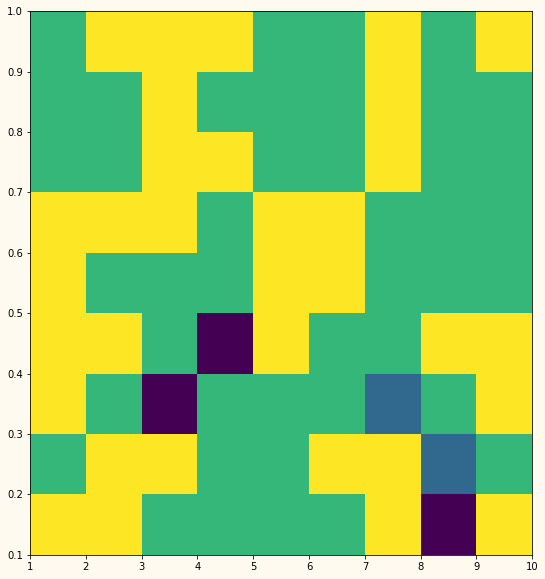

In [83]:
import matplotlib.pyplot as plt

def CheckStrategyDefender(d):
    NumberStrategy = {
        '1':'Nothing',
        '2':'High',
        '3':'High',
        '4':'High',
        '5':'High',
        '6':'High',
        '7':'High',
        '8':'High',
        '9':'High',
        '10':'High',
        '11':'Proportional',
        '12':'Proportional',
        '13':'Proportional',
        '14':'Proportional',
        '15':'Proportional',
        '16':'Proportional',
        '17':'Proportional',
        '18':'Proportional',
        '19':'Proportional'
    }
    return NumberStrategy[d]


c = [[0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0]]


x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

arrayEqlibrium = [17, 9, 12, 12, 13, 17, 10, 8, 9, 14, 12, 10, 11, 10, 15, 4, 9, 16, 5, 14, None, 10, 8, 16, 19, 19,
                 19, 6, 8, 7, None, 5, 6, 16, 5, 17, 9, 6, 9, 13, 18, 12, 3, 2, 10, 7, 11, 9, 2, 11, 19, 9, 5, 10, 17,
                 12, 1, 10, 10, 3, 12, 19, 14, None, 1, 10, 18, 2, 5, 8, 5, 6, 12, 8, 16, 17, 4, 9, 2, 7, 18, 2, 14, 1,
                 4, 1, 18, 11, 6, None]

i = 0
for s in range(0, 9, 1):
    for a in range(0, 9, 1):
        if arrayEqlibrium[i] != None:
            if CheckStrategyDefender(str(arrayEqlibrium[i])) == 'Nothing':
                c[a][s] = 5
            if CheckStrategyDefender(str(arrayEqlibrium[i])) == 'Proportional':
                c[a][s] = 15
            if CheckStrategyDefender(str(arrayEqlibrium[i])) == 'High':
                c[a][s] = 10
        i += 1
print('i =', i)

fig, ax = plt.subplots()

ax.pcolormesh(x, y, c)

fig.set_figwidth(9)    #  ширина и
fig.set_figheight(10)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

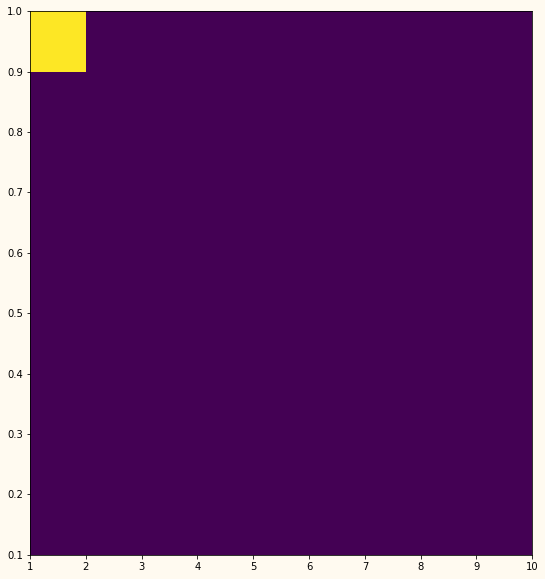

In [80]:
c = [[0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0]]


x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

arrayEqlibrium = [17, 9, 12, 12, 13, 17, 10, 8, 9, 14, 12, 10, 11, 10, 15, 4, 9, 16, 5, 14, None, 10, 8, 16, 19, 19,
                 19, 6, 8, 7, None, 5, 6, 16, 5, 17, 9, 6, 9, 13, 18, 12, 3, 2, 10, 7, 11, 9, 2, 11, 19, 9, 5, 10, 17,
                 12, 1, 10, 10, 3, 12, 19, 14, None, 1, 10, 18, 2, 5, 8, 5, 6, 12, 8, 16, 17, 4, 9, 2, 7, 18, 2, 14, 1,
                 4, 1, 18, 11, 6, None]

i = 0
c[8][0] = 5

fig, ax = plt.subplots()

ax.pcolormesh(x, y, c)

fig.set_figwidth(9)    #  ширина и
fig.set_figheight(10)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

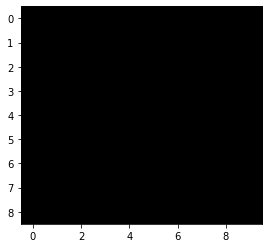

In [51]:
#lol[lol[:0,:3,-1]]=(255, 0, 0) 
plt.imshow(lol)

In [52]:
lol

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
  